In [8]:
spark.stop()

20200401-161808 [ERROR] An error occurred while trying to connect to the Java server (127.0.0.1:38693)
Traceback (most recent call last):
  File "/opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/site-packages/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
  File "/opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/socket.py", line 228, in meth
    return getattr(self._sock,name)(*args)
error: [Errno 111] Connection refused
/opt/cloudera/parcels/SPARK2/lib/spark2/python/pyspark/context.py:430: RuntimeWarning: Unable to cleanly shutdown Spark JVM process. It is possible that the process has crashed, been killed or may also be in a zombie state.
  RuntimeWarning


# Set paths

DEVEL_SRC must contain the directory use-cases and pykhaos

In [1]:
import os, sys
import datetime as dt
DEVEL_SRC = os.path.join(os.environ.get('BDA_USER_HOME', ''), "src", "devel")
if DEVEL_SRC not in sys.path:
    sys.path.append(DEVEL_SRC)

USECASES_SRC = os.path.join(DEVEL_SRC, "use-cases") # TODO when '-' is removed from name, remove also this line and adapt imports 
if USECASES_SRC not in sys.path: 
    sys.path.append(USECASES_SRC)
    
# AMDOCS_SRC = os.path.join(DEVEL_SRC, "amdocs_informational_dataset") # TODO when - is removed, remove also this line and adapt imports
# if AMDOCS_SRC not in sys.path: 
#     sys.path.append(AMDOCS_SRC)
    
import pykhaos.utils.custom_logger as clogger
logging_file = os.path.join(os.environ.get('BDA_USER_HOME', ''), "logging",
                                    "nb_social_" + dt.datetime.now().strftime("%Y%m%d_%H%M%S") + ".log")
logger = clogger.configure_logger(log_filename=logging_file, std_channel=sys.stderr, logger_name="")
logger.info("Logging to file {}".format(logging_file))    
        
from project.project_generic import Project

import pykhaos.utils.notebooks as nb

import time
start_time = time.time()

RUNNING_FROM_NOTEBOOK = nb.isnotebook()
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
if RUNNING_FROM_NOTEBOOK:
    %load_ext autoreload
    %autoreload 2
    %matplotlib inline  
    EXTERNAL_LIB = os.path.join(os.environ.get('BDA_USER_HOME', ''), "lib", "external_libs")
    if EXTERNAL_LIB not in sys.path:
        sys.path.append(EXTERNAL_LIB)
    # feel free from commenting this line and the other ones that begin with "%%notify" if you do not have 
    # the extension installed or copy de lib from /var/SP/data/home/csanc109/lib/external_libs/jupyternotify/
    %load_ext jupyternotify 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

20200401-103337 [INFO ] Logging to file /var/SP/data/home/csanc109/logging/nb_social_20200401_103337.log


<IPython.core.display.Javascript object>

In [2]:
from pyspark.sql import Row, DataFrame, Column, Window
from pyspark.sql.types import DoubleType, StringType, IntegerType, DateType, ArrayType
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler, SQLTransformer, OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.sql.functions import collect_set, concat, size, coalesce, col, trim, lpad, struct, upper, lower, avg as sql_avg, count as sql_count, lag, lit, min as sql_min, max as sql_max, collect_list, udf, when, desc, asc, to_date, create_map, sum as sql_sum, length, concat_ws, regexp_replace, split
from pyspark.sql.types import StringType, ArrayType, MapType, StructType, StructField, IntegerType
from pyspark.sql.functions import array, regexp_extract
from itertools import chain
from churn.datapreparation.general.data_loader import get_unlabeled_car, get_port_requests_table, get_numclients_under_analysis
from churn.utils.constants import PORT_TABLE_NAME
from churn.utils.udf_manager import Funct_to_UDF
from pyspark.sql.functions import substring, datediff, row_number

import datetime as dt
from pyspark.sql.functions import from_unixtime,unix_timestamp
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import time
start_time = time.time()


from churn_nrt.src.utils.spark_session import get_spark_session

sc, spark, sql_context = get_spark_session("social")
sc.setLogLevel('WARN')

In [ ]:

LIST_GNV_HOURS = list(range(0, 24))
LIST_GNV_USAGE_TYPES = ["Chat_Zero",
                        "Maps_Pass",
                        "VideoHD_Pass",
                        "Video_Pass",
                        "MasMegas",
                        "Music_Pass",
                        "Social_Pass",
                        "RegularData"]
LIST_GNV_PERIODS = ["W", "WE"]

LIST_GNV_ROAM_DATA_ZONES = list(range(1, 5))
LIST_GNV_ROAM_HOUR_RANGES = ['morning', 'evening', 'night']
LIST_GNV_ROAM_VOICE_ZONES = list(range(1, 6)) + ['EEUU', 'MARITIMO']

FIRST_LEVEL_TREATMENT = ['BUZON_DE_VOZ', 'COMUNIDAD_YU_VOZ', 'LLAMADAS_VPN', 'NACIONALES', 'VIDELOTELEFONIA', 'TARIFICACION_ADICIONAL_PRESTADOR']
SECOND_LEVEL_TREATMENT = ['MOVILES', 'INTERNACIONALES', 'OTROS_DESTINOS', 'SERVICIOS_GRATUITOS']

COUNTRIES_GNV_INTERNATIONAL = ['OTHER','AFGANISTAN','ALASKA','ALBANIA','ALEMANIA','ANDORRA','ANGOLA','ANGUILLA','ANTIGUA_Y_BARBUDA','ANTILLAS_HOLANDESAS','ARABIA_SAUDITA','ARGELIA','ARGENTINA','ARMENIA','ARUBA','AUSTRALIA','AUSTRIA','AZERBAIYAN','BELGICA','BAHAMAS','BAHREIN','BANGLADESH','BARBADOS','BELICE','BENIN','BERMUDAS','BHUTAN','BIELORRUSIA','BIRMANIA','BOLIVIA','BOSNIA','BOSNIA_MOSTAR','BOSNIA_SRPSKE','BOTSWANA','BRASIL','BRUNEI','BULGARIA','BURKINA_FASO','CABO_VERDE','CAMBOYA','CAMERUN','CANADA','CHAD','CHILE','CHINA','CHIPRE','COLOMBIA','CONGO','COREA_REP','COSTA_DE_MARFIL','COSTA_RICA','CROACIA','CUBA','DINAMARCA','DOMINICANA_REP','ECUADOR','ECUADOR__PORTA','EEUU','EGIPTO','EL_SALVADOR','EMIRATOS_ARABES_UNIDOS','EMIRATOS_ARABES_UNIDOS_MOVIL','ESLOVENIA','ESTONIA','ETIOPIA','FILIPINAS','FINLANDIA','FIYI','FRANCIA','GABON','GAMBIA','GEORGIA','GHANA','GIBRALTAR','GRECIA','GUADALUPE','GUAM','GUATEMALA','GUAYANA','GUAYANA_FRANCESA','GUINEA','GUINEA_ECUATORIAL','GUINEABISSAU','HAITI','HAWAI','HONDURAS','HONG_KONG','HUNGRIA','I_VIRGENES_AMERICANAS','I_VIRGENES_BRITANICAS','INDIA','INDONESIA','IRAN','IRAQ','IRLANDA','ISLA_NIUE','ISLANDIA','ISLAS_CAIMANES','ISLAS_COOK','ISLAS_FEROE','ISLAS_MALVINAS','ISLAS_MARSHALL','ISLAS_SALOMON','ISRAEL','ITALIA','JAMAICA','JAPON','JORDANIA','KAZAJASTAN','KENYA','KIRGUIZISTAN','KOSOVO','KUWAIT','LIBANO','LAOS','LESOTHO','LETONIA','LIBERIA','LIBIA','LIECHTENSTEIN','LITUANIA','LUXEMBURGO','MEJICO','MONACO','MACAO','MACEDONIA','MADAGASCAR','MALI','MALASIA','MALDIVAS','MALTA','MARRUECOS','MARTINICA','MAURICIO','MAURITANIA','MAYOTTE','MOLDAVIA','MONGOLIA','MONTENEGRO','MOZAMBIQUE','NAMIBIA','NEPAL','NICARAGUA','NIGER','NIGERIA','NORUEGA','NUEVA_CALEDONIA','NUEVA_ZELANDA','OMAN','PAISES_BAJOS','PAKISTAN','PALAU','PALESTINA','PANAMA','PAPUA_NUEVA_GUINEA','PARAGUAY','PERU','POLINESIA_FRANCESA','POLONIA','PORTUGAL','PUERTO_RICO','QATAR','REINO_UNIDO','REPUBLICA_CHECA','REPUBLICA_ESLOVACA','REPUBLICA_CENTROAFRICANA','REUNION','RUANDA','RUMANIA','RUSIA','SAN_MARINO','SAN_MARTIN','SAN_PEDRO_Y_MIQUELON','SAN_VICENTE_Y_GRANADINAS','SANTO_TOME_Y_PRINCIPE_MOVIL','SENEGAL','SERBIA','SEYCHELLES','SIERRA_LEONA','SINGAPUR','SIRIA','SOMALIA','SRI_LANKA','STA_LUCIA','SUDAN','SUDAFRICA','SUECIA','SUIZA','SURINAM','SWAZILANDIA','TUNEZ','TADJIKISTAN','TAILANDIA','TAIWAN','TANZANIA','TIMOR_ORIENTAL','TOGO','TRINIDAD_Y_TOBAGO','TURKMENISTAN','TURQUIA','UCRANIA','UGANDA','URUGUAY','UZBEKISTAN','VENEZUELA','VIETNAM','YEMEN','ZAIRE','ZAMBIA','ZIMBABWE']
PROVIDERS_GNV_MOBILE = ['OTHER','AIRE','BARABLU','BT_ESPANA','CARREFOUR','DIA','DIGI_SPAIN','EROSKI','EUSKALTEL','HAPPY_MOVIL','HITS_TELECOM','INGENIUM','JAZZTEL','KPN_SPAIN','LCR_TELECOM','LEBARA','LYCAMOBILE','MAS_MOVIL','MORE_MINUTES','NEOSKY','ORANGE','ORBITEL','PEPEPHONE','PROCONO','R','R_CABLE','TELECABLE','TELEFONICA','TUENTI','VODAFONE','VODAFONE_ENABLER','YOIGO','YOU_MOBILE']
SERVICES_GNV_FREE = ['OTHER','AMENA','ASESOR_COMERCIAL_EMPRESAS','ASISTENCIA_TECNICA','AT_COMERCIAL','AT_EMPRESAS','ATENCION_AL_CLIENTE','ATT_AL_CLIENTE','BOMBEROS_PROV','COMUNITEL','CRUZ_ROJA','EMERGENCIA','ESPECIAL','ESPECIAL_ATENCION_AL_CLIENTE','EUSKALTEL_SA','GRUPO_VODAFONE','INF_MOVISTAR','INF_UNI2','INFOOFCOMTEL','INFORMACION_ORANGE_1515','JAZZTEL','LINEA_800','LINEA_800_INTERNACIONAL','LINEA_800_VODAFONE','LINEA_900','LINEA_900_CONFIDENCIAL','LINEA_900_N1','LINEA_900_VODAFONE','R_GALICIA','SERVICIO_DE_INF_Y_VENTAS','TELE2','TELEFONICA','TFNO_INFORMACION_GRATUITO','TONOS_DE_ESPERA','VALENCIA_CABLE','XTRA_TELECOM_SA']
SERVICE_GNV_OTHER = ['OTHER','ADM_GENERAL_ESTADO','ATENCION_CIUDADANA','ATT_MUNICIPAL','BOMBEROS_LOCAL','GUARDIA_CIVIL','INF_AUTONOMICA','INFORMACION_AVYS_TELECOM','INFORMACION_EUSKALTEL_SA','INFORMACION_HELLO_TV','LINEA_901','LINEA_902','LINEA_902_N1','LINEA_902_VODAFONE','LINEA_905_SOPORTE','POLICIA','POLICMUNICIPAL','URGENC_INSALUD']


def get_partitions_path_range(path, start, end):
    """
    Returns a list of complete paths with data to read of the source between two dates
    :param path: string path
    :param start: string date start
    :param end: string date end
    :return: list of paths
    """
    star_date = dt.datetime.strptime(start, '%Y%m%d')
    delta = dt.datetime.strptime(end, '%Y%m%d') - dt.datetime.strptime(start, '%Y%m%d')
    days_list = [star_date + dt.timedelta(days=i) for i in range(delta.days + 1)]
    return [path + "year={}/month={}/day={}".format(d.year, d.month, d.day) for d in days_list]

path_raw_base = '/data/raw/vf_es/'
PATH_RAW_GENEVA_TRAFFIC = path_raw_base + 'billingtopsups/TRAFFICTARIFOW/1.0/parquet/'


def get_geneva_df(spark, starting_day, closing_day):

    # https://gitlab.rat.bdp.vodafone.com/bda-es/amdocs_inf_dataset/blob/stable_ids/src/main/python/pipelines/geneva_traffic.py
    geneva_traffic_paths = get_partitions_path_range(PATH_RAW_GENEVA_TRAFFIC, starting_day, closing_day)
    print(geneva_traffic_paths)
    data_usage_gnv_ori_voice = (spark.read.load(geneva_traffic_paths)
                                .where((col('event_type_id').isin(1, 13, 18)))
                                .drop(*['service_processed_at', 'service_file_id'])
                                )
    
    data_usage_gnv_ori_voice = data_usage_gnv_ori_voice.cache()
    data_usage_gnv_voice_tmp1 = (data_usage_gnv_ori_voice
                                 .withColumnRenamed('event_attr_1_msisdn', 'msisdn')
                                 .withColumn('Duration',
                                             when(col('event_type_id') == 1, col('event_attr_3').cast('integer'))
                                             .when(col('event_type_id') == 13, col('event_attr_13').cast('integer'))
                                             .when(col('event_type_id') == 18, col('event_attr_16').cast('integer'))
                                             .otherwise(0))
                                 .withColumn('Cost_Band',
                                             when(col('event_type_id') == 1, col('event_attr_8').cast('integer'))
                                             .when(col('event_type_id') == 13, col('event_attr_13').cast('integer'))
                                             .when(col('event_type_id') == 18, col('event_attr_6').cast('integer'))
                                             .otherwise(0))
                                 .withColumn('usage_type',
                                             when(col('event_type_id') == 1, col('event_attr_9'))
                                             .when(col('event_type_id') == 13, lit(None))
                                             .when(col('event_type_id') == 18, col('event_attr_10'))
                                             .otherwise(None))
                                 .withColumn('usage_type_detail',
                                             upper(when(col('event_type_id') == 1, col('event_attr_10'))
                                                   .when(col('event_type_id') == 13, lit(None))
                                                   .when(col('event_type_id') == 18, col('event_attr_17'))
                                                   .otherwise(None)))
                                 # cleansing_v2
                                 .withColumn('usage_type_clean', regexp_replace(upper(col('usage_type')), 'Ó|Ã³|ÃÂ³', 'O'))
                                 .withColumn('usage_type_clean', regexp_replace(col('usage_type_clean'), 'Í|Ã­|ÃÂ­', 'I'))
                                 .withColumn('usage_type_clean', regexp_replace(col('usage_type_clean'), 'É|Ã©|ÃÂ©', 'E'))
                                 .withColumn('usage_type_clean', regexp_replace(col('usage_type_clean'), 'Ú|Ãº|ÃÂº', 'U'))
                                 .withColumn('usage_type_clean', regexp_replace(col('usage_type_clean'), 'Á|Ã¡|ÃÂ¡', 'A'))
                                 .withColumn('usage_type_clean', regexp_replace(col('usage_type_clean'), '\.|,|\-|\(|\)', ''))
                                 .withColumn('usage_type_clean', regexp_replace(col('usage_type_clean'), 'Ñ', 'N'))
                                 .withColumn('usage_type_clean', regexp_replace(trim(col('usage_type_clean')), ' ', '_'))
                                 .withColumn('usage_type_clean', regexp_replace(trim(col('usage_type_clean')), 'VFONO_PROVINCIALES|NACIONAL_VF_CASA|PROVINCIALES','NACIONALES'))

                                 .withColumn('usage_type_detail_clean', regexp_replace(upper(col('usage_type_detail')), 'Ó|Ã³|ÃÂ³', 'O'))
                                 .withColumn('usage_type_detail_clean', regexp_replace(col('usage_type_detail_clean'), 'Í|Ã­|ÃÂ­', 'I'))
                                 .withColumn('usage_type_detail_clean', regexp_replace(col('usage_type_detail_clean'), 'É|Ã©|ÃÂ©', 'E'))
                                 .withColumn('usage_type_detail_clean', regexp_replace(col('usage_type_detail_clean'), 'Ú|Ãº|ÃÂº', 'U'))
                                 .withColumn('usage_type_detail_clean', regexp_replace(col('usage_type_detail_clean'), 'Ã±|ÃÂ±', 'Ñ'))
                                 .withColumn('usage_type_detail_clean', regexp_replace(col('usage_type_detail_clean'), 'Á|Ã¡|ÃÂ¡|ÃÂ|Ã', 'A'))

                                 .withColumn('usage_type_detail_clean',regexp_replace(col('usage_type_detail_clean'),'PRESTADOR|\(\)|MOVILES|\.|\-|,', ''))
                                 .withColumn('usage_type_detail_clean',regexp_replace(col('usage_type_detail_clean'), 'Ñ', 'N'))
                                 .withColumn('usage_type_detail_clean',regexp_replace(trim(col('usage_type_detail_clean')), ' ', '_'))

                                 .withColumn('row_tag', when((col('usage_type_clean') == 'INTERNACIONALES') & (col('usage_type_detail_clean').isin(COUNTRIES_GNV_INTERNATIONAL)), concat(col('usage_type_clean'), lit('_'),col('usage_type_detail_clean')))
                                             .when((col('usage_type_clean') == 'INTERNACIONALES') & (~col('usage_type_detail_clean').isin(COUNTRIES_GNV_INTERNATIONAL)), concat(col('usage_type_clean'), lit('_OTHER')))
                                             .when((col('usage_type_clean') == 'MOVILES') & (col('usage_type_detail_clean').isin(PROVIDERS_GNV_MOBILE)), concat(col('usage_type_clean'), lit('_'), col('usage_type_detail_clean')))
                                             .when((col('usage_type_clean') == 'MOVILES') & (~col('usage_type_detail_clean').isin(PROVIDERS_GNV_MOBILE)), concat(col('usage_type_clean'), lit('_OTHER')))
                                             .when((col('usage_type_clean') == 'OTROS_DESTINOS') & (col('usage_type_detail_clean').isin(SERVICE_GNV_OTHER)), concat(col('usage_type_clean'), lit('_'), col('usage_type_detail_clean')))
                                             .when((col('usage_type_clean') == 'OTROS_DESTINOS') & (~col('usage_type_detail_clean').isin(SERVICE_GNV_OTHER)), concat(col('usage_type_clean'), lit('_OTHER')))
                                             .when((col('usage_type_clean') == 'SERVICIOS_GRATUITOS') & (col('usage_type_detail_clean').isin(SERVICES_GNV_FREE)), concat(col('usage_type_clean'), lit('_'), col('usage_type_detail_clean')))
                                             .when((col('usage_type_clean') == 'SERVICIOS_GRATUITOS') & (~col('usage_type_detail_clean').isin(SERVICES_GNV_FREE)), concat(col('usage_type_clean'), lit('_OTHER')))
                                             .when(col('usage_type_clean').isin(FIRST_LEVEL_TREATMENT), col('usage_type_clean'))
                                             .otherwise(None))
                                 .where(col('row_tag').isNotNull())
                                 .withColumn('row_tag', concat(lit('GNV_Type_Voice_'), col('row_tag')))

                                 .select('msisdn', 'event_attr_2_msisdn', 'event_dtm', 'duration',
                                         'usage_type_clean', 'usage_type_detail_clean', 'row_tag')
                                 .dropDuplicates()
                                 )
    # TODO change this for the list SECOND_LEVEL_TREATMENT
    VALUES_TO_PIVOT = ['GNV_Type_Voice_{p}'.format(p=p) for p in FIRST_LEVEL_TREATMENT]
    VALUES_TO_PIVOT += ["GNV_Type_Voice_INTERNACIONALES_{p}".format(p=p) for p in COUNTRIES_GNV_INTERNATIONAL]
    VALUES_TO_PIVOT += ["GNV_Type_Voice_MOVILES_{p}".format(p=p) for p in PROVIDERS_GNV_MOBILE]
    VALUES_TO_PIVOT += ["GNV_Type_Voice_SERVICIOS_GRATUITOS_{p}".format(p=p) for p in SERVICES_GNV_FREE]
    VALUES_TO_PIVOT += ["GNV_Type_Voice_OTROS_DESTINOS_{p}".format(p=p) for p in SERVICE_GNV_OTHER]

    data_usage_gnv_voice_tmp2 = (data_usage_gnv_voice_tmp1
                                 .groupBy('msisdn')
                                 .pivot('row_tag', VALUES_TO_PIVOT)
                                 .agg((sql_sum("Duration") / 60.00).alias("MOU"),
                                      sql_count(lit(1)).alias("Num_Of_Calls"))
                                 .na.fill(0))
    logger.info("Ended - Calculating Voice Usage Type Information")

    na_map = set_module_metadata()
#     df_table = Metadata().apply_metadata_dict(data_usage_gnv_voice_tmp2, null_map)
    final_map = {colmn: na_map[colmn][0] for colmn in data_usage_gnv_voice_tmp2.columns
                     if colmn in na_map.keys() and na_map[colmn][1] != "id"}
    df_table = data_usage_gnv_voice_tmp2.fillna(final_map)

    df_table = df_table.withColumn("service_processed_at", lit(dt.datetime.now()).cast("timestamp"))

    return df_table

def set_module_metadata():

        cols = ['{p}'.format(p=p) for p in FIRST_LEVEL_TREATMENT]
        cols += ["INTERNACIONALES_{p}".format(p=p) for p in COUNTRIES_GNV_INTERNATIONAL]
        cols += ["MOVILES_{p}".format(p=p) for p in PROVIDERS_GNV_MOBILE]
        cols += ["SERVICIOS_GRATUITOS_{p}".format(p=p) for p in SERVICES_GNV_FREE]
        cols += ["OTROS_DESTINOS_{p}".format(p=p) for p in SERVICE_GNV_OTHER]

        fill_zero = ["GNV_Type_Voice_{}_{}".format(clmn, pivot)
                     for pivot in ["MOU", "Num_Of_Calls"]
                     for clmn in cols]
        module = "gnv_type"
        na_map = dict([(k, ("", "id", module,)) for k in ["msisdn"]] +
                      [(k, (0, "numerical", module,)) for k in fill_zero])


        return na_map



# Primer analisis - 

In [13]:
closing_day = "20190131"
range_days = 90

from churn_nrt.src.utils.date_functions import move_date_n_days, move_date_n_cycles
starting_day = move_date_n_days(closing_day, n=-range_days)

# df = (spark.read.load("/data/udf/vf_es/amdocs_inf_dataset/usage_geneva_voice_type/").withColumnRenamed("id_msisdn", "msisdn")
#          .withColumn("formatted_date", concat(col('year'), lpad(col('month'), 2, '0'), lpad(col('day'), 2, '0')))
#          .where(col("formatted_date")<=closing_day)
#          .where(col("formatted_date")>=starting_day))

dfs = []

cc = closing_day


for ii in range(0,range_days/30): 
    print(ii, cc)
    df_aux = spark.read.load("/data/udf/vf_es/amdocs_inf_dataset/usage_geneva_voice_type/year={}/month={}/day={}".format(int(cc[:4]), 
                                                                                                                         int(cc[4:6]), 
                                                                                                                         int(cc[6:]))).withColumnRenamed('id_msisdn', "msisdn")
    cc = move_date_n_cycles(cc, n=-4)
    dfs.append(df_aux)

from churn_nrt.src.utils.pyspark_utils import union_all

df = union_all(dfs)
    
print("df.count()", df.count())

cols = [col_ for col_ in df.columns if col_.startswith("GNV_Type_Voice_MOVILES_") or col_ in ["msisdn", "formatted_date"]]
df = df.select(cols)
operators = list(set([col_.replace("GNV_Type_Voice_MOVILES_", "").replace("_Num_Of_Calls","").replace("_MOU", "") for col_ in cols if col_ not in ["msisdn", "formatted_date"]]))
print(operators)
other_operators = list(set(operators) - set(['VODAFONE', 'VODAFONE_ENABLER']))
vf_operators = ['VODAFONE', 'VODAFONE_ENABLER']




from churn_nrt.src.utils.pyspark_utils import sum_horizontal
df = df.withColumn("num_calls_other_operators", sum_horizontal(["GNV_Type_Voice_MOVILES_{}_Num_Of_Calls".format(op) for op in other_operators]))
df = df.withColumn("num_calls_vf", sum_horizontal(["GNV_Type_Voice_MOVILES_{}_Num_Of_Calls".format(op) for op in vf_operators]))
df = df.withColumn("mou_other_operators", sum_horizontal(["GNV_Type_Voice_MOVILES_{}_MOU".format(op) for op in other_operators]))
df = df.withColumn("mou_vf", sum_horizontal(["GNV_Type_Voice_MOVILES_{}_MOU".format(op) for op in vf_operators]))

print("df={}".format(df.count()))

df_agg = (df.groupby("msisdn").agg(sql_sum("num_calls_other_operators").alias('total_calls_other_operator'), # .over(w))
             sql_sum("num_calls_vf").alias('total_calls_vf'), # .over(w))
             sql_sum("mou_other_operators").alias('total_mou_other_operator'), # .over(w))
             sql_sum("mou_vf").alias('total_mou_vf'))) # .over(w))


print("df_agg={}".format(df_agg.count()))

df_agg = df_agg.withColumn("total_calls", col('total_calls_other_operator') + col('total_calls_vf'))
df_agg = df_agg.withColumn("total_mou", col('total_mou_other_operator') + col('total_mou_vf'))


from churn_nrt.src.data.customer_base import CustomerBase

df_cust_base = CustomerBase(spark).get_module(closing_day).where(col("rgu")=="mobile")
df_agg = df_agg.join(df_cust_base, on=["msisdn"], how="inner")


print("Before filter {}".format(df_agg.count()))
df_agg = df_agg.where(col("total_calls")>0)
print("After filter {}".format(df_agg.count()))

df_agg = df_agg.withColumn("perc_calls_other_ops", col('total_calls_other_operator') / col("total_calls"))
df_agg = df_agg.withColumn("perc_mou_other_ops", col('total_mou_other_operator') / col("total_mou"))



df_agg = df_agg.cache()
print("df_agg.count()", df_agg.count())


from churn_nrt.src.data.sopos_dxs import MobPort
df_target = MobPort(spark, churn_window=15).get_module(closing_day).withColumnRenamed("label_mob", "label")
df_target = df_target.cache()
print("df_target.count()", df_target.count())


df_all = df_agg.join(df_target, on=["msisdn"], how="left").fillna(0.0)

df_all = df_all.cache()
print("df_all.count()", df_all.count())

ch_rate_ref = df_all.select(sql_avg("label").alias('churn_ref')).rdd.first()['churn_ref']
print("Ch Rate Ref = {} %".format(100.0 * ch_rate_ref))

(0, '20190131')
(1, '20181231')
(2, '20181130')
('df.count()', 26058147)
['JAZZTEL', 'NEOSKY', 'CARREFOUR', 'MORE_MINUTES', 'HITS_TELECOM', 'DIA', 'YOIGO', 'LCR_TELECOM', 'TUENTI', 'TELECABLE', 'ORBITEL', 'DIGI_SPAIN', 'MAS_MOVIL', 'BT_ESPANA', 'EUSKALTEL', 'INGENIUM', 'HAPPY_MOVIL', 'TELEFONICA', 'PEPEPHONE', 'R_CABLE', 'ORANGE', 'LYCAMOBILE', 'KPN_SPAIN', 'EROSKI', 'YOU_MOBILE', 'OTHER', 'LEBARA', 'AIRE', 'BARABLU', 'VODAFONE_ENABLER', 'R', 'PROCONO', 'VODAFONE']
df=26058147
df_agg=10641006
[DataTemplate] __init__ | module name = customer_base | path = /data/udf/vf_es/churn_nrt/customer_base | verbose = True
[DataTemplate] get_module | module customer_base - for closing_day=20190131 save=True save_others=True force_gen=False
[DataTemplate] get_module | args: () | kwargs: {}
[CustomerBase] is_default_module | args: () | kwargs: {}
[DataTemplate] get_module | Found already an existing module - '/data/udf/vf_es/churn_nrt/customer_base/year=2019/month=1/day=31'


Py4JJavaError: An error occurred while calling o2671.count.
: org.apache.spark.sql.catalyst.errors.package$TreeNodeException: execute, tree:
Exchange SinglePartition
+- *(6) HashAggregate(keys=[], functions=[partial_count(1)], output=[count#156199L])
   +- *(6) Project
      +- *(6) BroadcastHashJoin [msisdn#149494], [msisdn#156108], Inner, BuildLeft
         :- BroadcastExchange HashedRelationBroadcastMode(ArrayBuffer(input[0, string, true]))
         :  +- *(5) HashAggregate(keys=[msisdn#149494], functions=[], output=[msisdn#149494])
         :     +- Exchange hashpartitioning(msisdn#149494, 200)
         :        +- *(4) HashAggregate(keys=[msisdn#149494], functions=[], output=[msisdn#149494])
         :           +- Union
         :              :- *(1) Project [id_msisdn#148280 AS msisdn#149494]
         :              :  +- *(1) Filter isnotnull(id_msisdn#148280)
         :              :     +- *(1) FileScan parquet [id_msisdn#148280] Batched: true, Format: Parquet, Location: InMemoryFileIndex[hdfs://nameservice1/data/udf/vf_es/amdocs_inf_dataset/usage_geneva_voice_type/y..., PartitionFilters: [], PushedFilters: [IsNotNull(id_msisdn)], ReadSchema: struct<id_msisdn:string>
         :              :- *(2) Project [id_msisdn#150102 AS msisdn#151316]
         :              :  +- *(2) Filter isnotnull(id_msisdn#150102)
         :              :     +- *(2) FileScan parquet [id_msisdn#150102] Batched: true, Format: Parquet, Location: InMemoryFileIndex[hdfs://nameservice1/data/udf/vf_es/amdocs_inf_dataset/usage_geneva_voice_type/y..., PartitionFilters: [], PushedFilters: [IsNotNull(id_msisdn)], ReadSchema: struct<id_msisdn:string>
         :              +- *(3) Project [id_msisdn#151924 AS msisdn#153138]
         :                 +- *(3) Filter isnotnull(id_msisdn#151924)
         :                    +- *(3) FileScan parquet [id_msisdn#151924] Batched: true, Format: Parquet, Location: InMemoryFileIndex[hdfs://nameservice1/data/udf/vf_es/amdocs_inf_dataset/usage_geneva_voice_type/y..., PartitionFilters: [], PushedFilters: [IsNotNull(id_msisdn)], ReadSchema: struct<id_msisdn:string>
         +- *(6) Project [msisdn#156108]
            +- *(6) Filter ((isnotnull(rgu#156109) && (rgu#156109 = mobile)) && isnotnull(msisdn#156108))
               +- *(6) FileScan parquet [msisdn#156108,rgu#156109] Batched: true, Format: Parquet, Location: InMemoryFileIndex[hdfs://nameservice1/data/udf/vf_es/churn_nrt/customer_base/year=2019/month=1/da..., PartitionFilters: [], PushedFilters: [IsNotNull(rgu), EqualTo(rgu,mobile), IsNotNull(msisdn)], ReadSchema: struct<msisdn:string,rgu:string>

	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:56)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.doExecute(ShuffleExchangeExec.scala:119)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.InputAdapter.inputRDDs(WholeStageCodegenExec.scala:371)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.inputRDDs(HashAggregateExec.scala:150)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:605)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan.getByteArrayRdd(SparkPlan.scala:247)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:294)
	at org.apache.spark.sql.Dataset$$anonfun$count$1.apply(Dataset.scala:2775)
	at org.apache.spark.sql.Dataset$$anonfun$count$1.apply(Dataset.scala:2774)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3259)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:77)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3258)
	at org.apache.spark.sql.Dataset.count(Dataset.scala:2774)
	at sun.reflect.GeneratedMethodAccessor136.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.util.concurrent.TimeoutException: Futures timed out after [1200 seconds]
	at scala.concurrent.impl.Promise$DefaultPromise.ready(Promise.scala:219)
	at scala.concurrent.impl.Promise$DefaultPromise.result(Promise.scala:223)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:201)
	at org.apache.spark.sql.execution.exchange.BroadcastExchangeExec.doExecuteBroadcast(BroadcastExchangeExec.scala:136)
	at org.apache.spark.sql.execution.InputAdapter.doExecuteBroadcast(WholeStageCodegenExec.scala:367)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeBroadcast$1.apply(SparkPlan.scala:144)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeBroadcast$1.apply(SparkPlan.scala:140)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.executeBroadcast(SparkPlan.scala:140)
	at org.apache.spark.sql.execution.joins.BroadcastHashJoinExec.prepareBroadcast(BroadcastHashJoinExec.scala:135)
	at org.apache.spark.sql.execution.joins.BroadcastHashJoinExec.codegenInner(BroadcastHashJoinExec.scala:232)
	at org.apache.spark.sql.execution.joins.BroadcastHashJoinExec.doConsume(BroadcastHashJoinExec.scala:102)
	at org.apache.spark.sql.execution.CodegenSupport$class.constructDoConsumeFunction(WholeStageCodegenExec.scala:208)
	at org.apache.spark.sql.execution.CodegenSupport$class.consume(WholeStageCodegenExec.scala:179)
	at org.apache.spark.sql.execution.ProjectExec.consume(basicPhysicalOperators.scala:35)
	at org.apache.spark.sql.execution.ProjectExec.doConsume(basicPhysicalOperators.scala:65)
	at org.apache.spark.sql.execution.CodegenSupport$class.consume(WholeStageCodegenExec.scala:181)
	at org.apache.spark.sql.execution.FilterExec.consume(basicPhysicalOperators.scala:85)
	at org.apache.spark.sql.execution.FilterExec.doConsume(basicPhysicalOperators.scala:206)
	at org.apache.spark.sql.execution.CodegenSupport$class.consume(WholeStageCodegenExec.scala:181)
	at org.apache.spark.sql.execution.FileSourceScanExec.consume(DataSourceScanExec.scala:158)
	at org.apache.spark.sql.execution.ColumnarBatchScan$class.produceBatches(ColumnarBatchScan.scala:138)
	at org.apache.spark.sql.execution.ColumnarBatchScan$class.doProduce(ColumnarBatchScan.scala:78)
	at org.apache.spark.sql.execution.FileSourceScanExec.doProduce(DataSourceScanExec.scala:158)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:88)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:83)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.CodegenSupport$class.produce(WholeStageCodegenExec.scala:83)
	at org.apache.spark.sql.execution.FileSourceScanExec.produce(DataSourceScanExec.scala:158)
	at org.apache.spark.sql.execution.FilterExec.doProduce(basicPhysicalOperators.scala:125)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:88)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:83)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.CodegenSupport$class.produce(WholeStageCodegenExec.scala:83)
	at org.apache.spark.sql.execution.FilterExec.produce(basicPhysicalOperators.scala:85)
	at org.apache.spark.sql.execution.ProjectExec.doProduce(basicPhysicalOperators.scala:45)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:88)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:83)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.CodegenSupport$class.produce(WholeStageCodegenExec.scala:83)
	at org.apache.spark.sql.execution.ProjectExec.produce(basicPhysicalOperators.scala:35)
	at org.apache.spark.sql.execution.joins.BroadcastHashJoinExec.doProduce(BroadcastHashJoinExec.scala:97)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:88)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:83)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.CodegenSupport$class.produce(WholeStageCodegenExec.scala:83)
	at org.apache.spark.sql.execution.joins.BroadcastHashJoinExec.produce(BroadcastHashJoinExec.scala:39)
	at org.apache.spark.sql.execution.ProjectExec.doProduce(basicPhysicalOperators.scala:45)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:88)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:83)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.CodegenSupport$class.produce(WholeStageCodegenExec.scala:83)
	at org.apache.spark.sql.execution.ProjectExec.produce(basicPhysicalOperators.scala:35)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.doProduceWithoutKeys(HashAggregateExec.scala:234)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.doProduce(HashAggregateExec.scala:163)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:88)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:83)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.CodegenSupport$class.produce(WholeStageCodegenExec.scala:83)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.produce(HashAggregateExec.scala:39)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doCodeGen(WholeStageCodegenExec.scala:524)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:576)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.prepareShuffleDependency(ShuffleExchangeExec.scala:92)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$$anonfun$doExecute$1.apply(ShuffleExchangeExec.scala:128)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$$anonfun$doExecute$1.apply(ShuffleExchangeExec.scala:119)
	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:52)
	... 34 more


In [ ]:
bins = []
range_ = range(10,110,10)
#var_ = "perc_calls_other_ops"
var_ = "perc_mou_other_ops"
for perc in range_:
    bins.append(100.0*df_all.where(col(var_)>=(perc/100.0)).select(sql_avg("label").alias('churn_ref')).rdd.first()['churn_ref'])
    
    
fig, ax1 = plt.subplots()
    
#plt.figure()
ax1.plot(range_, bins)
ax1.grid(True)
#plt.yticks(list(range(10,110,10))) 
ax1.set_xlabel("{} >= th [%]".format(var_))
ax1.set_ylabel("churn rate [%] (ref=1.06 %)")
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('lift', color='tab:red')  # we already handled the x-label with ax1
ax2.plot(range_, [b/ch_rate_ref/100.0 for b in bins], color='tab:red', marker="o", linestyle = 'None')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
from churn_nrt.src.projects_utils.models.modeler import get_cumulative_churn_rate_fix_step
cum_churn_rate = get_cumulative_churn_rate_fix_step(df_all, ord_col =  'perc_calls_other_ops', label_col = 'label', step_=100000)

In [ ]:
import pandas as pd
cum_churn_rate.select("cum_volume", "cum_churn_rate").toPandas().plot(x="cum_volume",y="cum_churn_rate")

In [ ]:
from pyspark.sql.functions import expr
magic_percentile_05 = expr('percentile_approx(total_calls_other_operator, 0.5)')
magic_percentile_075 = expr('percentile_approx(total_calls_other_operator, 0.75)')

magic_percentile_05_vf = expr('percentile_approx(total_calls_vf, 0.5)')
magic_percentile_075_vf = expr('percentile_approx(total_calls_vf, 0.75)')



df_all.groupby("label").agg(sql_avg("total_calls_other_operator").alias("avg_calls_other_operator"),
                            sql_avg("total_calls_vf").alias("avg_calls_vf"),
                            sql_avg("total_mou_other_operator").alias("avg_mou_other_operator"),
                            sql_avg("total_mou_vf").alias("avg_mou_vf"),
                            sql_count("*").alias("count"),
#                             magic_percentile_05.alias('q2_calls_other_operator'),
#                             magic_percentile_075.alias('q3_calls_other_operator'),
#                             magic_percentile_05_vf.alias('q2_calls_vf'),
#                             magic_percentile_075_vf.alias('q3_calls_vf'),
                            *([expr('percentile_approx({}, {})'.format(col_, qq)).alias("q{}_{}".format(str(qq).replace(".",""), col_)) for qq in [0.5, 0.75] for col_ in ["total_calls_other_operator", "total_calls_vf", "total_mou_other_operator", "total_mou_vf"]])
                           ).show(truncate=False)

In [ ]:
for th in [20,25,30,50,60]:
    print(th, df_all.where(col("total_calls_other_operator")>th).count(), 100.0 * df_all.where(col("total_calls_other_operator")>th).select(sql_avg("label").alias('churn_ref')).rdd.first()['churn_ref'])


In [ ]:

df_sect = df_all.where(col("total_calls_other_operator")>3.1 * col("total_calls_vf"))
print(df_sect.count(), 100.0 * df_sect.select(sql_avg("label").alias('churn_ref')).rdd.first()['churn_ref'])


In [ ]:
df_sect = df_all.where(col("total_mou_other_operator")>12.1 * col("total_mou_vf")).where(col("total_calls_other_operator")>50)
print(df_sect.count(), 100.0 * df_sect.select(sql_avg("label").alias('churn_ref')).rdd.first()['churn_ref'])


In [ ]:
from churn_nrt.src.projects.models.social.analysis.incrementals import get_geneva_feats

df_gen = get_geneva_feats(spark, "20191201", "20191231")

# Segundo analisis - incrementales

In [ ]:
from churn_nrt.src.utils.date_functions import move_date_n_days, move_date_n_cycles

days_incremental = 15 


closing_day = "20191231"
closing_day_2 = "20191215"


starting_day = move_date_n_days(closing_day, n=-days_incremental)
starting_day_2 = move_date_n_days(closing_day_2, n=-days_incremental)


def get_geneva_feats(spark, starting_day, closing_day):

    df = get_geneva_df(spark, starting_day, closing_day)

    cols = [col_ for col_ in df.columns if col_.startswith("GNV_Type_Voice_MOVILES_") or col_ in ["msisdn", "formatted_date"]]
    df = df.select(cols)
    operators = list(set([col_.replace("GNV_Type_Voice_MOVILES_", "").replace("_Num_Of_Calls","").replace("_MOU", "") for col_ in cols if col_ not in ["msisdn", "formatted_date"]]))

    other_operators = list(set(operators) - set(['VODAFONE', 'VODAFONE_ENABLER']))
    vf_operators = ['VODAFONE', 'VODAFONE_ENABLER']



    from churn_nrt.src.utils.pyspark_utils import sum_horizontal
    df = df.withColumn("num_calls_other_operators", sum_horizontal(["GNV_Type_Voice_MOVILES_{}_Num_Of_Calls".format(op) for op in other_operators]))
    df = df.withColumn("num_calls_vf", sum_horizontal(["GNV_Type_Voice_MOVILES_{}_Num_Of_Calls".format(op) for op in vf_operators]))
    df = df.withColumn("mou_other_operators", sum_horizontal(["GNV_Type_Voice_MOVILES_{}_MOU".format(op) for op in other_operators]))
    df = df.withColumn("mou_vf", sum_horizontal(["GNV_Type_Voice_MOVILES_{}_MOU".format(op) for op in vf_operators]))

    df_agg = (df.groupby("msisdn").agg(*([sql_sum("num_calls_other_operators").alias('total_calls_other_operator'),
                                       sql_sum("num_calls_vf").alias('total_calls_vf'),
                                       sql_sum("mou_other_operators").alias('total_mou_other_operator'),
                                       sql_sum("mou_vf").alias('total_mou_vf')] +
                                       [sql_sum(col("GNV_Type_Voice_MOVILES_{}_Num_Of_Calls".format(op))).alias("num_calls_{}".format(op)) for op in other_operators] + 
                                       [sql_sum(col("GNV_Type_Voice_MOVILES_{}_MOU".format(op))).alias("mou_{}".format(op)) for op in other_operators]                                        
                                        )))


    df_agg = df_agg.withColumn("total_calls", col('total_calls_other_operator') + col('total_calls_vf'))
    df_agg = df_agg.withColumn("total_mou", col('total_mou_other_operator') + col('total_mou_vf'))

    df_agg = df_agg.withColumn("perc_calls_other_ops", when(col("total_calls")>0, col('total_calls_other_operator') / col("total_calls")).otherwise(-1))
    df_agg = df_agg.withColumn("perc_mou_other_ops",   when(col("total_mou")>0, col('total_mou_other_operator') / col("total_mou")).otherwise(-1))
   
              
    df_agg = df_agg.select(*(df_agg.columns + [when(col("total_calls")>0, (col('num_calls_{}'.format(op)) / col("total_calls"))).otherwise(-1).alias("perc_calls_{}".format(op)) for op in other_operators]))
              
              
    return df_agg 


df_agg = get_geneva_feats(spark, starting_day, closing_day)#.select("msisdn", "total_calls", "total_mou", "perc_calls_other_ops", "perc_mou_other_ops", 'total_calls_other_operator', 'total_calls_vf')
df_agg2 = get_geneva_feats(spark, starting_day_2, closing_day_2)#.select("msisdn", "total_calls", "total_mou", "perc_mou_other_ops", "perc_calls_other_ops", 'total_calls_other_operator', 'total_calls_vf')
new_suffixed_cols = [col_ + "_d{}".format(days_incremental) if col_ not in ["msisdn", "nif_cliente"] else col_ for col_ in df_agg2.columns]
df_agg2 = df_agg2.toDF(*new_suffixed_cols)

    
from churn_nrt.src.data.customer_base import CustomerBase

df_cust_base = CustomerBase(spark).get_module(closing_day).where(col("rgu")=="mobile")
df_agg = df_agg.join(df_cust_base.select("msisdn"), on=["msisdn"], how="inner")
df_agg_join = df_agg.join(df_agg2, on=["msisdn"], how="left").fillna(0.0)

df_agg_join = df_agg_join.cache()
print("Before filter {}".format(df_agg_join.count()))
df_agg_join = df_agg_join.where(col("total_calls")>0)
df_agg_join = df_agg_join.cache()
print("After filter {}".format(df_agg_join.count()))



In [ ]:
cols_list = df_agg.columns

inc_cols = [(col(col_) - col(col_ + "_d{}".format(days_incremental))).alias("inc_" + col_ + "_d{}".format(days_incremental)) for col_ in cols_list if col_ not in ["msisdn", "nif_cliente"]]
inc_cols += [ ((col(col_) - col(col_ + "_d{}".format(days_incremental)))/col(col_ + "_d{}".format(days_incremental))).alias("inc_rel_" + col_ + "_d{}".format(days_incremental)) for col_ in cols_list if col_ not in ["msisdn", "nif_cliente"]]


df_agg_all = df_agg_join.select(*(df_agg_join.columns + inc_cols))

df_agg_all = df_agg_all.cache()
print("df_agg_all.count()", df_agg_all.count())


from churn_nrt.src.data.sopos_dxs import MobPort
df_target = MobPort(spark, churn_window=15).get_module(closing_day).withColumnRenamed("label_mob", "label")
df_target = df_target.cache()
print("df_target.count()", df_target.count())

df_all = df_agg_all.join(df_target, on=["msisdn"], how="left").fillna(0.0)

df_all = df_all.cache()
print("df_all.count()", df_all.count())

ch_rate_ref = df_all.select(sql_avg("label").aeslias('churn_ref')).rdd.first()['churn_ref']
print("Ch Rate Ref = {} %".format(100.0 * ch_rate_ref))

In [ ]:
df_all.where(col(var_)==-1).select("inc_perc_mou_other_ops_d15", "perc_calls_other_ops", "perc_calls_other_ops_d15", 'total_calls_other_operator', 'total_calls_vf').show()


In [ ]:
df_cust_base.select("msisdn").distinct().count()

In [ ]:
df_cust_base.select("msisdn").distinct().count()

# Con el dataframe generado con el proceso incrementals.py

In [28]:
closing_day = "20200220"
days_incremental = 90

from churn_nrt.src.data.customer_base import CustomerBase
df_cust_base = CustomerBase(spark).get_module(closing_day).where(col("rgu") == "mobile")


if closing_day == "20191231" and days_incremental == 30:
    df_all = spark.read.load("/user/csanc109/projects/churn/data/social/incrementals_df_20191231_20191130_30")

elif closing_day == "20191231" and days_incremental == 15:
    df_all = spark.read.load("/user/csanc109/projects/churn/data/social/incrementals_df_20191231_20191215_15")
    
elif closing_day == "20191231" and days_incremental == 60:
    df_all = spark.read.load("/user/csanc109/projects/churn/data/social/incrementals_df_20191231_20191031_60")

elif closing_day == "20191231" and days_incremental == 90:
    df_all = spark.read.load("/user/csanc109/projects/churn/data/social/incrementals_df_20191231_20190930_90")
        
elif closing_day == "20191117" and days_incremental == 90:
    df_all = spark.read.load("/user/csanc109/projects/churn/data/social/incrementals_df_20191117_20190817_90")
    
elif closing_day == "20200220" and days_incremental == 90:
    df_all = spark.read.load("/user/csanc109/projects/churn/data/social/incrementals_df_20200220_20191120_90")
    
       
        
        
else:
    print("ERROR  closing_day={} days_incremental={}".format(closing_day, days_incremental))
    import sys
    sys.exit()
    
df_all = df_all.join(df_cust_base.select("nif_cliente", "msisdn"), on=["msisdn"], how="inner")
df_all = df_all.cache()
df_all.count()

[DataTemplate] __init__ | module name = customer_base | path = /data/udf/vf_es/churn_nrt/customer_base | verbose = True
[DataTemplate] get_module | module customer_base - for closing_day=20200220 save=True save_others=True force_gen=False
[DataTemplate] get_module | args: () | kwargs: {}
[CustomerBase] is_default_module | args: () | kwargs: {}
[DataTemplate] get_module | Found already an existing module - '/data/udf/vf_es/churn_nrt/customer_base/year=2020/month=2/day=20'


4801052

In [29]:
from churn_nrt.src.data_utils.base_filters import get_non_recent_customers_filter, get_disconnection_process_filter, get_churn_call_filter

print("[TriggerMyVfModel] get_set | - - - - - - - - get_non_recent_customers_filter for closing_day={} n_days={} - - - - - - - -".format(closing_day, 90))

tr_active_filter = get_non_recent_customers_filter(spark, closing_day, 90)

print("[TriggerMyVfModel] get_set | - - - - - - - - get_disconnection_process_filter for closing_day={} n_days={} - - - - - - - -".format(closing_day, 90))

tr_disconnection_filter = get_disconnection_process_filter(spark, closing_day, 90)

print("[TriggerMyVfModel] get_set | - - - - - - - -  get_churn_call_filter for closing_day={} n_days={} level={} - - - - - - - -".format(closing_day, 90, "msisdn"))

tr_churn_call_filter = get_churn_call_filter(spark, closing_day, 90, 'msisdn')

tr_set = df_all.join(tr_active_filter, ['msisdn'], 'inner') \
    .join(tr_disconnection_filter, ['nif_cliente'], 'inner') \
    .join(tr_churn_call_filter, ['msisdn'], 'inner')

tr_set = tr_set.cache()
tr_set.count()

[TriggerMyVfModel] get_set | - - - - - - - - get_non_recent_customers_filter for closing_day=20200220 n_days=90 - - - - - - - -
[DataTemplate] __init__ | module name = customer_base | path = /data/udf/vf_es/churn_nrt/customer_base | verbose = True
[DataTemplate] get_module | module customer_base - for closing_day=20200220 save=False save_others=True force_gen=False
[DataTemplate] get_module | args: () | kwargs: {}
[CustomerBase] is_default_module | args: () | kwargs: {}
[DataTemplate] get_module | Found already an existing module - '/data/udf/vf_es/churn_nrt/customer_base/year=2020/month=2/day=20'
[DataTemplate] __init__ | module name = customer_base | path = /data/udf/vf_es/churn_nrt/customer_base | verbose = True
[DataTemplate] get_module | module customer_base - for closing_day=20191122 save=False save_others=True force_gen=False
[DataTemplate] get_module | args: () | kwargs: {}
[CustomerBase] is_default_module | args: () | kwargs: {}
[DataTemplate] get_module | Found already an exi

4605507

In [30]:
ch_rate_ref_after_filters = tr_set.select(sql_avg("label").alias('churn_ref')).rdd.first()['churn_ref']

from pyspark.sql.functions import expr

print("churn rate of the base (after the three filters)", 100.0 * ch_rate_ref_after_filters)

median_total_calls = tr_set.select(expr('percentile_approx(total_calls, 0.5)').alias("median_value")).rdd.first()["median_value"]

print("median_total_calls", median_total_calls)

print("before filtering", tr_set.count())

df_all_filt_median = tr_set.where(col("total_calls") > median_total_calls)

print("after filtering", df_all_filt_median.count())
ch_rate_ref = df_all_filt_median.select(sql_avg("label").alias('churn_ref')).rdd.first()['churn_ref']

print("ch_rate_ref", ch_rate_ref)


total_mou_0p75 = df_all_filt_median.select(expr('percentile_approx(total_mou, 0.75)').alias("0p75")).rdd.first()["0p75"]
total_mou_0p9 = df_all_filt_median.select(expr('percentile_approx(total_mou, 0.9)').alias("0p9")).rdd.first()["0p9"]
total_mou_0p99 = df_all_filt_median.select(expr('percentile_approx(total_mou, 0.99)').alias("0p99")).rdd.first()["0p99"]
max_total_mou = df_all_filt_median.select(sql_max(col("total_mou")).alias("max_total_mou")).rdd.first()["max_total_mou"]

print("total_mou q0.75", total_mou_0p75)
print("total_mou q0.90", total_mou_0p9)
print("total_mou q0.99", total_mou_0p99)
print("max_total_mou", max_total_mou)

total_calls_0p75 = df_all_filt_median.select(expr('percentile_approx(total_calls, 0.75)').alias("0p75")).rdd.first()["0p75"]
total_calls_0p9 = df_all_filt_median.select(expr('percentile_approx(total_calls, 0.9)').alias("0p9")).rdd.first()["0p9"]
total_calls_0p99 = df_all_filt_median.select(expr('percentile_approx(total_calls, 0.99)').alias("0p99")).rdd.first()["0p99"]
max_total_calls = df_all_filt_median.select(sql_max(col("total_calls")).alias("max_total_calls")).rdd.first()["max_total_calls"]

print("total_calls q0.75", total_calls_0p75)
print("total_calls q0.90", total_calls_0p9)
print("total_calls q0.99", total_calls_0p99)
print("max_calls", max_total_calls)


#Remove outliers
df_all_filt = df_all_filt_median.where(col("total_calls")<=total_calls_0p99).where(col("total_mou")<=total_mou_0p99)
ch_rate_ref = df_all_filt.select(sql_avg("label").alias('churn_ref')).rdd.first()['churn_ref']
print("ch_rate_ref", 100.0 * ch_rate_ref)

('churn rate of the base (after the three filters)', 0.9860803598822019)
('median_total_calls', 106)
('before filtering', 4605507)
('after filtering', 2287472)
('ch_rate_ref', 0.010812809949149104)
('total_mou q0.75', 993.1833333333333)
('total_mou q0.90', 1729.1000000000001)
('total_mou q0.99', 4622.233333333334)
('max_total_mou', 52928.46666666666)
('total_calls q0.75', 323)
('total_calls q0.90', 493)
('total_calls q0.99', 1048)
('max_calls', 46442)
('ch_rate_ref', 1.0794776850088121)


## Churn Rate by operator

In [9]:
closing_day

'20191117'

In [10]:
# By operator
import re
ch_rate_ref = df_all_filt.select(sql_avg("label").alias('churn_ref')).rdd.first()['churn_ref']
vol_total = df_all_filt.count()
print("churn_rate ref", vol_total, 100.0 * ch_rate_ref)
for col_ in ['num_calls_ORANGE', 'num_calls_MAS_MOVIL', 'num_calls_TELEFONICA', 'num_calls_YOIGO']:
    print(re.sub("^num_calls_", "", col_), 1.0 * df_all_filt.where(col(col_)>0).count()/vol_total, 100.0 * df_all_filt.where(col(col_)>0).select(sql_avg("label").alias('churn_ref')).rdd.first()['churn_ref'])


('churn_rate ref', 2305468, 1.0795205138392725)
('ORANGE', 0.9748771182250198, 1.085004636163499)
('MAS_MOVIL', 0.014246565122569475, 1.1782615314355305)
('TELEFONICA', 0.9739822890623508, 1.0813254152221012)
('YOIGO', 0.8927497584004636, 1.1046513322767497)


In [24]:
# By operator
import re
ch_rate_ref = df_all_filt.select(sql_avg("label").alias('churn_ref')).rdd.first()['churn_ref']
print("churn_rate ref", 100.0 * ch_rate_ref)
for col_ in [#'inc_num_calls_ORANGE_d{}'.format(days_incremental), 
             'inc_num_calls_YOIGO_d{}'.format(days_incremental), 
             #'inc_num_calls_TELEFONICA_d{}'.format(days_incremental), 
             #'inc_total_calls_other_operator_d{}'.format(days_incremental), 
             #'inc_total_calls_d{}'.format(days_incremental)
]:
    for inc_ in range(0,251,25):
        vol_ = df_all_filt.where(col(col_)>inc_).count()
        print("{0} > {1} | {2:.3f} % | vol={3}".format(col_, inc_, 
                                                        100.0 * df_all_filt.where(col(col_)>inc_).select(sql_avg("label").alias('churn_ref')).rdd.first()['churn_ref'] if vol_ > 0 else 0,
                                                        vol_))
        
'''
('churn_rate ref', 1.0791910037478598)
inc_num_calls_MAS_MOVIL_d90 > 0 | 1.140 % | vol=29828
inc_num_calls_MAS_MOVIL_d90 > 25 | 2.857 % | vol=70
inc_num_calls_MAS_MOVIL_d90 > 50 | 3.704 % | vol=27
inc_num_calls_MAS_MOVIL_d90 > 75 | 0.000 % | vol=6
inc_num_calls_MAS_MOVIL_d90 > 100 | 0.000 % | vol=2
inc_num_calls_MAS_MOVIL_d90 > 125 | 0.000 % | vol=2
inc_num_calls_MAS_MOVIL_d90 > 150 | 0.000 % | vol=2
inc_num_calls_MAS_MOVIL_d90 > 175 | 0.000 % | vol=1
inc_num_calls_MAS_MOVIL_d90 > 200 | 0.000 % | vol=1
inc_num_calls_MAS_MOVIL_d90 > 225 | 0.000 % | vol=0
inc_num_calls_MAS_MOVIL_d90 > 250 | 0.000 % | vol=0
inc_total_calls_other_operator_d90 > 0 | 1.088 % | vol=1135189
inc_total_calls_other_operator_d90 > 25 | 1.112 % | vol=551331
inc_total_calls_other_operator_d90 > 50 | 1.132 % | vol=276025
inc_total_calls_other_operator_d90 > 75 | 1.180 % | vol=152175
inc_total_calls_other_operator_d90 > 100 | 1.203 % | vol=90918
inc_total_calls_other_operator_d90 > 125 | 1.132 % | vol=57840
inc_total_calls_other_operator_d90 > 150 | 1.147 % | vol=38546
inc_total_calls_other_operator_d90 > 175 | 1.115 % | vol=26555
inc_total_calls_other_operator_d90 > 200 | 1.169 % | vol=18732
inc_total_calls_other_operator_d90 > 225 | 1.124 % | vol=13438
inc_total_calls_other_operator_d90 > 250 | 1.160 % | vol=9916
('churn_rate ref', 1.0791910037478598)
inc_num_calls_YOIGO_d90 > 0 | 1.095 % | vol=1049310
inc_num_calls_YOIGO_d90 > 25 | 1.221 % | vol=134872
inc_num_calls_YOIGO_d90 > 50 | 1.291 % | vol=46232
inc_num_calls_YOIGO_d90 > 75 | 1.287 % | vol=20898
inc_num_calls_YOIGO_d90 > 100 | 1.401 % | vol=10846
inc_num_calls_YOIGO_d90 > 125 | 1.158 % | vol=6130
inc_num_calls_YOIGO_d90 > 150 | 1.221 % | vol=3687
inc_num_calls_YOIGO_d90 > 175 | 1.246 % | vol=2248
inc_num_calls_YOIGO_d90 > 200 | 0.769 % | vol=1430
inc_num_calls_YOIGO_d90 > 225 | 0.529 % | vol=945
inc_num_calls_YOIGO_d90 > 250 | 0.478 % | vol=628

'''

('churn_rate ref', 1.0791910037478598)
inc_num_calls_YOIGO_d90 > 0 | 1.095 % | vol=1049310
inc_num_calls_YOIGO_d90 > 25 | 1.221 % | vol=134872
inc_num_calls_YOIGO_d90 > 50 | 1.291 % | vol=46232
inc_num_calls_YOIGO_d90 > 75 | 1.287 % | vol=20898
inc_num_calls_YOIGO_d90 > 100 | 1.401 % | vol=10846
inc_num_calls_YOIGO_d90 > 125 | 1.158 % | vol=6130
inc_num_calls_YOIGO_d90 > 150 | 1.221 % | vol=3687
inc_num_calls_YOIGO_d90 > 175 | 1.246 % | vol=2248
inc_num_calls_YOIGO_d90 > 200 | 0.769 % | vol=1430
inc_num_calls_YOIGO_d90 > 225 | 0.529 % | vol=945
inc_num_calls_YOIGO_d90 > 250 | 0.478 % | vol=628


"\n('churn_rate ref', 1.0791910037478598)\ninc_num_calls_MAS_MOVIL_d90 > 0 | 1.140 % | vol=29828\ninc_num_calls_MAS_MOVIL_d90 > 25 | 2.857 % | vol=70\ninc_num_calls_MAS_MOVIL_d90 > 50 | 3.704 % | vol=27\ninc_num_calls_MAS_MOVIL_d90 > 75 | 0.000 % | vol=6\ninc_num_calls_MAS_MOVIL_d90 > 100 | 0.000 % | vol=2\ninc_num_calls_MAS_MOVIL_d90 > 125 | 0.000 % | vol=2\ninc_num_calls_MAS_MOVIL_d90 > 150 | 0.000 % | vol=2\ninc_num_calls_MAS_MOVIL_d90 > 175 | 0.000 % | vol=1\ninc_num_calls_MAS_MOVIL_d90 > 200 | 0.000 % | vol=1\ninc_num_calls_MAS_MOVIL_d90 > 225 | 0.000 % | vol=0\ninc_num_calls_MAS_MOVIL_d90 > 250 | 0.000 % | vol=0\ninc_total_calls_other_operator_d90 > 0 | 1.088 % | vol=1135189\ninc_total_calls_other_operator_d90 > 25 | 1.112 % | vol=551331\ninc_total_calls_other_operator_d90 > 50 | 1.132 % | vol=276025\ninc_total_calls_other_operator_d90 > 75 | 1.180 % | vol=152175\ninc_total_calls_other_operator_d90 > 100 | 1.203 % | vol=90918\ninc_total_calls_other_operator_d90 > 125 | 1.132 % | 

In [34]:
df_magic = (df_all_filt.where(col('inc_num_calls_ORANGE_d{}'.format(days_incremental))>200)
           .where(col('inc_num_calls_MAS_MOVIL_d{}'.format(days_incremental))>0)
           .where(col('inc_num_calls_TELEFONICA_d{}'.format(days_incremental))>175)
           .where(col('inc_total_calls_other_operator')>225)
           .where(col('inc_total_calls') > 50)) 

vol_ = df_magic.count()
print(vol_, 100.0 * df_magic.select(sql_avg("label").alias('churn_ref')).rdd.first()['churn_ref'])
                                                          

AnalysisException: u"cannot resolve '`inc_total_calls_other_operator`' given input columns: [num_calls_ORANGE_d90, inc_mou_HITS_TELECOM_d90, inc_num_calls_BT_ESPANA_d90, inc_perc_calls_KPN_SPAIN_d90, inc_rel_mou_BT_ESPANA_d90, num_calls_PROCONO, num_calls_MORE_MINUTES, inc_mou_AIRE_d90, num_calls_LEBARA, inc_num_calls_OTHER_d90, perc_calls_YOU_MOBILE_d90, num_calls_ORBITEL, inc_mou_BT_ESPANA_d90, mou_TELEFONICA, num_calls_EUSKALTEL, inc_rel_num_calls_R_CABLE_d90, inc_rel_num_calls_MAS_MOVIL_d90, perc_calls_PROCONO, inc_rel_mou_R_d90, mou_CARREFOUR_d90, inc_rel_mou_TELEFONICA_d90, num_calls_NEOSKY_d90, inc_rel_num_calls_PEPEPHONE_d90, inc_rel_mou_BARABLU_d90, mou_JAZZTEL, inc_rel_num_calls_TUENTI_d90, inc_rel_mou_TELECABLE_d90, inc_num_calls_TELEFONICA_d90, num_calls_LCR_TELECOM, inc_num_calls_HITS_TELECOM_d90, inc_mou_TUENTI_d90, inc_mou_LYCAMOBILE_d90, inc_rel_num_calls_INGENIUM_d90, total_calls_other_operator_d90, inc_num_calls_EROSKI_d90, inc_mou_DIA_d90, mou_MORE_MINUTES_d90, total_mou_other_operator, inc_rel_perc_calls_ORBITEL_d90, num_calls_DIGI_SPAIN, inc_rel_perc_calls_KPN_SPAIN_d90, num_calls_INGENIUM, num_calls_KPN_SPAIN_d90, inc_rel_mou_HAPPY_MOVIL_d90, perc_calls_LYCAMOBILE, inc_perc_calls_OTHER_d90, num_calls_DIA_d90, perc_calls_JAZZTEL_d90, num_calls_CARREFOUR, inc_num_calls_HAPPY_MOVIL_d90, mou_TELEFONICA_d90, mou_PROCONO, mou_PROCONO_d90, mou_TUENTI, inc_rel_perc_calls_TUENTI_d90, inc_num_calls_MORE_MINUTES_d90, perc_calls_R_CABLE, num_calls_ORANGE, perc_calls_OTHER_d90, inc_rel_num_calls_DIGI_SPAIN_d90, perc_calls_MORE_MINUTES_d90, total_mou_vf, num_calls_YOIGO, num_calls_R_CABLE_d90, inc_rel_perc_calls_OTHER_d90, mou_HITS_TELECOM, num_distinct_comps_d90, num_calls_CARREFOUR_d90, inc_rel_mou_MAS_MOVIL_d90, inc_perc_calls_EROSKI_d90, mou_BT_ESPANA, num_calls_BARABLU_d90, inc_num_calls_DIGI_SPAIN_d90, mou_EROSKI_d90, inc_perc_calls_HITS_TELECOM_d90, mou_DIGI_SPAIN, inc_rel_perc_calls_R_d90, num_calls_AIRE_d90, inc_perc_calls_INGENIUM_d90, perc_calls_PEPEPHONE_d90, mou_INGENIUM, num_calls_PEPEPHONE, inc_perc_calls_EUSKALTEL_d90, mou_NEOSKY_d90, num_calls_NEOSKY, mou_NEOSKY, num_calls_MAS_MOVIL_d90, inc_total_calls_other_operator_d90, perc_calls_MAS_MOVIL_d90, inc_rel_num_calls_MORE_MINUTES_d90, inc_mou_CARREFOUR_d90, inc_rel_mou_YOU_MOBILE_d90, total_calls, perc_calls_INGENIUM, perc_calls_TUENTI_d90, inc_perc_calls_DIA_d90, inc_rel_perc_calls_HAPPY_MOVIL_d90, perc_calls_CARREFOUR, inc_rel_mou_DIA_d90, inc_mou_DIGI_SPAIN_d90, inc_rel_perc_calls_NEOSKY_d90, inc_rel_num_calls_LYCAMOBILE_d90, mou_ORBITEL, inc_perc_calls_LYCAMOBILE_d90, perc_calls_LEBARA, num_calls_YOIGO_d90, perc_calls_AIRE_d90, inc_rel_perc_calls_DIGI_SPAIN_d90, inc_rel_num_calls_YOU_MOBILE_d90, inc_rel_perc_calls_PROCONO_d90, inc_rel_num_calls_DIA_d90, inc_rel_perc_mou_other_ops_d90, mou_ORANGE, inc_mou_JAZZTEL_d90, num_calls_TELECABLE_d90, inc_mou_BARABLU_d90, inc_num_calls_ORANGE_d90, inc_num_calls_DIA_d90, inc_perc_calls_JAZZTEL_d90, inc_mou_ORBITEL_d90, total_mou_other_operator_d90, inc_num_calls_LYCAMOBILE_d90, perc_calls_ORBITEL_d90, inc_rel_mou_INGENIUM_d90, inc_perc_calls_LEBARA_d90, inc_rel_num_calls_LEBARA_d90, inc_mou_HAPPY_MOVIL_d90, inc_rel_num_calls_CARREFOUR_d90, inc_perc_calls_R_CABLE_d90, inc_perc_calls_YOIGO_d90, inc_perc_calls_HAPPY_MOVIL_d90, inc_mou_YOIGO_d90, inc_num_calls_KPN_SPAIN_d90, num_calls_HAPPY_MOVIL, num_calls_LCR_TELECOM_d90, inc_mou_NEOSKY_d90, perc_calls_other_ops_d90, inc_rel_num_calls_JAZZTEL_d90, inc_rel_num_calls_TELEFONICA_d90, inc_rel_mou_LEBARA_d90, num_calls_R_CABLE, perc_calls_YOIGO_d90, mou_AIRE_d90, inc_rel_mou_EROSKI_d90, mou_MORE_MINUTES, mou_DIA_d90, num_calls_JAZZTEL_d90, inc_rel_mou_YOIGO_d90, inc_rel_num_calls_ORANGE_d90, num_calls_YOU_MOBILE, perc_mou_other_ops_d90, inc_rel_num_calls_NEOSKY_d90, inc_num_calls_ORBITEL_d90, inc_mou_KPN_SPAIN_d90, inc_rel_num_calls_AIRE_d90, num_calls_TELEFONICA, inc_num_calls_MAS_MOVIL_d90, total_calls_other_operator, inc_total_mou_other_operator_d90, mou_BARABLU, inc_rel_perc_calls_AIRE_d90, inc_rel_mou_EUSKALTEL_d90, inc_rel_mou_ORBITEL_d90, msisdn, inc_rel_perc_calls_LCR_TELECOM_d90, inc_perc_calls_YOU_MOBILE_d90, perc_calls_PEPEPHONE, perc_calls_LCR_TELECOM_d90, mou_EUSKALTEL_d90, mou_DIA, inc_mou_YOU_MOBILE_d90, perc_calls_MAS_MOVIL, inc_num_calls_JAZZTEL_d90, inc_rel_perc_calls_other_ops_d90, inc_rel_total_mou_d90, perc_calls_EROSKI, inc_rel_perc_calls_LEBARA_d90, mou_DIGI_SPAIN_d90, perc_calls_AIRE, num_calls_PROCONO_d90, inc_rel_perc_calls_HITS_TELECOM_d90, inc_num_calls_AIRE_d90, inc_rel_mou_DIGI_SPAIN_d90, inc_num_calls_CARREFOUR_d90, mou_LYCAMOBILE, perc_calls_DIA_d90, inc_rel_perc_calls_TELEFONICA_d90, inc_rel_mou_KPN_SPAIN_d90, total_calls_vf_d90, perc_calls_PROCONO_d90, inc_rel_mou_MORE_MINUTES_d90, perc_calls_DIA, num_calls_R, perc_calls_ORANGE, num_calls_LYCAMOBILE, perc_calls_LYCAMOBILE_d90, perc_calls_BT_ESPANA, perc_calls_OTHER, num_distinct_comps, inc_mou_R_CABLE_d90, mou_TELECABLE_d90, inc_mou_INGENIUM_d90, inc_mou_TELECABLE_d90, inc_rel_num_calls_BT_ESPANA_d90, inc_rel_num_calls_TELECABLE_d90, inc_mou_TELEFONICA_d90, mou_R, mou_PEPEPHONE_d90, inc_mou_MORE_MINUTES_d90, inc_rel_total_calls_d90, inc_rel_perc_calls_TELECABLE_d90, perc_calls_CARREFOUR_d90, num_calls_KPN_SPAIN, perc_calls_JAZZTEL, inc_mou_MAS_MOVIL_d90, target_operator, inc_rel_num_calls_R_d90, inc_rel_mou_AIRE_d90, num_calls_OTHER_d90, num_calls_MAS_MOVIL, inc_rel_perc_calls_CARREFOUR_d90, inc_perc_calls_TELEFONICA_d90, inc_mou_OTHER_d90, num_calls_DIA, perc_calls_HAPPY_MOVIL_d90, inc_rel_num_calls_EROSKI_d90, perc_calls_EROSKI_d90, inc_mou_PEPEPHONE_d90, inc_perc_calls_R_d90, mou_HITS_TELECOM_d90, num_calls_OTHER, mou_R_CABLE, inc_num_distinct_comps_d90, perc_calls_MORE_MINUTES, perc_calls_YOU_MOBILE, mou_YOIGO_d90, num_calls_LYCAMOBILE_d90, perc_calls_TUENTI, inc_num_calls_INGENIUM_d90, perc_calls_ORBITEL, num_calls_BT_ESPANA_d90, mou_YOU_MOBILE_d90, portout_date_mob, mou_PEPEPHONE, inc_perc_calls_PROCONO_d90, inc_perc_calls_DIGI_SPAIN_d90, num_calls_TUENTI, inc_rel_num_calls_PROCONO_d90, perc_calls_KPN_SPAIN_d90, num_calls_EUSKALTEL_d90, inc_perc_calls_TUENTI_d90, inc_rel_mou_NEOSKY_d90, mou_EROSKI, num_calls_PEPEPHONE_d90, inc_num_calls_BARABLU_d90, inc_rel_num_distinct_comps_d90, inc_perc_calls_LCR_TELECOM_d90, num_calls_INGENIUM_d90, perc_calls_LCR_TELECOM, inc_num_calls_YOIGO_d90, inc_rel_perc_calls_EUSKALTEL_d90, inc_rel_mou_LCR_TELECOM_d90, inc_mou_EUSKALTEL_d90, perc_calls_HITS_TELECOM_d90, num_calls_TUENTI_d90, inc_rel_num_calls_KPN_SPAIN_d90, inc_perc_calls_NEOSKY_d90, mou_LCR_TELECOM_d90, mou_TELECABLE, perc_calls_DIGI_SPAIN_d90, num_calls_EROSKI_d90, perc_calls_DIGI_SPAIN, inc_rel_total_calls_other_operator_d90, mou_ORANGE_d90, inc_rel_perc_calls_YOIGO_d90, total_calls_vf, inc_num_calls_LCR_TELECOM_d90, num_calls_AIRE, mou_EUSKALTEL, inc_rel_num_calls_HITS_TELECOM_d90, mou_OTHER, mou_INGENIUM_d90, inc_perc_calls_MAS_MOVIL_d90, inc_num_calls_R_CABLE_d90, perc_calls_HITS_TELECOM, inc_rel_num_calls_LCR_TELECOM_d90, perc_calls_BARABLU_d90, mou_LCR_TELECOM, inc_num_calls_EUSKALTEL_d90, inc_rel_mou_ORANGE_d90, label, inc_rel_total_calls_vf_d90, perc_calls_INGENIUM_d90, num_calls_YOU_MOBILE_d90, inc_perc_calls_BARABLU_d90, inc_rel_total_mou_vf_d90, inc_perc_calls_ORBITEL_d90, inc_rel_perc_calls_MAS_MOVIL_d90, total_mou_d90, perc_calls_R, inc_rel_perc_calls_DIA_d90, total_mou, num_calls_ORBITEL_d90, inc_rel_mou_PEPEPHONE_d90, num_calls_MORE_MINUTES_d90, inc_num_calls_TELECABLE_d90, num_calls_BARABLU, inc_num_calls_LEBARA_d90, inc_rel_perc_calls_BT_ESPANA_d90, mou_R_d90, inc_rel_perc_calls_EROSKI_d90, inc_perc_calls_TELECABLE_d90, perc_calls_TELEFONICA_d90, inc_perc_calls_MORE_MINUTES_d90, mou_KPN_SPAIN_d90, inc_total_calls_vf_d90, inc_rel_perc_calls_YOU_MOBILE_d90, inc_rel_num_calls_ORBITEL_d90, inc_perc_mou_other_ops_d90, mou_ORBITEL_d90, inc_mou_EROSKI_d90, perc_calls_KPN_SPAIN, inc_num_calls_R_d90, inc_rel_num_calls_HAPPY_MOVIL_d90, perc_calls_NEOSKY_d90, perc_calls_LEBARA_d90, inc_rel_perc_calls_INGENIUM_d90, mou_YOIGO, num_calls_LEBARA_d90, mou_HAPPY_MOVIL_d90, inc_num_calls_PEPEPHONE_d90, mou_LYCAMOBILE_d90, num_calls_HITS_TELECOM, mou_LEBARA, mou_R_CABLE_d90, nif_cliente, inc_num_calls_TUENTI_d90, perc_calls_TELECABLE_d90, inc_rel_mou_JAZZTEL_d90, inc_mou_R_d90, mou_CARREFOUR, inc_rel_mou_PROCONO_d90, perc_calls_EUSKALTEL_d90, num_calls_BT_ESPANA, num_calls_R_d90, inc_perc_calls_AIRE_d90, inc_rel_mou_HITS_TELECOM_d90, inc_perc_calls_CARREFOUR_d90, inc_num_calls_YOU_MOBILE_d90, perc_calls_R_d90, inc_rel_perc_calls_MORE_MINUTES_d90, mou_MAS_MOVIL_d90, total_mou_vf_d90, perc_calls_NEOSKY, num_calls_DIGI_SPAIN_d90, inc_rel_num_calls_EUSKALTEL_d90, inc_mou_LCR_TELECOM_d90, inc_total_mou_vf_d90, inc_num_calls_PROCONO_d90, num_calls_HITS_TELECOM_d90, perc_calls_BT_ESPANA_d90, inc_rel_perc_calls_BARABLU_d90, perc_calls_EUSKALTEL, inc_rel_perc_calls_PEPEPHONE_d90, mou_JAZZTEL_d90, perc_calls_ORANGE_d90, num_calls_TELEFONICA_d90, inc_perc_calls_other_ops_d90, inc_rel_num_calls_BARABLU_d90, total_calls_d90, mou_MAS_MOVIL, inc_rel_perc_calls_ORANGE_d90, inc_perc_calls_PEPEPHONE_d90, mou_AIRE, inc_rel_mou_OTHER_d90, inc_rel_total_mou_other_operator_d90, inc_rel_mou_R_CABLE_d90, inc_mou_LEBARA_d90, perc_calls_TELEFONICA, num_calls_HAPPY_MOVIL_d90, inc_rel_num_calls_YOIGO_d90, inc_mou_PROCONO_d90, inc_rel_num_calls_OTHER_d90, perc_calls_TELECABLE, num_calls_TELECABLE, inc_rel_perc_calls_LYCAMOBILE_d90, perc_calls_BARABLU, inc_total_calls_d90, mou_LEBARA_d90, inc_total_mou_d90, inc_rel_mou_LYCAMOBILE_d90, inc_rel_perc_calls_R_CABLE_d90, mou_YOU_MOBILE, num_calls_JAZZTEL, perc_mou_other_ops, mou_OTHER_d90, num_calls_EROSKI, mou_HAPPY_MOVIL, perc_calls_R_CABLE_d90, inc_rel_perc_calls_JAZZTEL_d90, perc_calls_HAPPY_MOVIL, inc_num_calls_NEOSKY_d90, inc_perc_calls_ORANGE_d90, mou_KPN_SPAIN, perc_calls_YOIGO, inc_rel_mou_CARREFOUR_d90, inc_mou_ORANGE_d90, mou_BT_ESPANA_d90, inc_perc_calls_BT_ESPANA_d90, mou_TUENTI_d90, mou_BARABLU_d90, perc_calls_other_ops, inc_rel_mou_TUENTI_d90];;\n'Filter ('inc_total_calls_other_operator > 225)\n+- Filter (inc_num_calls_TELEFONICA_d90#200517L > cast(175 as bigint))\n   +- Filter (inc_num_calls_MAS_MOVIL_d90#200512L > cast(0 as bigint))\n      +- Filter (inc_num_calls_ORANGE_d90#200520L > cast(200 as bigint))\n         +- Filter (total_mou#200360 <= 4622.233333333334)\n            +- Filter (total_calls#200359L <= cast(1048 as bigint))\n               +- Filter (total_calls#200359L > cast(106 as bigint))\n                  +- Project [msisdn#200291, nif_cliente#200252, total_calls_other_operator#200292L, total_calls_vf#200293L, total_mou_other_operator#200294, total_mou_vf#200295, num_calls_JAZZTEL#200296L, num_calls_NEOSKY#200297L, num_calls_CARREFOUR#200298L, num_calls_MORE_MINUTES#200299L, num_calls_HITS_TELECOM#200300L, num_calls_DIA#200301L, num_calls_YOIGO#200302L, num_calls_LCR_TELECOM#200303L, num_calls_TUENTI#200304L, num_calls_TELECABLE#200305L, num_calls_ORBITEL#200306L, num_calls_DIGI_SPAIN#200307L, num_calls_MAS_MOVIL#200308L, num_calls_BT_ESPANA#200309L, num_calls_EUSKALTEL#200310L, num_calls_INGENIUM#200311L, num_calls_HAPPY_MOVIL#200312L, num_calls_TELEFONICA#200313L, ... 389 more fields]\n                     +- Join Inner, (msisdn#200291 = msisdn#206245)\n                        :- Project [nif_cliente#200252, msisdn#200291, total_calls_other_operator#200292L, total_calls_vf#200293L, total_mou_other_operator#200294, total_mou_vf#200295, num_calls_JAZZTEL#200296L, num_calls_NEOSKY#200297L, num_calls_CARREFOUR#200298L, num_calls_MORE_MINUTES#200299L, num_calls_HITS_TELECOM#200300L, num_calls_DIA#200301L, num_calls_YOIGO#200302L, num_calls_LCR_TELECOM#200303L, num_calls_TUENTI#200304L, num_calls_TELECABLE#200305L, num_calls_ORBITEL#200306L, num_calls_DIGI_SPAIN#200307L, num_calls_MAS_MOVIL#200308L, num_calls_BT_ESPANA#200309L, num_calls_EUSKALTEL#200310L, num_calls_INGENIUM#200311L, num_calls_HAPPY_MOVIL#200312L, num_calls_TELEFONICA#200313L, ... 389 more fields]\n                        :  +- Join Inner, (nif_cliente#200252 = nif_cliente#206194)\n                        :     :- Project [msisdn#200291, total_calls_other_operator#200292L, total_calls_vf#200293L, total_mou_other_operator#200294, total_mou_vf#200295, num_calls_JAZZTEL#200296L, num_calls_NEOSKY#200297L, num_calls_CARREFOUR#200298L, num_calls_MORE_MINUTES#200299L, num_calls_HITS_TELECOM#200300L, num_calls_DIA#200301L, num_calls_YOIGO#200302L, num_calls_LCR_TELECOM#200303L, num_calls_TUENTI#200304L, num_calls_TELECABLE#200305L, num_calls_ORBITEL#200306L, num_calls_DIGI_SPAIN#200307L, num_calls_MAS_MOVIL#200308L, num_calls_BT_ESPANA#200309L, num_calls_EUSKALTEL#200310L, num_calls_INGENIUM#200311L, num_calls_HAPPY_MOVIL#200312L, num_calls_TELEFONICA#200313L, num_calls_PEPEPHONE#200314L, ... 389 more fields]\n                        :     :  +- Join Inner, (msisdn#200291 = msisdn#206080)\n                        :     :     :- Project [msisdn#200291, total_calls_other_operator#200292L, total_calls_vf#200293L, total_mou_other_operator#200294, total_mou_vf#200295, num_calls_JAZZTEL#200296L, num_calls_NEOSKY#200297L, num_calls_CARREFOUR#200298L, num_calls_MORE_MINUTES#200299L, num_calls_HITS_TELECOM#200300L, num_calls_DIA#200301L, num_calls_YOIGO#200302L, num_calls_LCR_TELECOM#200303L, num_calls_TUENTI#200304L, num_calls_TELECABLE#200305L, num_calls_ORBITEL#200306L, num_calls_DIGI_SPAIN#200307L, num_calls_MAS_MOVIL#200308L, num_calls_BT_ESPANA#200309L, num_calls_EUSKALTEL#200310L, num_calls_INGENIUM#200311L, num_calls_HAPPY_MOVIL#200312L, num_calls_TELEFONICA#200313L, num_calls_PEPEPHONE#200314L, ... 389 more fields]\n                        :     :     :  +- Join Inner, (msisdn#200291 = msisdn#200254)\n                        :     :     :     :- Relation[msisdn#200291,total_calls_other_operator#200292L,total_calls_vf#200293L,total_mou_other_operator#200294,total_mou_vf#200295,num_calls_JAZZTEL#200296L,num_calls_NEOSKY#200297L,num_calls_CARREFOUR#200298L,num_calls_MORE_MINUTES#200299L,num_calls_HITS_TELECOM#200300L,num_calls_DIA#200301L,num_calls_YOIGO#200302L,num_calls_LCR_TELECOM#200303L,num_calls_TUENTI#200304L,num_calls_TELECABLE#200305L,num_calls_ORBITEL#200306L,num_calls_DIGI_SPAIN#200307L,num_calls_MAS_MOVIL#200308L,num_calls_BT_ESPANA#200309L,num_calls_EUSKALTEL#200310L,num_calls_INGENIUM#200311L,num_calls_HAPPY_MOVIL#200312L,num_calls_TELEFONICA#200313L,num_calls_PEPEPHONE#200314L,... 388 more fields] parquet\n                        :     :     :     +- Project [nif_cliente#200252, msisdn#200254]\n                        :     :     :        +- Filter (rgu#200255 = mobile)\n                        :     :     :           +- Relation[nif_cliente#200252,NUM_CLIENTE#200253,msisdn#200254,rgu#200255,cod_estado_general#200256,srv_basic#200257,TARIFF#200258,segment_nif#200259,nb_fbb_services_nif#200260L,nb_mobile_services_nif#200261L,nb_tv_services_nif#200262L,nb_prepaid_services_nif#200263L,nb_bam_mobile_services_nif#200264L,nb_fixed_services_nif#200265L,nb_bam_services_nif#200266L,nb_rgus_nif#200267L,rgus_list#200268,tgs_days_until_f_fin_bi#200269,tgs_has_discount#200270] parquet\n                        :     :     +- Project [msisdn#206080]\n                        :     :        +- Join Inner, (msisdn#206080 = msisdn#206133)\n                        :     :           :- Project [msisdn#206080]\n                        :     :           :  +- Filter cod_estado_general#206082 IN (01,09)\n                        :     :           :     +- Deduplicate [msisdn#206080]\n                        :     :           :        +- Project [msisdn#206080, cod_estado_general#206082]\n                        :     :           :           +- Filter rgu#206081 IN (mobile)\n                        :     :           :              +- Relation[nif_cliente#206078,NUM_CLIENTE#206079,msisdn#206080,rgu#206081,cod_estado_general#206082,srv_basic#206083,TARIFF#206084,segment_nif#206085,nb_fbb_services_nif#206086L,nb_mobile_services_nif#206087L,nb_tv_services_nif#206088L,nb_prepaid_services_nif#206089L,nb_bam_mobile_services_nif#206090L,nb_fixed_services_nif#206091L,nb_bam_services_nif#206092L,nb_rgus_nif#206093L,rgus_list#206094,tgs_days_until_f_fin_bi#206095,tgs_has_discount#206096] parquet\n                        :     :           +- Project [msisdn#206133]\n                        :     :              +- Filter cod_estado_general#206135 IN (01,09)\n                        :     :                 +- Deduplicate [msisdn#206133]\n                        :     :                    +- Project [msisdn#206133, cod_estado_general#206135]\n                        :     :                       +- Filter rgu#206134 IN (mobile)\n                        :     :                          +- Relation[nif_cliente#206131,NUM_CLIENTE#206132,msisdn#206133,rgu#206134,cod_estado_general#206135,srv_basic#206136,TARIFF#206137,segment_nif#206138,nb_fbb_services_nif#206139L,nb_mobile_services_nif#206140L,nb_tv_services_nif#206141L,nb_prepaid_services_nif#206142L,nb_bam_mobile_services_nif#206143L,nb_fixed_services_nif#206144L,nb_bam_services_nif#206145L,nb_rgus_nif#206146L,rgus_list#206147,tgs_days_until_f_fin_bi#206148,tgs_has_discount#206149] parquet\n                        :     +- Deduplicate [nif_cliente#206194]\n                        :        +- Project [nif_cliente#206194]\n                        :           +- Filter (((inc_nb_fbb_services_nif#206208L >= cast(0 as bigint)) && (inc_nb_mobile_services_nif#206213L >= cast(0 as bigint))) && (inc_nb_tv_services_nif#206210L >= cast(0 as bigint)))\n                        :              +- Relation[NIF_CLIENTE#206194,fecha_naci#206195,age#206196,age_disc#206197,prev_nb_rgus_nif#206198L,prev_nb_fbb_services_nif#206199L,prev_nb_mobile_services_nif#206200L,prev_nb_tv_services_nif#206201L,prev_nb_prepaid_services_nif#206202L,prev_nb_bam_mobile_services_nif#206203L,prev_nb_fixed_services_nif#206204L,prev_nb_bam_services_nif#206205L,inc_nb_fixed_services_nif#206206L,inc_nb_prepaid_services_nif#206207L,inc_nb_fbb_services_nif#206208L,inc_nb_bam_services_nif#206209L,inc_nb_tv_services_nif#206210L,inc_nb_bam_mobile_services_nif#206211L,inc_nb_rgus_nif#206212L,inc_nb_mobile_services_nif#206213L,flag_segment_changed#206214,flag_new_customer#206215,flag_dx#206216] parquet\n                        +- Deduplicate [msisdn#206245]\n                           +- Project [msisdn#206245]\n                              +- Filter (CHURN_CANCELLATIONS#208305L = cast(0 as bigint))\n                                 +- Project [msisdn#206245, coalesce(DEVICE_DELIVERY_REPAIR#207898L, cast(0.0 as bigint)) AS DEVICE_DELIVERY_REPAIR#208298L, coalesce(INTERNET_EN_EL_MOVIL#207918L, cast(0.0 as bigint)) AS INTERNET_EN_EL_MOVIL#208299L, coalesce(QUICK_CLOSING#207938L, cast(0.0 as bigint)) AS QUICK_CLOSING#208300L, coalesce(VOICE_AND_MOBILE_DATA_INCIDENCES_AND_SUPPORT#207958L, cast(0.0 as bigint)) AS VOICE_AND_MOBILE_DATA_INCIDENCES_AND_SUPPORT#208301L, coalesce(TARIFF_MANAGEMENT#207978L, cast(0.0 as bigint)) AS TARIFF_MANAGEMENT#208302L, coalesce(PRODUCT_AND_SERVICE_MANAGEMENT#207998L, cast(0.0 as bigint)) AS PRODUCT_AND_SERVICE_MANAGEMENT#208303L, coalesce(MI_VODAFONE#208018L, cast(0.0 as bigint)) AS MI_VODAFONE#208304L, coalesce(CHURN_CANCELLATIONS#208038L, cast(0.0 as bigint)) AS CHURN_CANCELLATIONS#208305L, coalesce(DSL_FIBER_INCIDENCES_AND_SUPPORT#208058L, cast(0.0 as bigint)) AS DSL_FIBER_INCIDENCES_AND_SUPPORT#208306L, coalesce(PREPAID_BALANCE#208078L, cast(0.0 as bigint)) AS PREPAID_BALANCE#208307L, coalesce(COLLECTIONS#208098L, cast(0.0 as bigint)) AS COLLECTIONS#208308L, coalesce(NEW_ADDS_PROCESS#208118L, cast(0.0 as bigint)) AS NEW_ADDS_PROCESS#208309L, coalesce(OTHER_CUSTOMER_INFOSATIS_START_AVERIA#208138L, cast(0.0 as bigint)) AS OTHER_CUSTOMER_INFOSATIS_START_AVERIA#208310L, coalesce(DEVICE_UPGRADE#208158L, cast(0.0 as bigint)) AS DEVICE_UPGRADE#208311L, coalesce(OTHER_CUSTOMER_INFORMATION_MANAGEMENT#208178L, cast(0.0 as bigint)) AS OTHER_CUSTOMER_INFORMATION_MANAGEMENT#208312L, coalesce(BILLING_POSTPAID#208198L, cast(0.0 as bigint)) AS BILLING_POSTPAID#208313L, coalesce(BUCKET#208218L, cast(0.0 as bigint)) AS BUCKET#208314L, coalesce(num_calls#208238L, cast(0.0 as bigint)) AS num_calls#208315L]\n                                    +- Project [msisdn#206245, DEVICE_DELIVERY_REPAIR#207898L, INTERNET_EN_EL_MOVIL#207918L, QUICK_CLOSING#207938L, VOICE_AND_MOBILE_DATA_INCIDENCES_AND_SUPPORT#207958L, TARIFF_MANAGEMENT#207978L, PRODUCT_AND_SERVICE_MANAGEMENT#207998L, MI_VODAFONE#208018L, CHURN_CANCELLATIONS#208038L, DSL_FIBER_INCIDENCES_AND_SUPPORT#208058L, PREPAID_BALANCE#208078L, COLLECTIONS#208098L, NEW_ADDS_PROCESS#208118L, OTHER_CUSTOMER_INFOSATIS_START_AVERIA#208138L, DEVICE_UPGRADE#208158L, OTHER_CUSTOMER_INFORMATION_MANAGEMENT#208178L, BILLING_POSTPAID#208198L, BUCKET#208218L, num_calls#208238L]\n                                       +- Join LeftOuter, (msisdn#206245 = msisdn#207405)\n                                          :- Deduplicate [msisdn#206245]\n                                          :  +- Project [msisdn#206245]\n                                          :     +- Deduplicate [msisdn#206245]\n                                          :        +- Project [msisdn#206245]\n                                          :           +- Relation[nif_cliente#206243,NUM_CLIENTE#206244,msisdn#206245,rgu#206246,cod_estado_general#206247,srv_basic#206248,TARIFF#206249,segment_nif#206250,nb_fbb_services_nif#206251L,nb_mobile_services_nif#206252L,nb_tv_services_nif#206253L,nb_prepaid_services_nif#206254L,nb_bam_mobile_services_nif#206255L,nb_fixed_services_nif#206256L,nb_bam_services_nif#206257L,nb_rgus_nif#206258L,rgus_list#206259,tgs_days_until_f_fin_bi#206260,tgs_has_discount#206261] parquet\n                                          +- Project [msisdn#207405, DEVICE_DELIVERY_REPAIR#207898L, INTERNET_EN_EL_MOVIL#207918L, QUICK_CLOSING#207938L, VOICE_AND_MOBILE_DATA_INCIDENCES_AND_SUPPORT#207958L, TARIFF_MANAGEMENT#207978L, PRODUCT_AND_SERVICE_MANAGEMENT#207998L, MI_VODAFONE#208018L, CHURN_CANCELLATIONS#208038L, DSL_FIBER_INCIDENCES_AND_SUPPORT#208058L, PREPAID_BALANCE#208078L, COLLECTIONS#208098L, NEW_ADDS_PROCESS#208118L, OTHER_CUSTOMER_INFOSATIS_START_AVERIA#208138L, DEVICE_UPGRADE#208158L, OTHER_CUSTOMER_INFORMATION_MANAGEMENT#208178L, BILLING_POSTPAID#208198L, BUCKET#208218L, num_calls#207751L AS num_calls#208238L]\n                                             +- Project [msisdn#207405, DEVICE_DELIVERY_REPAIR#207898L, INTERNET_EN_EL_MOVIL#207918L, QUICK_CLOSING#207938L, VOICE_AND_MOBILE_DATA_INCIDENCES_AND_SUPPORT#207958L, TARIFF_MANAGEMENT#207978L, PRODUCT_AND_SERVICE_MANAGEMENT#207998L, MI_VODAFONE#208018L, CHURN_CANCELLATIONS#208038L, DSL_FIBER_INCIDENCES_AND_SUPPORT#208058L, PREPAID_BALANCE#208078L, COLLECTIONS#208098L, NEW_ADDS_PROCESS#208118L, OTHER_CUSTOMER_INFOSATIS_START_AVERIA#208138L, DEVICE_UPGRADE#208158L, OTHER_CUSTOMER_INFORMATION_MANAGEMENT#208178L, BILLING_POSTPAID#208198L, BUCKET#207732L AS BUCKET#208218L, num_calls#207751L]\n                                                +- Project [msisdn#207405, DEVICE_DELIVERY_REPAIR#207898L, INTERNET_EN_EL_MOVIL#207918L, QUICK_CLOSING#207938L, VOICE_AND_MOBILE_DATA_INCIDENCES_AND_SUPPORT#207958L, TARIFF_MANAGEMENT#207978L, PRODUCT_AND_SERVICE_MANAGEMENT#207998L, MI_VODAFONE#208018L, CHURN_CANCELLATIONS#208038L, DSL_FIBER_INCIDENCES_AND_SUPPORT#208058L, PREPAID_BALANCE#208078L, COLLECTIONS#208098L, NEW_ADDS_PROCESS#208118L, OTHER_CUSTOMER_INFOSATIS_START_AVERIA#208138L, DEVICE_UPGRADE#208158L, OTHER_CUSTOMER_INFORMATION_MANAGEMENT#208178L, BILLING_POSTPAID#207731L AS BILLING_POSTPAID#208198L, BUCKET#207732L, num_calls#207751L]\n                                                   +- Project [msisdn#207405, DEVICE_DELIVERY_REPAIR#207898L, INTERNET_EN_EL_MOVIL#207918L, QUICK_CLOSING#207938L, VOICE_AND_MOBILE_DATA_INCIDENCES_AND_SUPPORT#207958L, TARIFF_MANAGEMENT#207978L, PRODUCT_AND_SERVICE_MANAGEMENT#207998L, MI_VODAFONE#208018L, CHURN_CANCELLATIONS#208038L, DSL_FIBER_INCIDENCES_AND_SUPPORT#208058L, PREPAID_BALANCE#208078L, COLLECTIONS#208098L, NEW_ADDS_PROCESS#208118L, OTHER_CUSTOMER_INFOSATIS_START_AVERIA#208138L, DEVICE_UPGRADE#208158L, OTHER_CUSTOMER_INFORMATION_MANAGEMENT#207730L AS OTHER_CUSTOMER_INFORMATION_MANAGEMENT#208178L, BILLING_POSTPAID#207731L, BUCKET#207732L, num_calls#207751L]\n                                                      +- Project [msisdn#207405, DEVICE_DELIVERY_REPAIR#207898L, INTERNET_EN_EL_MOVIL#207918L, QUICK_CLOSING#207938L, VOICE_AND_MOBILE_DATA_INCIDENCES_AND_SUPPORT#207958L, TARIFF_MANAGEMENT#207978L, PRODUCT_AND_SERVICE_MANAGEMENT#207998L, MI_VODAFONE#208018L, CHURN_CANCELLATIONS#208038L, DSL_FIBER_INCIDENCES_AND_SUPPORT#208058L, PREPAID_BALANCE#208078L, COLLECTIONS#208098L, NEW_ADDS_PROCESS#208118L, OTHER_CUSTOMER_INFOSATIS_START_AVERIA#208138L, DEVICE_UPGRADE#207729L AS DEVICE_UPGRADE#208158L, OTHER_CUSTOMER_INFORMATION_MANAGEMENT#207730L, BILLING_POSTPAID#207731L, BUCKET#207732L, num_calls#207751L]\n                                                         +- Project [msisdn#207405, DEVICE_DELIVERY_REPAIR#207898L, INTERNET_EN_EL_MOVIL#207918L, QUICK_CLOSING#207938L, VOICE_AND_MOBILE_DATA_INCIDENCES_AND_SUPPORT#207958L, TARIFF_MANAGEMENT#207978L, PRODUCT_AND_SERVICE_MANAGEMENT#207998L, MI_VODAFONE#208018L, CHURN_CANCELLATIONS#208038L, DSL_FIBER_INCIDENCES_AND_SUPPORT#208058L, PREPAID_BALANCE#208078L, COLLECTIONS#208098L, NEW_ADDS_PROCESS#208118L, OTHER_CUSTOMER_INFOSATIS_START_AVERIA#207728L AS OTHER_CUSTOMER_INFOSATIS_START_AVERIA#208138L, DEVICE_UPGRADE#207729L, OTHER_CUSTOMER_INFORMATION_MANAGEMENT#207730L, BILLING_POSTPAID#207731L, BUCKET#207732L, num_calls#207751L]\n                                                            +- Project [msisdn#207405, DEVICE_DELIVERY_REPAIR#207898L, INTERNET_EN_EL_MOVIL#207918L, QUICK_CLOSING#207938L, VOICE_AND_MOBILE_DATA_INCIDENCES_AND_SUPPORT#207958L, TARIFF_MANAGEMENT#207978L, PRODUCT_AND_SERVICE_MANAGEMENT#207998L, MI_VODAFONE#208018L, CHURN_CANCELLATIONS#208038L, DSL_FIBER_INCIDENCES_AND_SUPPORT#208058L, PREPAID_BALANCE#208078L, COLLECTIONS#208098L, NEW_ADDS_PROCESS#207727L AS NEW_ADDS_PROCESS#208118L, OTHER_CUSTOMER_INFOSATIS_START_AVERIA#207728L, DEVICE_UPGRADE#207729L, OTHER_CUSTOMER_INFORMATION_MANAGEMENT#207730L, BILLING_POSTPAID#207731L, BUCKET#207732L, num_calls#207751L]\n                                                               +- Project [msisdn#207405, DEVICE_DELIVERY_REPAIR#207898L, INTERNET_EN_EL_MOVIL#207918L, QUICK_CLOSING#207938L, VOICE_AND_MOBILE_DATA_INCIDENCES_AND_SUPPORT#207958L, TARIFF_MANAGEMENT#207978L, PRODUCT_AND_SERVICE_MANAGEMENT#207998L, MI_VODAFONE#208018L, CHURN_CANCELLATIONS#208038L, DSL_FIBER_INCIDENCES_AND_SUPPORT#208058L, PREPAID_BALANCE#208078L, COLLECTIONS#207726L AS COLLECTIONS#208098L, NEW_ADDS_PROCESS#207727L, OTHER_CUSTOMER_INFOSATIS_START_AVERIA#207728L, DEVICE_UPGRADE#207729L, OTHER_CUSTOMER_INFORMATION_MANAGEMENT#207730L, BILLING_POSTPAID#207731L, BUCKET#207732L, num_calls#207751L]\n                                                                  +- Project [msisdn#207405, DEVICE_DELIVERY_REPAIR#207898L, INTERNET_EN_EL_MOVIL#207918L, QUICK_CLOSING#207938L, VOICE_AND_MOBILE_DATA_INCIDENCES_AND_SUPPORT#207958L, TARIFF_MANAGEMENT#207978L, PRODUCT_AND_SERVICE_MANAGEMENT#207998L, MI_VODAFONE#208018L, CHURN_CANCELLATIONS#208038L, DSL_FIBER_INCIDENCES_AND_SUPPORT#208058L, PREPAID_BALANCE#207725L AS PREPAID_BALANCE#208078L, COLLECTIONS#207726L, NEW_ADDS_PROCESS#207727L, OTHER_CUSTOMER_INFOSATIS_START_AVERIA#207728L, DEVICE_UPGRADE#207729L, OTHER_CUSTOMER_INFORMATION_MANAGEMENT#207730L, BILLING_POSTPAID#207731L, BUCKET#207732L, num_calls#207751L]\n                                                                     +- Project [msisdn#207405, DEVICE_DELIVERY_REPAIR#207898L, INTERNET_EN_EL_MOVIL#207918L, QUICK_CLOSING#207938L, VOICE_AND_MOBILE_DATA_INCIDENCES_AND_SUPPORT#207958L, TARIFF_MANAGEMENT#207978L, PRODUCT_AND_SERVICE_MANAGEMENT#207998L, MI_VODAFONE#208018L, CHURN_CANCELLATIONS#208038L, DSL_FIBER_INCIDENCES_AND_SUPPORT#207724L AS DSL_FIBER_INCIDENCES_AND_SUPPORT#208058L, PREPAID_BALANCE#207725L, COLLECTIONS#207726L, NEW_ADDS_PROCESS#207727L, OTHER_CUSTOMER_INFOSATIS_START_AVERIA#207728L, DEVICE_UPGRADE#207729L, OTHER_CUSTOMER_INFORMATION_MANAGEMENT#207730L, BILLING_POSTPAID#207731L, BUCKET#207732L, num_calls#207751L]\n                                                                        +- Project [msisdn#207405, DEVICE_DELIVERY_REPAIR#207898L, INTERNET_EN_EL_MOVIL#207918L, QUICK_CLOSING#207938L, VOICE_AND_MOBILE_DATA_INCIDENCES_AND_SUPPORT#207958L, TARIFF_MANAGEMENT#207978L, PRODUCT_AND_SERVICE_MANAGEMENT#207998L, MI_VODAFONE#208018L, CHURN_CANCELLATIONS#207723L AS CHURN_CANCELLATIONS#208038L, DSL_FIBER_INCIDENCES_AND_SUPPORT#207724L, PREPAID_BALANCE#207725L, COLLECTIONS#207726L, NEW_ADDS_PROCESS#207727L, OTHER_CUSTOMER_INFOSATIS_START_AVERIA#207728L, DEVICE_UPGRADE#207729L, OTHER_CUSTOMER_INFORMATION_MANAGEMENT#207730L, BILLING_POSTPAID#207731L, BUCKET#207732L, num_calls#207751L]\n                                                                           +- Project [msisdn#207405, DEVICE_DELIVERY_REPAIR#207898L, INTERNET_EN_EL_MOVIL#207918L, QUICK_CLOSING#207938L, VOICE_AND_MOBILE_DATA_INCIDENCES_AND_SUPPORT#207958L, TARIFF_MANAGEMENT#207978L, PRODUCT_AND_SERVICE_MANAGEMENT#207998L, MI_VODAFONE#207722L AS MI_VODAFONE#208018L, CHURN_CANCELLATIONS#207723L, DSL_FIBER_INCIDENCES_AND_SUPPORT#207724L, PREPAID_BALANCE#207725L, COLLECTIONS#207726L, NEW_ADDS_PROCESS#207727L, OTHER_CUSTOMER_INFOSATIS_START_AVERIA#207728L, DEVICE_UPGRADE#207729L, OTHER_CUSTOMER_INFORMATION_MANAGEMENT#207730L, BILLING_POSTPAID#207731L, BUCKET#207732L, num_calls#207751L]\n                                                                              +- Project [msisdn#207405, DEVICE_DELIVERY_REPAIR#207898L, INTERNET_EN_EL_MOVIL#207918L, QUICK_CLOSING#207938L, VOICE_AND_MOBILE_DATA_INCIDENCES_AND_SUPPORT#207958L, TARIFF_MANAGEMENT#207978L, PRODUCT_AND_SERVICE_MANAGEMENT#207721L AS PRODUCT_AND_SERVICE_MANAGEMENT#207998L, MI_VODAFONE#207722L, CHURN_CANCELLATIONS#207723L, DSL_FIBER_INCIDENCES_AND_SUPPORT#207724L, PREPAID_BALANCE#207725L, COLLECTIONS#207726L, NEW_ADDS_PROCESS#207727L, OTHER_CUSTOMER_INFOSATIS_START_AVERIA#207728L, DEVICE_UPGRADE#207729L, OTHER_CUSTOMER_INFORMATION_MANAGEMENT#207730L, BILLING_POSTPAID#207731L, BUCKET#207732L, num_calls#207751L]\n                                                                                 +- Project [msisdn#207405, DEVICE_DELIVERY_REPAIR#207898L, INTERNET_EN_EL_MOVIL#207918L, QUICK_CLOSING#207938L, VOICE_AND_MOBILE_DATA_INCIDENCES_AND_SUPPORT#207958L, TARIFF_MANAGEMENT#207720L AS TARIFF_MANAGEMENT#207978L, PRODUCT_AND_SERVICE_MANAGEMENT#207721L, MI_VODAFONE#207722L, CHURN_CANCELLATIONS#207723L, DSL_FIBER_INCIDENCES_AND_SUPPORT#207724L, PREPAID_BALANCE#207725L, COLLECTIONS#207726L, NEW_ADDS_PROCESS#207727L, OTHER_CUSTOMER_INFOSATIS_START_AVERIA#207728L, DEVICE_UPGRADE#207729L, OTHER_CUSTOMER_INFORMATION_MANAGEMENT#207730L, BILLING_POSTPAID#207731L, BUCKET#207732L, num_calls#207751L]\n                                                                                    +- Project [msisdn#207405, DEVICE_DELIVERY_REPAIR#207898L, INTERNET_EN_EL_MOVIL#207918L, QUICK_CLOSING#207938L, VOICE_AND_MOBILE_DATA_INCIDENCES_AND_SUPPORT#207719L AS VOICE_AND_MOBILE_DATA_INCIDENCES_AND_SUPPORT#207958L, TARIFF_MANAGEMENT#207720L, PRODUCT_AND_SERVICE_MANAGEMENT#207721L, MI_VODAFONE#207722L, CHURN_CANCELLATIONS#207723L, DSL_FIBER_INCIDENCES_AND_SUPPORT#207724L, PREPAID_BALANCE#207725L, COLLECTIONS#207726L, NEW_ADDS_PROCESS#207727L, OTHER_CUSTOMER_INFOSATIS_START_AVERIA#207728L, DEVICE_UPGRADE#207729L, OTHER_CUSTOMER_INFORMATION_MANAGEMENT#207730L, BILLING_POSTPAID#207731L, BUCKET#207732L, num_calls#207751L]\n                                                                                       +- Project [msisdn#207405, DEVICE_DELIVERY_REPAIR#207898L, INTERNET_EN_EL_MOVIL#207918L, QUICK_CLOSING#207718L AS QUICK_CLOSING#207938L, VOICE_AND_MOBILE_DATA_INCIDENCES_AND_SUPPORT#207719L, TARIFF_MANAGEMENT#207720L, PRODUCT_AND_SERVICE_MANAGEMENT#207721L, MI_VODAFONE#207722L, CHURN_CANCELLATIONS#207723L, DSL_FIBER_INCIDENCES_AND_SUPPORT#207724L, PREPAID_BALANCE#207725L, COLLECTIONS#207726L, NEW_ADDS_PROCESS#207727L, OTHER_CUSTOMER_INFOSATIS_START_AVERIA#207728L, DEVICE_UPGRADE#207729L, OTHER_CUSTOMER_INFORMATION_MANAGEMENT#207730L, BILLING_POSTPAID#207731L, BUCKET#207732L, num_calls#207751L]\n                                                                                          +- Project [msisdn#207405, DEVICE_DELIVERY_REPAIR#207898L, INTERNET_EN_EL_MOVIL#207717L AS INTERNET_EN_EL_MOVIL#207918L, QUICK_CLOSING#207718L, VOICE_AND_MOBILE_DATA_INCIDENCES_AND_SUPPORT#207719L, TARIFF_MANAGEMENT#207720L, PRODUCT_AND_SERVICE_MANAGEMENT#207721L, MI_VODAFONE#207722L, CHURN_CANCELLATIONS#207723L, DSL_FIBER_INCIDENCES_AND_SUPPORT#207724L, PREPAID_BALANCE#207725L, COLLECTIONS#207726L, NEW_ADDS_PROCESS#207727L, OTHER_CUSTOMER_INFOSATIS_START_AVERIA#207728L, DEVICE_UPGRADE#207729L, OTHER_CUSTOMER_INFORMATION_MANAGEMENT#207730L, BILLING_POSTPAID#207731L, BUCKET#207732L, num_calls#207751L]\n                                                                                             +- Project [msisdn#207405, DEVICE_DELIVERY_REPAIR#207716L AS DEVICE_DELIVERY_REPAIR#207898L, INTERNET_EN_EL_MOVIL#207717L, QUICK_CLOSING#207718L, VOICE_AND_MOBILE_DATA_INCIDENCES_AND_SUPPORT#207719L, TARIFF_MANAGEMENT#207720L, PRODUCT_AND_SERVICE_MANAGEMENT#207721L, MI_VODAFONE#207722L, CHURN_CANCELLATIONS#207723L, DSL_FIBER_INCIDENCES_AND_SUPPORT#207724L, PREPAID_BALANCE#207725L, COLLECTIONS#207726L, NEW_ADDS_PROCESS#207727L, OTHER_CUSTOMER_INFOSATIS_START_AVERIA#207728L, DEVICE_UPGRADE#207729L, OTHER_CUSTOMER_INFORMATION_MANAGEMENT#207730L, BILLING_POSTPAID#207731L, BUCKET#207732L, num_calls#207751L]\n                                                                                                +- Project [msisdn#207405, DEVICE_DELIVERY_REPAIR#207716L, INTERNET_EN_EL_MOVIL#207717L, QUICK_CLOSING#207718L, VOICE_AND_MOBILE_DATA_INCIDENCES_AND_SUPPORT#207719L, TARIFF_MANAGEMENT#207720L, PRODUCT_AND_SERVICE_MANAGEMENT#207721L, MI_VODAFONE#207722L, CHURN_CANCELLATIONS#207723L, DSL_FIBER_INCIDENCES_AND_SUPPORT#207724L, PREPAID_BALANCE#207725L, COLLECTIONS#207726L, NEW_ADDS_PROCESS#207727L, OTHER_CUSTOMER_INFOSATIS_START_AVERIA#207728L, DEVICE_UPGRADE#207729L, OTHER_CUSTOMER_INFORMATION_MANAGEMENT#207730L, BILLING_POSTPAID#207731L, BUCKET#207732L, (((((((((((((((((DEVICE_DELIVERY_REPAIR#207716L + cast(0 as bigint)) + INTERNET_EN_EL_MOVIL#207717L) + QUICK_CLOSING#207718L) + VOICE_AND_MOBILE_DATA_INCIDENCES_AND_SUPPORT#207719L) + TARIFF_MANAGEMENT#207720L) + PRODUCT_AND_SERVICE_MANAGEMENT#207721L) + MI_VODAFONE#207722L) + CHURN_CANCELLATIONS#207723L) + DSL_FIBER_INCIDENCES_AND_SUPPORT#207724L) + PREPAID_BALANCE#207725L) + COLLECTIONS#207726L) + NEW_ADDS_PROCESS#207727L) + OTHER_CUSTOMER_INFOSATIS_START_AVERIA#207728L) + DEVICE_UPGRADE#207729L) + OTHER_CUSTOMER_INFORMATION_MANAGEMENT#207730L) + BILLING_POSTPAID#207731L) + BUCKET#207732L) AS num_calls#207751L]\n                                                                                                   +- Project [msisdn#207405, coalesce(DEVICE_DELIVERY_REPAIR#207663L, cast(0.0 as bigint)) AS DEVICE_DELIVERY_REPAIR#207716L, coalesce(INTERNET_EN_EL_MOVIL#207664L, cast(0.0 as bigint)) AS INTERNET_EN_EL_MOVIL#207717L, coalesce(QUICK_CLOSING#207665L, cast(0.0 as bigint)) AS QUICK_CLOSING#207718L, coalesce(VOICE_AND_MOBILE_DATA_INCIDENCES_AND_SUPPORT#207666L, cast(0.0 as bigint)) AS VOICE_AND_MOBILE_DATA_INCIDENCES_AND_SUPPORT#207719L, coalesce(TARIFF_MANAGEMENT#207667L, cast(0.0 as bigint)) AS TARIFF_MANAGEMENT#207720L, coalesce(PRODUCT_AND_SERVICE_MANAGEMENT#207668L, cast(0.0 as bigint)) AS PRODUCT_AND_SERVICE_MANAGEMENT#207721L, coalesce(MI_VODAFONE#207669L, cast(0.0 as bigint)) AS MI_VODAFONE#207722L, coalesce(CHURN_CANCELLATIONS#207670L, cast(0.0 as bigint)) AS CHURN_CANCELLATIONS#207723L, coalesce(DSL_FIBER_INCIDENCES_AND_SUPPORT#207671L, cast(0.0 as bigint)) AS DSL_FIBER_INCIDENCES_AND_SUPPORT#207724L, coalesce(PREPAID_BALANCE#207672L, cast(0.0 as bigint)) AS PREPAID_BALANCE#207725L, coalesce(COLLECTIONS#207673L, cast(0.0 as bigint)) AS COLLECTIONS#207726L, coalesce(NEW_ADDS_PROCESS#207674L, cast(0.0 as bigint)) AS NEW_ADDS_PROCESS#207727L, coalesce(OTHER_CUSTOMER_INFOSATIS_START_AVERIA#207675L, cast(0.0 as bigint)) AS OTHER_CUSTOMER_INFOSATIS_START_AVERIA#207728L, coalesce(DEVICE_UPGRADE#207676L, cast(0.0 as bigint)) AS DEVICE_UPGRADE#207729L, coalesce(OTHER_CUSTOMER_INFORMATION_MANAGEMENT#207677L, cast(0.0 as bigint)) AS OTHER_CUSTOMER_INFORMATION_MANAGEMENT#207730L, coalesce(BILLING_POSTPAID#207678L, cast(0.0 as bigint)) AS BILLING_POSTPAID#207731L, coalesce(BUCKET#207679L, cast(0.0 as bigint)) AS BUCKET#207732L]\n                                                                                                      +- Project [msisdn#207405, __pivot_count(1) AS `count(1)`#207662[0] AS DEVICE_DELIVERY_REPAIR#207663L, __pivot_count(1) AS `count(1)`#207662[1] AS INTERNET_EN_EL_MOVIL#207664L, __pivot_count(1) AS `count(1)`#207662[2] AS QUICK_CLOSING#207665L, __pivot_count(1) AS `count(1)`#207662[3] AS VOICE_AND_MOBILE_DATA_INCIDENCES_AND_SUPPORT#207666L, __pivot_count(1) AS `count(1)`#207662[4] AS TARIFF_MANAGEMENT#207667L, __pivot_count(1) AS `count(1)`#207662[5] AS PRODUCT_AND_SERVICE_MANAGEMENT#207668L, __pivot_count(1) AS `count(1)`#207662[6] AS MI_VODAFONE#207669L, __pivot_count(1) AS `count(1)`#207662[7] AS CHURN_CANCELLATIONS#207670L, __pivot_count(1) AS `count(1)`#207662[8] AS DSL_FIBER_INCIDENCES_AND_SUPPORT#207671L, __pivot_count(1) AS `count(1)`#207662[9] AS PREPAID_BALANCE#207672L, __pivot_count(1) AS `count(1)`#207662[10] AS COLLECTIONS#207673L, __pivot_count(1) AS `count(1)`#207662[11] AS NEW_ADDS_PROCESS#207674L, __pivot_count(1) AS `count(1)`#207662[12] AS OTHER_CUSTOMER_INFOSATIS_START_AVERIA#207675L, __pivot_count(1) AS `count(1)`#207662[13] AS DEVICE_UPGRADE#207676L, __pivot_count(1) AS `count(1)`#207662[14] AS OTHER_CUSTOMER_INFORMATION_MANAGEMENT#207677L, __pivot_count(1) AS `count(1)`#207662[15] AS BILLING_POSTPAID#207678L, __pivot_count(1) AS `count(1)`#207662[16] AS BUCKET#207679L]\n                                                                                                         +- Aggregate [msisdn#207405], [msisdn#207405, pivotfirst(bucket#206372, count(1)#207626L, DEVICE_DELIVERY_REPAIR, INTERNET_EN_EL_MOVIL, QUICK_CLOSING, VOICE_AND_MOBILE_DATA_INCIDENCES_AND_SUPPORT, TARIFF_MANAGEMENT, PRODUCT_AND_SERVICE_MANAGEMENT, MI_VODAFONE, CHURN_CANCELLATIONS, DSL_FIBER_INCIDENCES_AND_SUPPORT, PREPAID_BALANCE, COLLECTIONS, NEW_ADDS_PROCESS, OTHER_CUSTOMER_INFOSATIS_START_AVERIA, DEVICE_UPGRADE, OTHER_CUSTOMER_INFORMATION_MANAGEMENT, BILLING_POSTPAID, BUCKET, 0, 0) AS __pivot_count(1) AS `count(1)`#207662]\n                                                                                                            +- Aggregate [msisdn#207405, bucket#206372], [msisdn#207405, bucket#206372, count(1) AS count(1)#207626L]\n                                                                                                               +- Project [msisdn#207405, bucket#206372]\n                                                                                                                  +- Filter (((NOT isnull(bucket#206372) && NOT bucket#206372 IN (, )) && NOT isnull(msisdn#207405)) && NOT msisdn#207405 IN (, ))\n                                                                                                                     +- Project [INT_Tipo#207067, INT_Subtipo#207133, INT_Razon#207199, INT_Resultado#207265, CL_OBJID#206464, CO_INTERACT_ID#206465, DS_TITLE#206466, FX_CREATE_DATE#206467, CO_INSERTED_BY#206468, CO_EXTERNAL_ID#206469, DIRECTION#206935, TYPE_TD#207001, CO_S_TYPE#206472, FX_START_DATE#206476, FX_END_DATE#206477, CO_PAY_OPTION#206479, IM_X_IMPORTE#206480, FX_X_FEC_PAY#206481, CO_INTERACT2CONTACT#206482, CO_INTERACT2USER#206483, CO_CUSTOMER_CM#206484, CO_ID_COMPANY#206485, CO_ID_FRANCHISE#206486, CO_CUS_REAL_POTENTIAL#206487, ... 43 more fields]\n                                                                                                                        +- Project [INT_Tipo#207067, INT_Subtipo#207133, INT_Razon#207199, INT_Resultado#207265, CL_OBJID#206464, CO_INTERACT_ID#206465, DS_TITLE#206466, FX_CREATE_DATE#206467, CO_INSERTED_BY#206468, CO_EXTERNAL_ID#206469, DIRECTION#206935, TYPE_TD#207001, CO_S_TYPE#206472, FX_START_DATE#206476, FX_END_DATE#206477, CO_PAY_OPTION#206479, IM_X_IMPORTE#206480, FX_X_FEC_PAY#206481, CO_INTERACT2CONTACT#206482, CO_INTERACT2USER#206483, CO_CUSTOMER_CM#206484, CO_ID_COMPANY#206485, CO_ID_FRANCHISE#206486, CO_CUS_REAL_POTENTIAL#206487, ... 43 more fields]\n                                                                                                                           +- Project [INT_Tipo#207067, INT_Subtipo#207133, INT_Razon#207199, INT_Resultado#207265, CL_OBJID#206464, CO_INTERACT_ID#206465, DS_TITLE#206466, FX_CREATE_DATE#206467, CO_INSERTED_BY#206468, CO_EXTERNAL_ID#206469, DIRECTION#206935, TYPE_TD#207001, CO_S_TYPE#206472, FX_START_DATE#206476, FX_END_DATE#206477, CO_PAY_OPTION#206479, IM_X_IMPORTE#206480, FX_X_FEC_PAY#206481, CO_INTERACT2CONTACT#206482, CO_INTERACT2USER#206483, CO_CUSTOMER_CM#206484, CO_ID_COMPANY#206485, CO_ID_FRANCHISE#206486, CO_CUS_REAL_POTENTIAL#206487, ... 43 more fields]\n                                                                                                                              +- Join LeftOuter, ((((INT_Tipo#207067 = INT_Tipo#206323) && (INT_Subtipo#207133 = INT_Subtipo#206331)) && (INT_Razon#207199 = INT_Razon#206339)) && (INT_Resultado#207265 = INT_Resultado#206347))\n                                                                                                                                 :- Project [CL_OBJID#206464, CO_INTERACT_ID#206465, DS_TITLE#206466, FX_CREATE_DATE#206467, CO_INSERTED_BY#206468, CO_EXTERNAL_ID#206469, DIRECTION#206935, TYPE_TD#207001, CO_S_TYPE#206472, INT_Tipo#207067, INT_Subtipo#207133, INT_Razon#207199, FX_START_DATE#206476, FX_END_DATE#206477, upper(INT_Resultado#206869) AS INT_Resultado#207265, CO_PAY_OPTION#206479, IM_X_IMPORTE#206480, FX_X_FEC_PAY#206481, CO_INTERACT2CONTACT#206482, CO_INTERACT2USER#206483, CO_CUSTOMER_CM#206484, CO_ID_COMPANY#206485, CO_ID_FRANCHISE#206486, CO_CUS_REAL_POTENTIAL#206487, ... 41 more fields]\n                                                                                                                                 :  +- Project [CL_OBJID#206464, CO_INTERACT_ID#206465, DS_TITLE#206466, FX_CREATE_DATE#206467, CO_INSERTED_BY#206468, CO_EXTERNAL_ID#206469, DIRECTION#206935, TYPE_TD#207001, CO_S_TYPE#206472, INT_Tipo#207067, INT_Subtipo#207133, upper(INT_Razon#206803) AS INT_Razon#207199, FX_START_DATE#206476, FX_END_DATE#206477, INT_Resultado#206869, CO_PAY_OPTION#206479, IM_X_IMPORTE#206480, FX_X_FEC_PAY#206481, CO_INTERACT2CONTACT#206482, CO_INTERACT2USER#206483, CO_CUSTOMER_CM#206484, CO_ID_COMPANY#206485, CO_ID_FRANCHISE#206486, CO_CUS_REAL_POTENTIAL#206487, ... 41 more fields]\n                                                                                                                                 :     +- Project [CL_OBJID#206464, CO_INTERACT_ID#206465, DS_TITLE#206466, FX_CREATE_DATE#206467, CO_INSERTED_BY#206468, CO_EXTERNAL_ID#206469, DIRECTION#206935, TYPE_TD#207001, CO_S_TYPE#206472, INT_Tipo#207067, upper(INT_Subtipo#206737) AS INT_Subtipo#207133, INT_Razon#206803, FX_START_DATE#206476, FX_END_DATE#206477, INT_Resultado#206869, CO_PAY_OPTION#206479, IM_X_IMPORTE#206480, FX_X_FEC_PAY#206481, CO_INTERACT2CONTACT#206482, CO_INTERACT2USER#206483, CO_CUSTOMER_CM#206484, CO_ID_COMPANY#206485, CO_ID_FRANCHISE#206486, CO_CUS_REAL_POTENTIAL#206487, ... 41 more fields]\n                                                                                                                                 :        +- Project [CL_OBJID#206464, CO_INTERACT_ID#206465, DS_TITLE#206466, FX_CREATE_DATE#206467, CO_INSERTED_BY#206468, CO_EXTERNAL_ID#206469, DIRECTION#206935, TYPE_TD#207001, CO_S_TYPE#206472, upper(INT_Tipo#206671) AS INT_Tipo#207067, INT_Subtipo#206737, INT_Razon#206803, FX_START_DATE#206476, FX_END_DATE#206477, INT_Resultado#206869, CO_PAY_OPTION#206479, IM_X_IMPORTE#206480, FX_X_FEC_PAY#206481, CO_INTERACT2CONTACT#206482, CO_INTERACT2USER#206483, CO_CUSTOMER_CM#206484, CO_ID_COMPANY#206485, CO_ID_FRANCHISE#206486, CO_CUS_REAL_POTENTIAL#206487, ... 41 more fields]\n                                                                                                                                 :           +- Project [CL_OBJID#206464, CO_INTERACT_ID#206465, DS_TITLE#206466, FX_CREATE_DATE#206467, CO_INSERTED_BY#206468, CO_EXTERNAL_ID#206469, DIRECTION#206935, CO_TYPE#206471 AS TYPE_TD#207001, CO_S_TYPE#206472, INT_Tipo#206671, INT_Subtipo#206737, INT_Razon#206803, FX_START_DATE#206476, FX_END_DATE#206477, INT_Resultado#206869, CO_PAY_OPTION#206479, IM_X_IMPORTE#206480, FX_X_FEC_PAY#206481, CO_INTERACT2CONTACT#206482, CO_INTERACT2USER#206483, CO_CUSTOMER_CM#206484, CO_ID_COMPANY#206485, CO_ID_FRANCHISE#206486, CO_CUS_REAL_POTENTIAL#206487, ... 41 more fields]\n                                                                                                                                 :              +- Project [CL_OBJID#206464, CO_INTERACT_ID#206465, DS_TITLE#206466, FX_CREATE_DATE#206467, CO_INSERTED_BY#206468, CO_EXTERNAL_ID#206469, DS_DIRECTION#206470 AS DIRECTION#206935, CO_TYPE#206471, CO_S_TYPE#206472, INT_Tipo#206671, INT_Subtipo#206737, INT_Razon#206803, FX_START_DATE#206476, FX_END_DATE#206477, INT_Resultado#206869, CO_PAY_OPTION#206479, IM_X_IMPORTE#206480, FX_X_FEC_PAY#206481, CO_INTERACT2CONTACT#206482, CO_INTERACT2USER#206483, CO_CUSTOMER_CM#206484, CO_ID_COMPANY#206485, CO_ID_FRANCHISE#206486, CO_CUS_REAL_POTENTIAL#206487, ... 41 more fields]\n                                                                                                                                 :                 +- Project [CL_OBJID#206464, CO_INTERACT_ID#206465, DS_TITLE#206466, FX_CREATE_DATE#206467, CO_INSERTED_BY#206468, CO_EXTERNAL_ID#206469, DS_DIRECTION#206470, CO_TYPE#206471, CO_S_TYPE#206472, INT_Tipo#206671, INT_Subtipo#206737, INT_Razon#206803, FX_START_DATE#206476, FX_END_DATE#206477, DS_RESULT#206478 AS INT_Resultado#206869, CO_PAY_OPTION#206479, IM_X_IMPORTE#206480, FX_X_FEC_PAY#206481, CO_INTERACT2CONTACT#206482, CO_INTERACT2USER#206483, CO_CUSTOMER_CM#206484, CO_ID_COMPANY#206485, CO_ID_FRANCHISE#206486, CO_CUS_REAL_POTENTIAL#206487, ... 41 more fields]\n                                                                                                                                 :                    +- Project [CL_OBJID#206464, CO_INTERACT_ID#206465, DS_TITLE#206466, FX_CREATE_DATE#206467, CO_INSERTED_BY#206468, CO_EXTERNAL_ID#206469, DS_DIRECTION#206470, CO_TYPE#206471, CO_S_TYPE#206472, INT_Tipo#206671, INT_Subtipo#206737, DS_REASON_3#206475 AS INT_Razon#206803, FX_START_DATE#206476, FX_END_DATE#206477, DS_RESULT#206478, CO_PAY_OPTION#206479, IM_X_IMPORTE#206480, FX_X_FEC_PAY#206481, CO_INTERACT2CONTACT#206482, CO_INTERACT2USER#206483, CO_CUSTOMER_CM#206484, CO_ID_COMPANY#206485, CO_ID_FRANCHISE#206486, CO_CUS_REAL_POTENTIAL#206487, ... 41 more fields]\n                                                                                                                                 :                       +- Project [CL_OBJID#206464, CO_INTERACT_ID#206465, DS_TITLE#206466, FX_CREATE_DATE#206467, CO_INSERTED_BY#206468, CO_EXTERNAL_ID#206469, DS_DIRECTION#206470, CO_TYPE#206471, CO_S_TYPE#206472, INT_Tipo#206671, DS_REASON_2#206474 AS INT_Subtipo#206737, DS_REASON_3#206475, FX_START_DATE#206476, FX_END_DATE#206477, DS_RESULT#206478, CO_PAY_OPTION#206479, IM_X_IMPORTE#206480, FX_X_FEC_PAY#206481, CO_INTERACT2CONTACT#206482, CO_INTERACT2USER#206483, CO_CUSTOMER_CM#206484, CO_ID_COMPANY#206485, CO_ID_FRANCHISE#206486, CO_CUS_REAL_POTENTIAL#206487, ... 41 more fields]\n                                                                                                                                 :                          +- Project [CL_OBJID#206464, CO_INTERACT_ID#206465, DS_TITLE#206466, FX_CREATE_DATE#206467, CO_INSERTED_BY#206468, CO_EXTERNAL_ID#206469, DS_DIRECTION#206470, CO_TYPE#206471, CO_S_TYPE#206472, DS_REASON_1#206473 AS INT_Tipo#206671, DS_REASON_2#206474, DS_REASON_3#206475, FX_START_DATE#206476, FX_END_DATE#206477, DS_RESULT#206478, CO_PAY_OPTION#206479, IM_X_IMPORTE#206480, FX_X_FEC_PAY#206481, CO_INTERACT2CONTACT#206482, CO_INTERACT2USER#206483, CO_CUSTOMER_CM#206484, CO_ID_COMPANY#206485, CO_ID_FRANCHISE#206486, CO_CUS_REAL_POTENTIAL#206487, ... 41 more fields]\n                                                                                                                                 :                             +- Filter NOT DS_REASON_1#206473 RLIKE (?i)^Detractor\n                                                                                                                                 :                                +- Filter NOT DS_REASON_1#206473 RLIKE (?i)^Ilocalizable\n                                                                                                                                 :                                   +- Filter NOT DS_REASON_1#206473 RLIKE (?i)^BackOffice\n                                                                                                                                 :                                      +- Filter NOT DS_REASON_1#206473 RLIKE (?i)^SMS FollowUP Always Solv\n                                                                                                                                 :                                         +- Filter NOT DS_REASON_1#206473 RLIKE (?i)^BackOffice\n                                                                                                                                 :                                            +- Filter NOT DS_REASON_1#206473 RLIKE (?i)^CIERRE RAPID\n                                                                                                                                 :                                               +- Filter NOT DS_REASON_1#206473 RLIKE (?i)^Gestion B\\.O\\.$|(?i)^Gestion casos$|(?i)^Gestion Casos Resueltos$|(?i)^Gestion Casos Resueltos$|(?i)^Gestion documental$|(?i)^Gestion documental fax$|(?i)^2\xaa Codificaci\xf3n$|(?i)^BAJ_BO Televenta$|(?i)^BAJ_B\\.O\\. Top 3000$|(?i)^BBOO$(?i)^BO Fraude$|(?i)^B.O Gestion$|(?i)^B.O Portabilidad$|(?i)^BO Scoring$|(?i)^Bo Scoring Permanencia$|(?i)^Consulta ficha$|(?i)^Callme back$|(?i)^Consultar ficha$|(?i)^Backoffice Reclamaciones$|(?i)^BACKOFFICE$|(?i)^BackOffice Retenci\xf3n$|(?i)^NBA$|(?i)^Ofrecimiento comercial$|(?i)^No Ofrecimiento$|(?i)^Porta Salientes Emp Info$|(?i)^Porta Salientes Emp Movil$|(?i)^Porta Salientes Emp Fijo$|(?i)^Callmeback$|(?i)^Caso Improcedente$|(?i)^Caso Resuelto$|(?i)^Caso Mal  Enviado BO 123$|(?i)^Gestion BO$\n                                                                                                                                 :                                                  +- Filter NOT DS_REASON_1#206473 RLIKE (?i)^Emis\n                                                                                                                                 :                                                     +- Filter NOT DS_X_GROUP_WORK#206517 RLIKE (?i)^B\\.O\n                                                                                                                                 :                                                        +- Filter NOT DS_X_GROUP_WORK#206517 RLIKE (?i)^BO\n                                                                                                                                 :                                                           +- Filter CO_TYPE#206471 RLIKE (?i)^Llamada Telefono$|^Telefonica$|$\\.\\.\\.^\n                                                                                                                                 :                                                              +- Filter DS_DIRECTION#206470 IN (De entrada,Entrante)\n                                                                                                                                 :                                                                 +- Filter ((formatted_date#206592 >= from_unixtime(unix_timestamp(20191122, yyyyMMdd, Some(Europe/Rome)), yyyy-MM-dd HH:mm:ss, Some(Europe/Rome))) && (formatted_date#206592 <= from_unixtime(unix_timestamp(20200220, yyyyMMdd, Some(Europe/Rome)), yyyy-MM-dd HH:mm:ss, Some(Europe/Rome))))\n                                                                                                                                 :                                                                    +- Project [CL_OBJID#206464, CO_INTERACT_ID#206465, DS_TITLE#206466, FX_CREATE_DATE#206467, CO_INSERTED_BY#206468, CO_EXTERNAL_ID#206469, DS_DIRECTION#206470, CO_TYPE#206471, CO_S_TYPE#206472, DS_REASON_1#206473, DS_REASON_2#206474, DS_REASON_3#206475, FX_START_DATE#206476, FX_END_DATE#206477, DS_RESULT#206478, CO_PAY_OPTION#206479, IM_X_IMPORTE#206480, FX_X_FEC_PAY#206481, CO_INTERACT2CONTACT#206482, CO_INTERACT2USER#206483, CO_CUSTOMER_CM#206484, CO_ID_COMPANY#206485, CO_ID_FRANCHISE#206486, CO_CUS_REAL_POTENTIAL#206487, ... 41 more fields]\n                                                                                                                                 :                                                                       +- SubqueryAlias callcentrecalls_interactionono\n                                                                                                                                 :                                                                          +- Relation[CL_OBJID#206464,CO_INTERACT_ID#206465,DS_TITLE#206466,FX_CREATE_DATE#206467,CO_INSERTED_BY#206468,CO_EXTERNAL_ID#206469,DS_DIRECTION#206470,CO_TYPE#206471,CO_S_TYPE#206472,DS_REASON_1#206473,DS_REASON_2#206474,DS_REASON_3#206475,FX_START_DATE#206476,FX_END_DATE#206477,DS_RESULT#206478,CO_PAY_OPTION#206479,IM_X_IMPORTE#206480,FX_X_FEC_PAY#206481,CO_INTERACT2CONTACT#206482,CO_INTERACT2USER#206483,CO_CUSTOMER_CM#206484,CO_ID_COMPANY#206485,CO_ID_FRANCHISE#206486,CO_CUS_REAL_POTENTIAL#206487,... 40 more fields] parquet\n                                                                                                                                 +- Deduplicate [sub_bucket#206363, INT_Tipo#206323, INT_Razon#206339, INT_Subtipo#206331, bucket#206372, INT_Resultado#206347]\n                                                                                                                                    +- Project [INT_Tipo#206323, INT_Subtipo#206331, INT_Razon#206339, INT_Resultado#206347, bucket#206372, sub_bucket#206363]\n                                                                                                                                       +- Project [INT_Tipo#206323, INT_Subtipo#206331, INT_Razon#206339, INT_Resultado#206347, CASE WHEN bucket#206355 LIKE %MI VODAFONE% THEN MI_VODAFONE WHEN bucket#206355 LIKE %BILLING - POSTPAID% THEN BILLING_POSTPAID WHEN bucket#206355 LIKE %DEVICE DELIVERY/REPAIR% THEN DEVICE_DELIVERY_REPAIR WHEN bucket#206355 LIKE %DSL/FIBER INCIDENCES AND SUPPORT% THEN DSL_FIBER_INCIDENCES_AND_SUPPORT WHEN bucket#206355 LIKE %INTERNET_EN_EL_MOVIL% THEN INTERNET_EN_EL_MOVIL WHEN bucket#206355 LIKE %DEVICE UPGRADE% THEN DEVICE_UPGRADE WHEN bucket#206355 LIKE %PRODUCT AND SERVICE MANAGEMENT% THEN PRODUCT_AND_SERVICE_MANAGEMENT WHEN bucket#206355 LIKE %INFOSATIS% THEN OTHER_CUSTOMER_INFOSATIS_START_AVERIA WHEN bucket#206355 LIKE %CHURN/CANCELLATIONS% THEN CHURN_CANCELLATIONS WHEN bucket#206355 LIKE %VOICE AND MOBILE DATA INCIDENCES AND SUPPORT% THEN VOICE_AND_MOBILE_DATA_INCIDENCES_AND_SUPPORT WHEN bucket#206355 LIKE %PREPAID BALANCE% THEN PREPAID_BALANCE WHEN bucket#206355 LIKE %COLLECTIONS% THEN COLLECTIONS WHEN bucket#206355 LIKE %QUICK CLOSING% THEN QUICK_CLOSING WHEN bucket#206355 LIKE %TARIFF MANAGEMENT% THEN TARIFF_MANAGEMENT WHEN bucket#206355 LIKE %NEW ADDS PROCESS% THEN NEW_ADDS_PROCESS WHEN bucket#206355 LIKE %OTHER CUSTOMER INFORMATION MANAGEMENT% THEN OTHER_CUSTOMER_INFORMATION_MANAGEMENT ELSE bucket#206355 END AS bucket#206372, sub_bucket#206363, Stack#206315]\n                                                                                                                                          +- Filter (NOT isnull(bucket#206355) && NOT bucket#206355 IN (, ))\n                                                                                                                                             +- Project [INT_Tipo#206323, INT_Subtipo#206331, INT_Razon#206339, INT_Resultado#206347, bucket#206355, upper(sub_bucket#206314) AS sub_bucket#206363, Stack#206315]\n                                                                                                                                                +- Project [INT_Tipo#206323, INT_Subtipo#206331, INT_Razon#206339, INT_Resultado#206347, upper(bucket#206313) AS bucket#206355, Sub_Bucket#206314, Stack#206315]\n                                                                                                                                                   +- Project [INT_Tipo#206323, INT_Subtipo#206331, INT_Razon#206339, upper(INT_Resultado#206312) AS INT_Resultado#206347, Bucket#206313, Sub_Bucket#206314, Stack#206315]\n                                                                                                                                                      +- Project [INT_Tipo#206323, INT_Subtipo#206331, upper(INT_Razon#206311) AS INT_Razon#206339, INT_Resultado#206312, Bucket#206313, Sub_Bucket#206314, Stack#206315]\n                                                                                                                                                         +- Project [INT_Tipo#206323, upper(INT_Subtipo#206310) AS INT_Subtipo#206331, INT_Razon#206311, INT_Resultado#206312, Bucket#206313, Sub_Bucket#206314, Stack#206315]\n                                                                                                                                                            +- Project [upper(INT_Tipo#206309) AS INT_Tipo#206323, INT_Subtipo#206310, INT_Razon#206311, INT_Resultado#206312, Bucket#206313, Sub_Bucket#206314, Stack#206315]\n                                                                                                                                                               +- Relation[INT_Tipo#206309,INT_Subtipo#206310,INT_Razon#206311,INT_Resultado#206312,Bucket#206313,Sub_Bucket#206314,Stack#206315] csv\n"

In [33]:
closing_day

'20200220'

In [32]:
df_magic = (df_all_filt.where(   #(col('inc_num_calls_ORANGE_d{}'.format(days_incremental))>150) |
                                 (col('inc_num_calls_MAS_MOVIL_d{}'.format(days_incremental))>0) | (col('inc_num_calls_YOIGO_d90') > 25 ) |
           #.where(col('inc_num_calls_TELEFONICA_d{}'.format(days_incremental))>175)
                                 (col('inc_total_calls_other_operator_d90')>175))
           #.where(col('inc_total_calls') > 50)
           ) 

vol_ = df_magic.count()
print("ch rate after 3 filters", 100.0 * ch_rate_ref_after_filters)
print("ch rate after median and outliers filters", 100.0 * ch_rate_ref)

ch_rate_magic = df_magic.select(sql_avg("label").alias('churn_ref')).rdd.first()['churn_ref']
print(vol_, 100.0 * ch_rate_magic, ch_rate_magic/ch_rate_ref_after_filters, ch_rate_magic/ch_rate_ref)


('ch rate after 3 filters', 0.9860803598822019)
('ch rate after median and outliers filters', 1.0794776850088121)
(166290, 1.2706717180828673, 1.2886086872622255, 1.1771171703956942)


In [20]:
tr_set.where(col("total_calls") <= median_total_calls).count()


2351576

In [19]:
df_all_filt.count() - df_all_filt_median.count()

-41277

In [31]:
df_magic = (df_all_filt_median.where(   #(col('inc_num_calls_ORANGE_d{}'.format(days_incremental))>150) |
                                ( (col('num_calls_YOIGO') > 53.5) & (col('perc_calls_DIGI_SPAIN') > 0.004 )))
           ) 

vol_ = df_magic.count()
print("ch rate after 3 filters", 100.0 * ch_rate_ref_after_filters)
print("ch rate after median and outliers filters", 100.0 * ch_rate_ref)

ch_rate_magic = df_magic.select(sql_avg("label").alias('churn_ref')).rdd.first()['churn_ref']
print(vol_, 100.0 * ch_rate_magic, ch_rate_magic/ch_rate_ref_after_filters, ch_rate_magic/ch_rate_ref)


('ch rate after 3 filters', 0.9860803598822019)
('ch rate after median and outliers filters', 1.0794776850088121)
(123809, 1.4336599116380877, 1.4538976436051865, 1.3281051860061233)


# Histogramas

In [4]:
import numpy as np
import seaborn as sns
def plot_features_churn_seaborn_shade2(df, var_to_plot, label,  image_per_row = 3, hist = False):
    plt.rcParams["font.size"] = "50"
    plt.figure()
    inf = df.where(col(label) == 0)
    sup = df.where(col(label) == 1)
    inf.cache()
    sup.cache()
    fig_cat, axes = plt.subplots(int(np.ceil(len(var_to_plot)/ image_per_row)), image_per_row, figsize=(40, 10*int(np.round(len(var_to_plot)/ image_per_row))), squeeze=False)
    for i, ax in enumerate(fig_cat.axes):
        sel_ = var_to_plot[i]
        print(var_to_plot[i])

        arr = [float(row[sel_]) for row in inf.select(sel_).collect()]
        sns.kdeplot(arr, shade= True, color = 'blue', ax=axes[int(i/image_per_row)][i%image_per_row])
        arr2 = [float(row[sel_]) for row in sup.select(sel_).collect()]
        sns.kdeplot(arr2, shade= True, color = 'red', ax=axes[int(i/image_per_row)][i%image_per_row])
        
        axes[int(i/image_per_row)][i%image_per_row].set_title(sel_)
    inf.unpersist()
    sup.unpersist()
    #plt.rcParams["font.family"] = "Times New Roman"
    plt.show()
'''
    
for myvar in ["total_calls", 
             "total_calls_other_operator", 
             "total_mou", 
             'total_mou_other_operator_d30',
             
             'inc_total_calls_d30',
             'inc_total_calls_other_operator_d30',
             'inc_total_mou_d30',
             'inc_total_mou_other_operator_d30',
              
             'inc_num_calls_MAS_MOVIL_d30',
             'inc_mou_MAS_MOVIL_d30',
              
             'inc_num_calls_ORANGE_d30',
             'inc_mou_ORANGE_d30',
              
             'inc_num_calls_TELEFONICA_d30',
             'inc_mou_TELEFONICA_d30']:
    
    plot_features_churn_seaborn_shade2(df_all_filt.where(col("total_calls")<=total_calls_0p99), var_to_plot=[myvar], label="label", image_per_row = 1, hist = False)
    '''

'\n    \nfor myvar in ["total_calls", \n             "total_calls_other_operator", \n             "total_mou", \n             \'total_mou_other_operator_d30\',\n             \n             \'inc_total_calls_d30\',\n             \'inc_total_calls_other_operator_d30\',\n             \'inc_total_mou_d30\',\n             \'inc_total_mou_other_operator_d30\',\n              \n             \'inc_num_calls_MAS_MOVIL_d30\',\n             \'inc_mou_MAS_MOVIL_d30\',\n              \n             \'inc_num_calls_ORANGE_d30\',\n             \'inc_mou_ORANGE_d30\',\n              \n             \'inc_num_calls_TELEFONICA_d30\',\n             \'inc_mou_TELEFONICA_d30\']:\n    \n    plot_features_churn_seaborn_shade2(df_all_filt.where(col("total_calls")<=total_calls_0p99), var_to_plot=[myvar], label="label", image_per_row = 1, hist = False)\n    '

In [ ]:
import matplotlib.pyplot as plt
import re, time
bins = []




for var_ in [#"total_calls", 
             #"total_calls_other_operator", 
             #"total_mou", 
             #'total_mou_other_operator_d30',
             
            # 'inc_total_calls_d30',
            # 'inc_total_calls_other_operator_d30',
            # 'inc_total_mou_d30',
            # 'inc_total_mou_other_operator_d30',
              
            # 'inc_num_calls_MAS_MOVIL_d30',
            # 'inc_mou_MAS_MOVIL_d30',
              
            # 'inc_num_calls_ORANGE_d30',
            # 'inc_mou_ORANGE_d30',
              
             'inc_num_calls_TELEFONICA_d30',
            # 'inc_mou_TELEFONICA_d30'
    ]:
    
    start_time_graph = time.time()
    print(var_)
    bins = []
    bins_vol = []

    #var_without_inc = re.sub("^inc_", "", var_)
    #print(var_, var_without_inc)
    max_val = df_all_filt.select(sql_max(col(var_)).alias("max_{}".format(var_))).rdd.first()["max_{}".format(var_)]
    min_val = df_all_filt.select(sql_min(col(var_)).alias("max_{}".format(var_))).rdd.first()["max_{}".format(var_)]
    range_ = range(int(min_val), int(max_val), int((max_val - min_val)/30))

    for th in range_:
        try:
            bins.append(100.0*df_all_filt.where(col(var_)>=th).select(sql_avg("label").alias('churn_ref')).rdd.first()['churn_ref'])
            bins_vol.append(df_all_filt.where(col(var_)>=th).count())
        except:
            bins.append(None)
            bins_vol.append(0)

    fig, ax1 = plt.subplots()

    #plt.figure()
    ax1.plot(range_, bins, marker="^")
    ax1.grid(True)
    #plt.yticks(list(range(10,110,10))) 

    ax1.set_xlabel("{} >= th".format(var_))
        
    ax1.set_ylabel("churn rate [%] (ref={} %)".format(100.0*ch_rate_ref))
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('volume', color='tab:red')  # we already handled the x-label with ax1
    ax2.plot(range_, bins_vol, color='tab:red', marker="o", linestyle = 'dotted')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    plt.rcParams["font.size"] = 10.0
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    
    print("Elapsed time {} minutes".format( (time.time() - start_time_graph) / 60.0))

In [ ]:
import matplotlib.pyplot as plt
import re, time
bins = []


#var_ = 'inc_total_calls_other_operator_d30'


results = {}

for var_ in [#'inc_total_calls_d30',
             'inc_total_calls_other_operator_d30',
             #'inc_num_calls_MAS_MOVIL_d30',
             #'inc_num_calls_ORANGE_d30',
             #'inc_num_calls_TELEFONICA_d30'
            ]:

    #"total_calls", 
    #"total_calls_other_operator", 
    #"total_mou", 
    #'total_mou_other_operator_d{}'.format(days_incremental),
    # 'inc_total_calls_d{}'.format(days_incremental),
    # 'inc_total_calls_other_operator_d{}'.format(days_incremental),
    # 'inc_total_mou_d{}'.format(days_incremental),
    # 'inc_total_mou_other_operator_d{}'.format(days_incremental),
    # 'inc_num_calls_MAS_MOVIL_d{}'.format(days_incremental),
    # 'inc_mou_MAS_MOVIL_d30',
    # 'inc_num_calls_ORANGE_d{}'.format(days_incremental),
    # 'inc_mou_ORANGE_d{}'.format(days_incremental),
    # 'inc_num_calls_TELEFONICA_d{}'.format(days_incremental),
    # 'inc_mou_TELEFONICA_d{}'.format(days_incremental),


    df_all_filt2 = df_all_filt.where(col(var_)>0)

    start_time_graph = time.time()
    print(var_)
    bins = []
    bins_vol = []

    #var_without_inc = re.sub("^inc_", "", var_)
    #print(var_, var_without_inc)
    max_val = df_all_filt2.select(sql_max(col(var_)).alias("max_{}".format(var_))).rdd.first()["max_{}".format(var_)]
    min_val = df_all_filt2.select(sql_min(col(var_)).alias("max_{}".format(var_))).rdd.first()["max_{}".format(var_)]
    range_ = range(int(min_val), int(max_val), int((max_val - min_val)/30))

    for th in range_:
        try:
            bins.append(100.0*df_all_filt2.where(col(var_)>=th).select(sql_avg("label").alias('churn_ref')).rdd.first()['churn_ref'])
            bins_vol.append(df_all_filt2.where(col(var_)>=th).count())
        except:
            bins.append(None)
            bins_vol.append(0)
            
    results["{}_bins".format(var_)] = bins
    results["{}_vol".format(var_)] = bins_vol


    fig, ax1 = plt.subplots()

    #plt.figure()
    ax1.plot(range_, bins, marker="^")
    ax1.grid(True)
    #plt.yticks(list(range(10,110,10))) 

    ax1.set_xlabel("{} >= th".format(var_))

    ax1.set_ylabel("churn rate [%] (ref={} %)".format(100.0*ch_rate_ref))
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('volume', color='tab:red')  # we already handled the x-label with ax1
    ax2.plot(range_, bins_vol, color='tab:red', marker="o", linestyle = 'dotted')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    plt.rcParams["font.size"] = 10.0
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

    print("Elapsed time {} minutes".format( (time.time() - start_time_graph) / 60.0))

# Two variables analysis

In [ ]:
import re
ch_rate_ref = df_all_filt.select(sql_avg("label").alias('churn_ref')).rdd.first()['churn_ref']
print("churn_rate ref", 100.0 * ch_rate_ref)
for col_ in ['inc_num_calls_ORANGE_d{}'.format(days_incremental), 'inc_num_calls_MAS_MOVIL_d{}'.format(days_incremental), 
             'inc_num_calls_TELEFONICA_d{}'.format(days_incremental), 'inc_total_calls_other_operator_d{}'.format(days_incremental), 'inc_total_calls_d{}'.format(days_incremental)]:
    for col_2 in ['inc_num_calls_ORANGE_d{}'.format(days_incremental), 'inc_num_calls_MAS_MOVIL_d{}'.format(days_incremental), 
             'inc_num_calls_TELEFONICA_d{}'.format(days_incremental), 'inc_total_calls_other_operator_d{}'.format(days_incremental), 'inc_total_calls_d{}'.format(days_incremental)]:
        op1 = re.sub("_d{}$".format(days_incremental),"",re.sub("^inc_num_calls_","",col_))
        op2 = re.sub("_d{}$".format(days_incremental),"",re.sub("^inc_num_calls_","",col_2))
        if op1 == op2: continue
        for inc_ in range(100,251,25):
            for inc_2 in range(100,251,25):
                df_part = df_all_filt.where( (col(col_)>inc_) | (col(col_2)>inc_2) )
                vol_ = df_part.count()
                
                print("{0} > {1} or {2} > {3} | {4:.3f} % | vol={5}".format(op1, inc_, 
                                                                           op2, inc_2, 
                                                            100.0 * df_part.select(sql_avg("label").alias('churn_ref')).rdd.first()['churn_ref'] if vol_ > 0 else 0,
                                                            vol_))

# metadata del modulo de geneva

In [17]:
INCREMENTAL_PERIOD = 90
from churn_nrt.src.utils.date_functions import move_date_n_days
from churn_nrt.src.data.geneva_data import get_geneva_df, compute_l2_attrs


def build_module(spark, closing_day, save_others,  **kwargs):

    starting_day = move_date_n_days(closing_day, n=-INCREMENTAL_PERIOD)
    print("[GenevaData] build_module | starting_day={} closing_day={}".format(starting_day, closing_day))

    df = get_geneva_df(spark, starting_day, closing_day)
    df_agg = compute_l2_attrs(df)


    # Range 2
    closing_day_2 = move_date_n_days(starting_day, n=-1)
    starting_day_2 = move_date_n_days(closing_day_2, n=-INCREMENTAL_PERIOD)

    print("RANGE1 - {} to {}".format(starting_day, closing_day))
    print("RANGE2 - {} to {}".format(starting_day_2, closing_day_2))

    df2 = get_geneva_df(spark, starting_day_2, closing_day_2)
    df_agg2 = compute_l2_attrs(df2)

    new_suffixed_cols = [col_ + "_range2" if col_ not in ["msisdn", "nif_cliente"] else col_ for col_ in df_agg2.columns]
    df_agg2 = df_agg2.toDF(*new_suffixed_cols)


    df_agg_join = df_agg.join(df_agg2, on=["msisdn"], how="left").fillna(0.0)



    cols_list = df_agg.columns

    inc_cols = [(col(col_) - col(col_ + "_range2")).alias("inc_" + col_ + "_d{}".format(INCREMENTAL_PERIOD)) for col_ in cols_list if col_ not in ["msisdn", "nif_cliente"]]
    inc_cols += [((col(col_) - col(col_ + "_range2")) / col(col_ + "_range2")).alias("inc_rel_" + col_ + "_d{}".format(INCREMENTAL_PERIOD)) for col_ in
                 cols_list if col_ not in ["msisdn", "nif_cliente"]]


    cols_range2 = list(set(df_agg2.columns) - {"msisdn", "nif_cliente"})

    df_agg_all = df_agg_join.select(*(df_agg_join.columns + inc_cols))
    df_agg_all = df_agg_all.drop(*cols_range2)

    new_cols = [PREFFIX_COLS + "_" + col_ if col_ not in ["msisdn"] else col_ for col_ in df_agg_all.columns]
    df_agg_all = df_agg_all.toDF(*new_cols)

    return df_agg_all

df_agg = build_module(spark, "20200205", save_others=False)

[GenevaData] build_module | starting_day=20191107 closing_day=20200205


Py4JJavaError: An error occurred while calling o2981.load.
: java.lang.OutOfMemoryError: GC overhead limit exceeded
	at java.util.Arrays.copyOfRange(Arrays.java:3664)
	at java.lang.String.<init>(String.java:207)
	at java.lang.String.substring(String.java:1969)
	at java.net.URI$Parser.substring(URI.java:2869)
	at java.net.URI$Parser.parseHierarchical(URI.java:3106)
	at java.net.URI$Parser.parse(URI.java:3053)
	at java.net.URI.<init>(URI.java:746)
	at org.apache.hadoop.fs.Path.initialize(Path.java:203)
	at org.apache.hadoop.fs.Path.<init>(Path.java:172)
	at org.apache.spark.sql.execution.datasources.InMemoryFileIndex$$anonfun$org$apache$spark$sql$execution$datasources$InMemoryFileIndex$$bulkListLeafFiles$3$$anonfun$7.apply(InMemoryFileIndex.scala:251)
	at org.apache.spark.sql.execution.datasources.InMemoryFileIndex$$anonfun$org$apache$spark$sql$execution$datasources$InMemoryFileIndex$$bulkListLeafFiles$3$$anonfun$7.apply(InMemoryFileIndex.scala:244)
	at scala.collection.TraversableLike$$anonfun$map$1.apply(TraversableLike.scala:234)
	at scala.collection.TraversableLike$$anonfun$map$1.apply(TraversableLike.scala:234)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at scala.collection.TraversableLike$class.map(TraversableLike.scala:234)
	at scala.collection.AbstractTraversable.map(Traversable.scala:104)
	at org.apache.spark.sql.execution.datasources.InMemoryFileIndex$$anonfun$org$apache$spark$sql$execution$datasources$InMemoryFileIndex$$bulkListLeafFiles$3.apply(InMemoryFileIndex.scala:244)
	at org.apache.spark.sql.execution.datasources.InMemoryFileIndex$$anonfun$org$apache$spark$sql$execution$datasources$InMemoryFileIndex$$bulkListLeafFiles$3.apply(InMemoryFileIndex.scala:243)
	at scala.collection.TraversableLike$$anonfun$map$1.apply(TraversableLike.scala:234)
	at scala.collection.TraversableLike$$anonfun$map$1.apply(TraversableLike.scala:234)
	at scala.collection.IndexedSeqOptimized$class.foreach(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:186)
	at scala.collection.TraversableLike$class.map(TraversableLike.scala:234)
	at scala.collection.mutable.ArrayOps$ofRef.map(ArrayOps.scala:186)
	at org.apache.spark.sql.execution.datasources.InMemoryFileIndex$.org$apache$spark$sql$execution$datasources$InMemoryFileIndex$$bulkListLeafFiles(InMemoryFileIndex.scala:243)
	at org.apache.spark.sql.execution.datasources.InMemoryFileIndex.listLeafFiles(InMemoryFileIndex.scala:126)
	at org.apache.spark.sql.execution.datasources.InMemoryFileIndex.refresh0(InMemoryFileIndex.scala:91)
	at org.apache.spark.sql.execution.datasources.InMemoryFileIndex.<init>(InMemoryFileIndex.scala:67)
	at org.apache.spark.sql.execution.datasources.DataSource.tempFileIndex$lzycompute$1(DataSource.scala:162)
	at org.apache.spark.sql.execution.datasources.DataSource.org$apache$spark$sql$execution$datasources$DataSource$$tempFileIndex$1(DataSource.scala:153)
	at org.apache.spark.sql.execution.datasources.DataSource.getOrInferFileFormatSchema(DataSource.scala:167)


In [ ]:
columns

In [73]:
DAYS_INCREMENTAL = 90

OPERATORS = ['JAZZTEL', 'NEOSKY', 'CARREFOUR', 'MORE_MINUTES', 'HITS_TELECOM', 'DIA', 'YOIGO', 'LCR_TELECOM', 'TUENTI', 'TELECABLE', 'ORBITEL', 'DIGI_SPAIN', 'MAS_MOVIL',
             'BT_ESPANA', 'EUSKALTEL', 'INGENIUM', 'HAPPY_MOVIL', 'TELEFONICA', 'PEPEPHONE', 'R_CABLE', 'ORANGE', 'LYCAMOBILE', 'KPN_SPAIN', 'EROSKI', 'YOU_MOBILE',
             'OTHER', 'LEBARA', 'AIRE', 'BARABLU', 'VODAFONE_ENABLER', 'R', 'PROCONO', 'VODAFONE']
VF_OPERATORS = ['VODAFONE', 'VODAFONE_ENABLER']

COMPETITORS = list(set(OPERATORS) - set(VF_OPERATORS))

import pandas as pd

FIXED_NAMES = ['total_calls_competitors', 'total_calls_vf', 'total_mou_competitors', 'total_mou_vf', "num_distinct_comps", "total_calls",
               "total_mou", "perc_calls_competitors", "perc_mou_competitors"]
               
FIXED_D = ['inc_num_distinct_comps_d{}'.format(DAYS_INCREMENTAL), 'inc_rel_num_distinct_comps_d{}'.format(DAYS_INCREMENTAL),
              'inc_perc_calls_competitors_d{}'.format(DAYS_INCREMENTAL), 'inc_perc_mou_competitors_d{}'.format(DAYS_INCREMENTAL),
          'inc_rel_perc_calls_competitors_d{}'.format(DAYS_INCREMENTAL),
          'inc_rel_total_calls_competitors_d{}'.format(DAYS_INCREMENTAL),
          'inc_rel_total_mou_competitors_d{}'.format(DAYS_INCREMENTAL),
          'inc_total_calls_competitors_d{}'.format(DAYS_INCREMENTAL),
          'inc_total_mou_vf_d{}'.format(DAYS_INCREMENTAL),
          'inc_rel_perc_mou_competitors_d{}'.format(DAYS_INCREMENTAL),
          'inc_rel_total_calls_d{}'.format(DAYS_INCREMENTAL),
          'inc_rel_total_calls_vf_d{}'.format(DAYS_INCREMENTAL),
          'inc_rel_total_mou_d{}'.format(DAYS_INCREMENTAL),
          'inc_total_calls_d{}'.format(DAYS_INCREMENTAL),
           'inc_total_calls_vf_d{}'.format(DAYS_INCREMENTAL),
           'inc_total_mou_competitors_d{}'.format(DAYS_INCREMENTAL),
           'inc_total_mou_d{}'.format(DAYS_INCREMENTAL),
           'inc_rel_total_mou_vf_d{}'.format(DAYS_INCREMENTAL)
          ]

NUM_CALLS_OPS = ["num_calls_{}".format(op) for op in OPERATORS]
MOU_OPS = ["mou_{}".format(op) for op in OPERATORS]
PERC_OPS = ["perc_calls_{}".format(op) for op in OPERATORS]
INC_OPS = ["inc_{}_{}_d{}".format(mm, op, DAYS_INCREMENTAL) for op in OPERATORS for mm in ["num_calls", "mou"]]
INC_PERC_OPS = ["inc_perc_{}_{}_d{}".format(mm, op, DAYS_INCREMENTAL) for op in OPERATORS for mm in ["calls"]]
INC_REL_OPS = ["inc_rel_{}_{}_d{}".format(mm, op, DAYS_INCREMENTAL) for op in OPERATORS for mm in (["num_calls", "mou", "perc_calls"])]

all_cols = FIXED_NAMES + NUM_CALLS_OPS + MOU_OPS + PERC_OPS + INC_OPS + INC_PERC_OPS + INC_REL_OPS + FIXED_D
all_cols = ["gnv" + "_" + col_ for col_ in all_cols]

na_vals = [str(-1) if col_.startswith("gnv_perc_") else str(0) for col_ in all_cols]

cat_feats = []
data = {'feature': all_cols, 'imp_value': na_vals}

metadata_df = (spark.createDataFrame(pd.DataFrame(data))
    .withColumn('source', lit("geneva"))
    .withColumn('type', lit('numeric'))
    .withColumn('type', when(col('feature').isin(cat_feats), 'categorical').otherwise(col('type')))
    .withColumn('level', lit('msisdn')))



In [74]:
set(gnv_cols) ^ set(all_cols)

{'msisdn'}

In [10]:
[col_ for col_ in df_agg.columns if "inc_rel" in col_]

[]

In [72]:
df_agg = spark.read.load("/data/udf/vf_es/churn_nrt/geneva/90/year=2019/month=11/day=3")
gnv_cols = df_agg.columns

In [77]:
metadata_map = metadata_df.where( ((col("imp_value") != "__avg__") & (col("type") != "array"))).select("feature", "imp_value", "type").rdd.map(lambda x: (x["feature"], x["imp_value"], x["type"])).collect()

metadata_map = dict([(x[0], str(x[1])) if x[2] == "categorical" else  (x[0], float(x[1])) for x in metadata_map])

df_agg2 = df_agg.na.fill(metadata_map)

In [78]:

from churn_nrt.src.utils.pyspark_utils import count_nans

A = count_nans(df_agg2)
A

{}

# PROFILING

In [5]:
var_imp = ["JAZZTEL_distinct_days_with_navigation",
"pepephone_AENV",
"gnv_inc_rel_perc_calls_PEPEPHONE_d90",
"gnv_num_calls_JAZZTEL",
"movistar_ASOL",
"otros_APOR",
"gnv_inc_rel_perc_calls_TELECABLE_d90",
"unknown_APOR",
"gnv_inc_perc_calls_EROSKI_d90",
"MOVISTAR_sum_count",
"gnv_perc_calls_MORE_MINUTES",
"gnv_mou_BARABLU",
"gnv_inc_rel_perc_calls_TELEFONICA_d90",
"gnv_perc_calls_BARABLU",
"gnv_inc_perc_calls_ORBITEL_d90",
"movistar_AACE",
"unknown_distinct_days_with_navigation",
"gnv_mou_LEBARA",
"masmovil_PCAN",
"nif_distinct_msisdn",
"norm_sum_distinct_days_with_navigation_comps",
"tgs_days_until_f_fin_bi",
"gnv_mou_CARREFOUR",
"gnv_mou_DIA",
"gnv_inc_rel_num_calls_INGENIUM_d90",
"gnv_inc_rel_num_calls_TELEFONICA_d90",
"gnv_inc_rel_num_calls_LCR_TELECOM_d90",
"jazztel_ACON",
"orange_APOR",
"JAZZTEL_min_days_since_navigation"]


df = spark.read.load("/user/csanc109/projects/churn/data/social/df_20200112")



df.groupby("label").agg(*([sql_avg(col_).alias("avg_"+col_) for col_ in var_imp])).show(truncate=False)


df.groupby("label").agg(*([expr('percentile_approx({}, {})'.format(col_, qq)).alias("q{}_{}".format(str(qq).replace(".",""), col_)) for qq in [0.5] for col_ in var_imp])).show()


+-----+-----------------------------------------+------------------+----------------------------------------+-------------------------+--------------------+-------------------+----------------------------------------+--------------------+---------------------------------+----------------------+-------------------------------+--------------------+-----------------------------------------+--------------------------+----------------------------------+-----------------+-----------------------------------------+------------------+-----------------+-----------------------+------------------------------------------------+---------------------------+---------------------+--------------------+--------------------------------------+----------------------------------------+-----------------------------------------+--------------------+-------------------+-------------------------------------+
|label|avg_JAZZTEL_distinct_days_with_navigation|avg_pepephone_AENV|avg_gnv_inc_rel_perc_calls_PEPEPHONE_

NameError: name 'expr' is not defined

In [1]:
var_imp = ["otros_ACAN", "gnv_inc_rel_mou_ORANGE_d90", "gnv_num_calls_PEPEPHONE", "OTHER_CUSTOMER_INFOSATIS_START_AVERIA_w2", "JAZZTEL_max_days_since_navigation", "pepephone_AENV",
"gnv_inc_rel_perc_calls_NEOSKY_d90", "gnv_perc_calls_PROCONO", "gnv_num_calls_VODAFONE", "pepephone_ASOL"]


df = spark.read.load("/user/csanc109/projects/churn/data/social/df_20200203")



df.groupby("label").agg(*([sql_avg(col_).alias("avg_"+col_) for col_ in var_imp])).show()


df.groupby("label").agg(*([expr('percentile_approx({}, {})'.format(col_, qq)).alias("q{}_{}".format(str(qq).replace(".",""), col_)) for qq in [0.5] for col_ in var_imp])).show()


NameError: name 'spark' is not defined

otros_ACAN


/opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

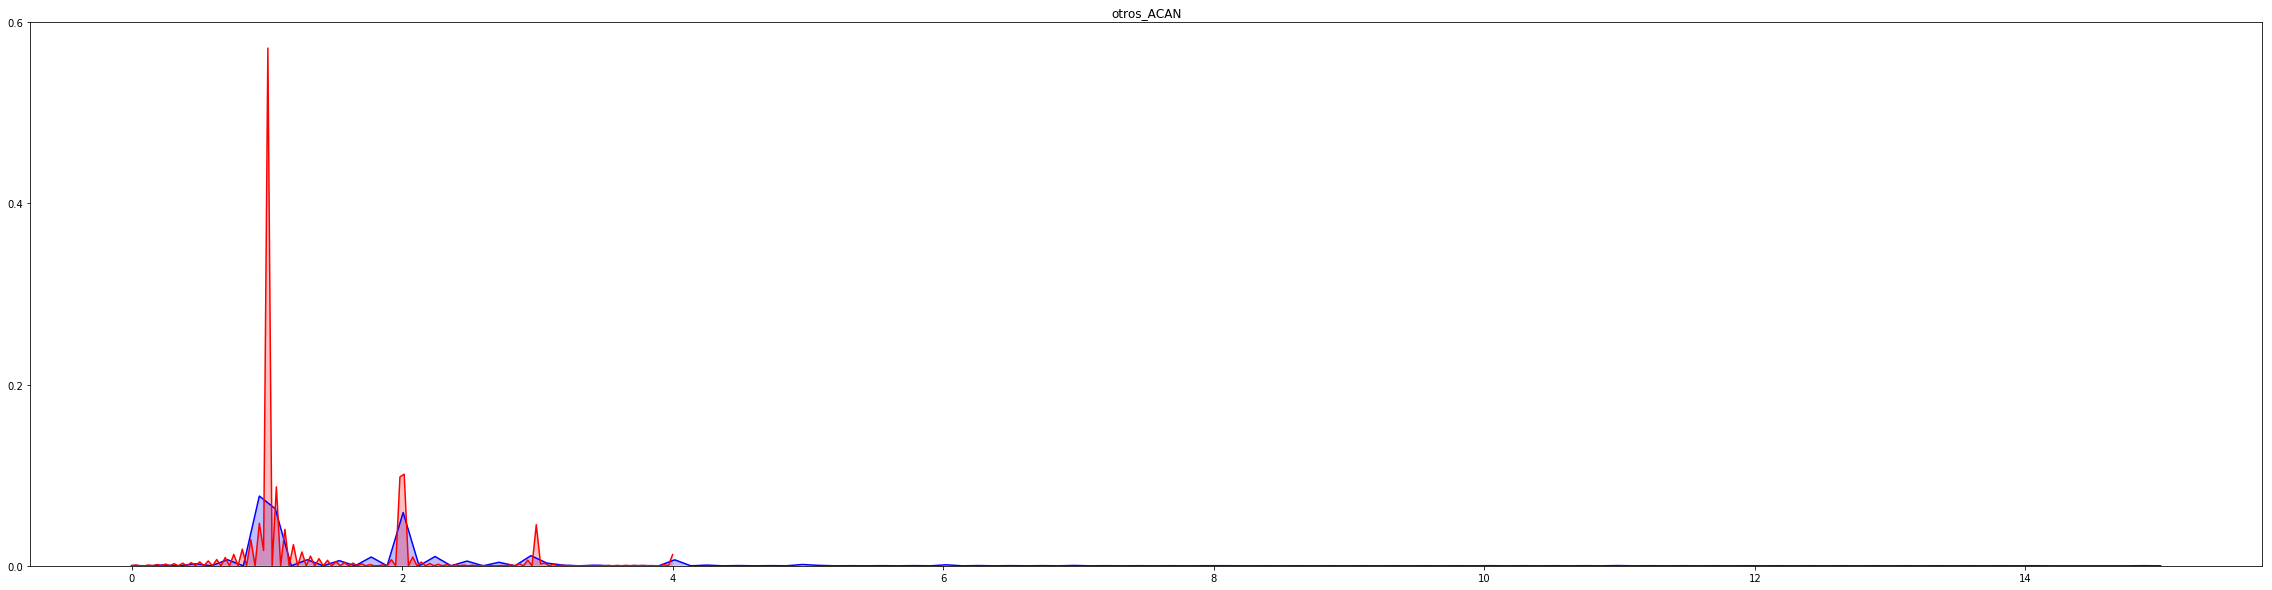

gnv_inc_rel_mou_ORANGE_d90


<Figure size 432x288 with 0 Axes>

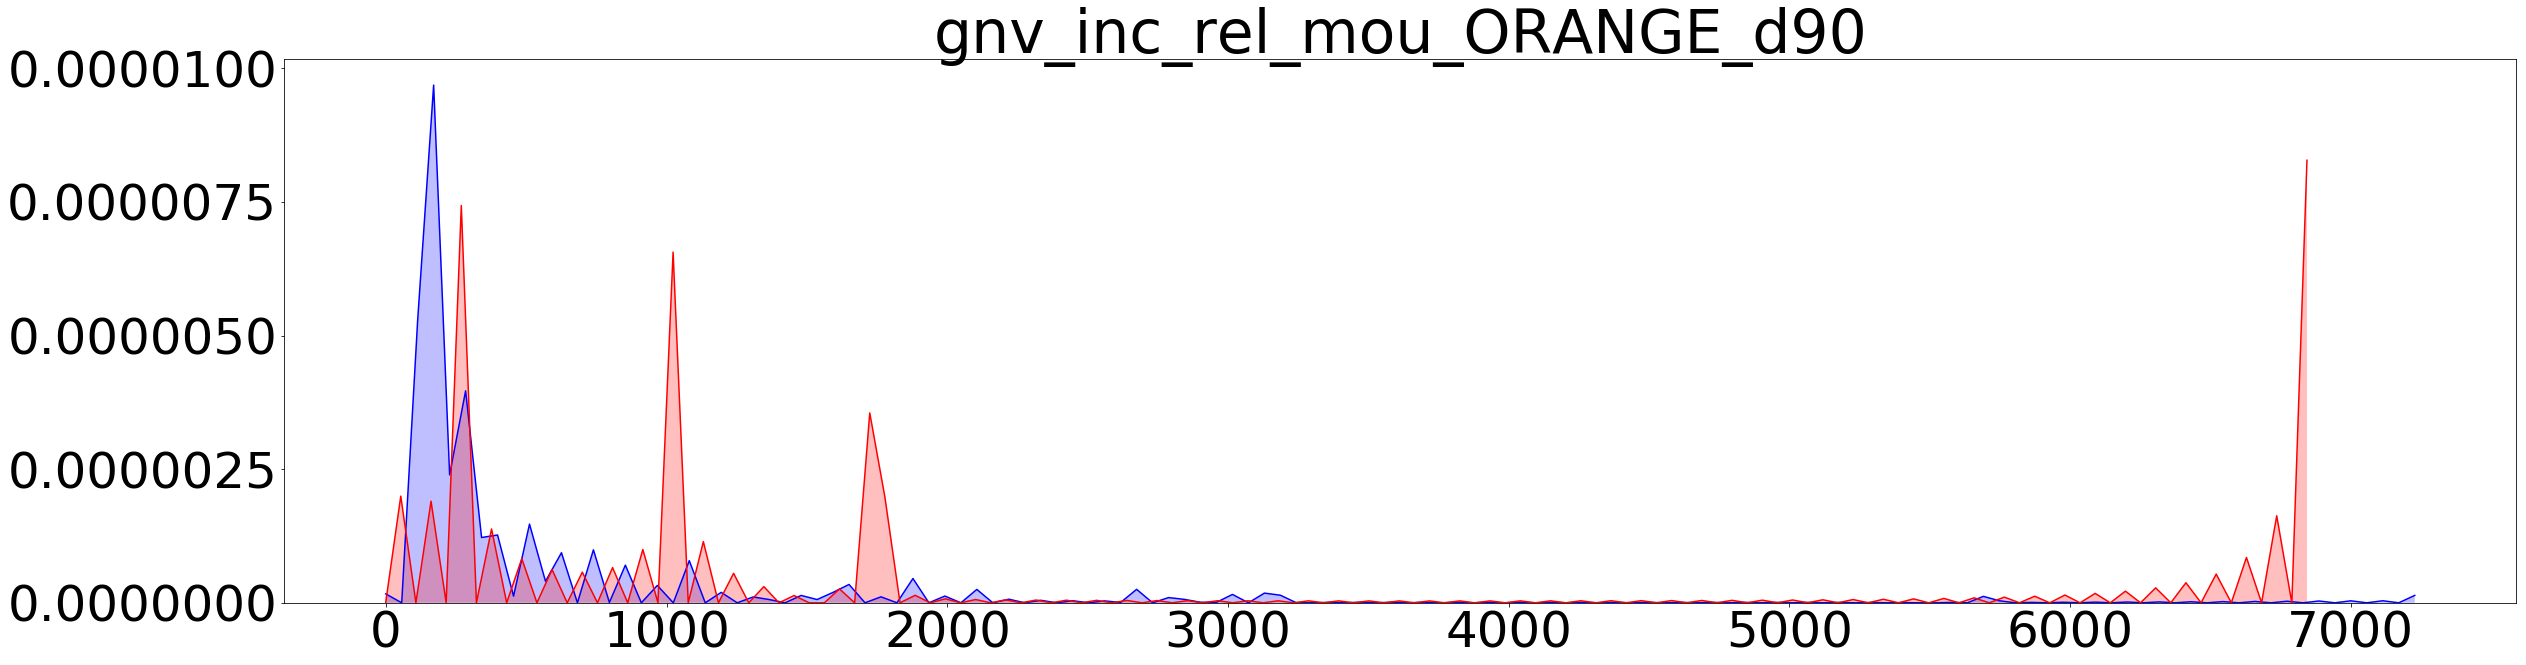

gnv_num_calls_PEPEPHONE


<Figure size 432x288 with 0 Axes>

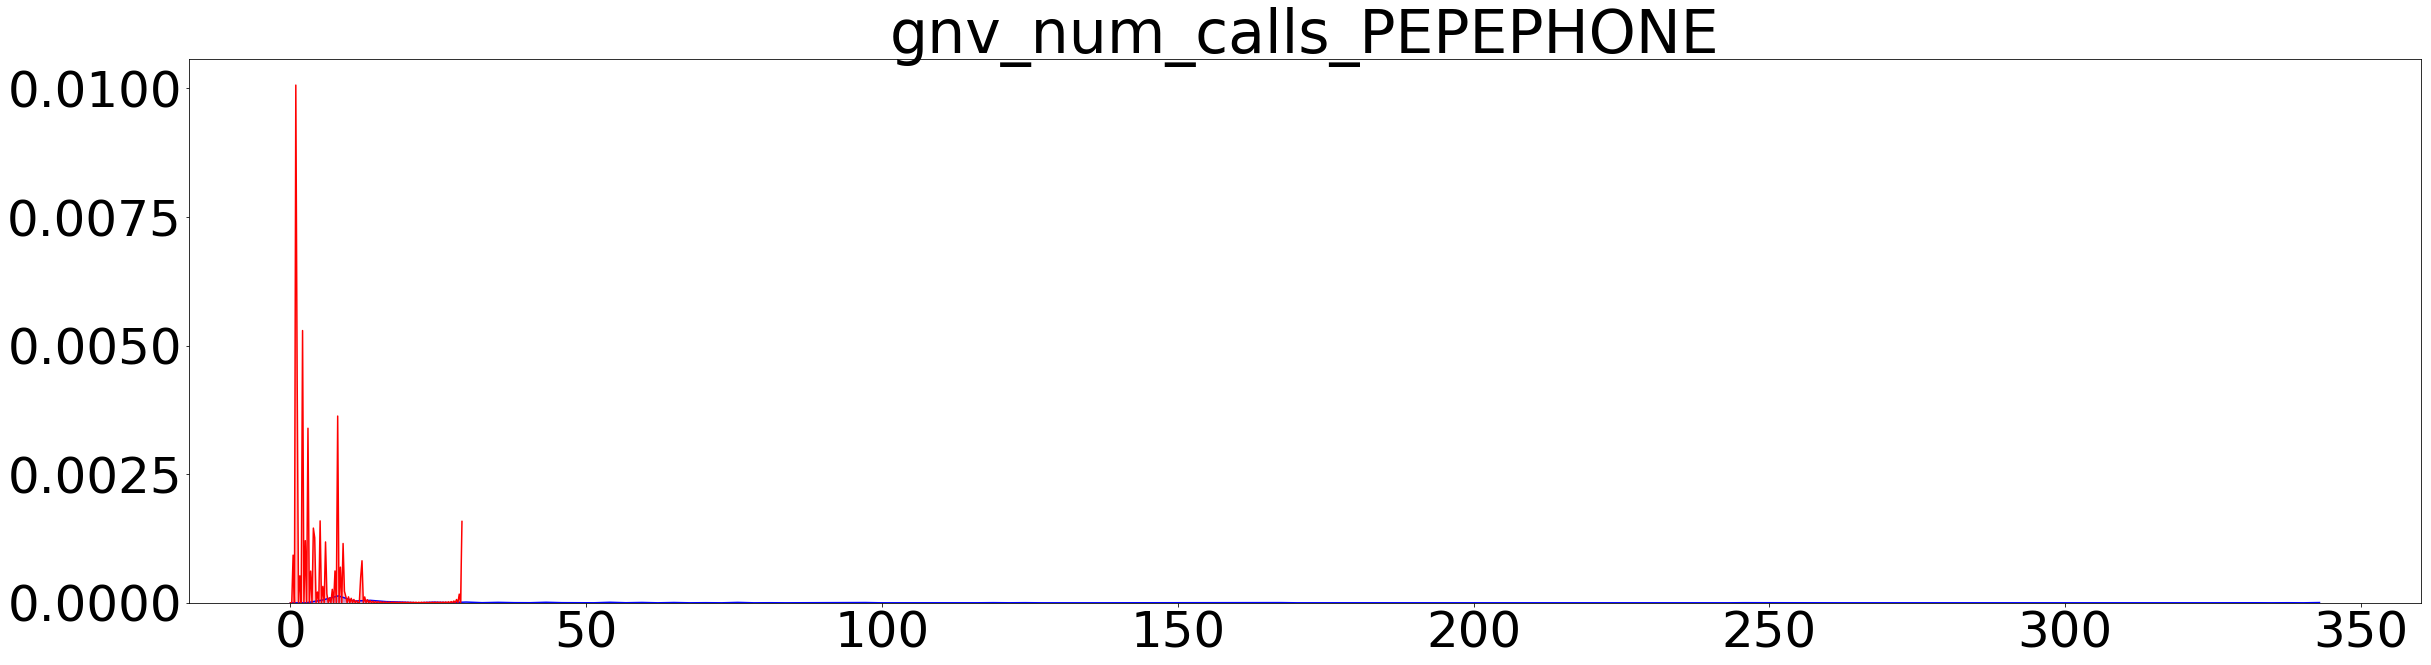

OTHER_CUSTOMER_INFOSATIS_START_AVERIA_w2


/opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<Figure size 432x288 with 0 Axes>

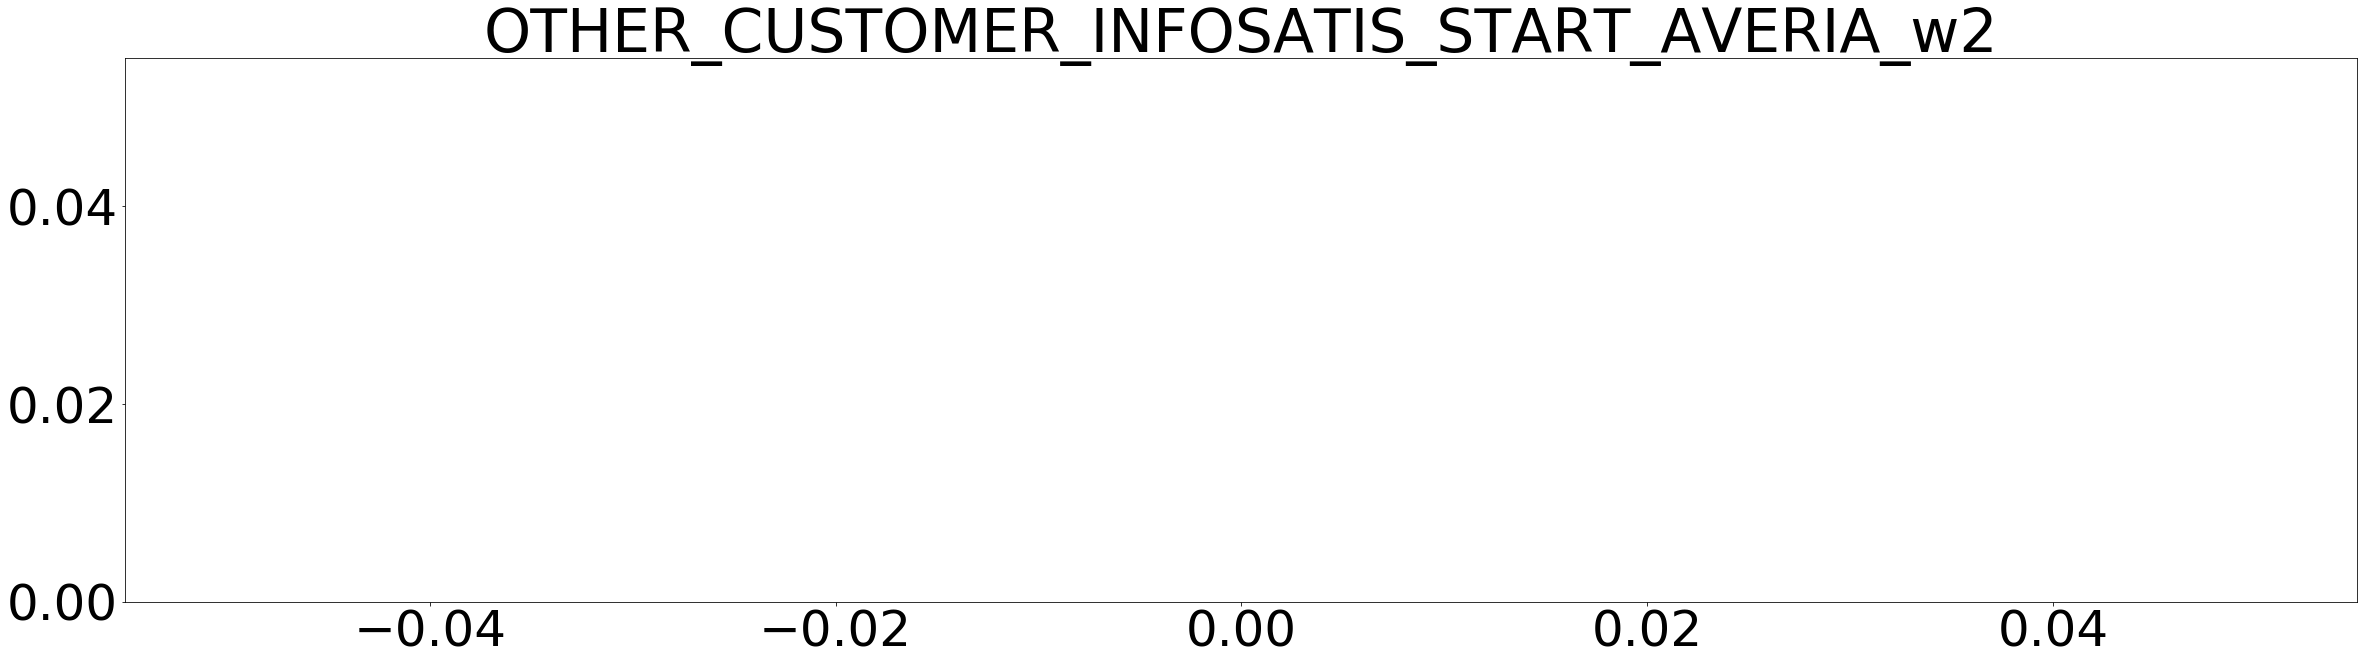

JAZZTEL_max_days_since_navigation


<Figure size 432x288 with 0 Axes>

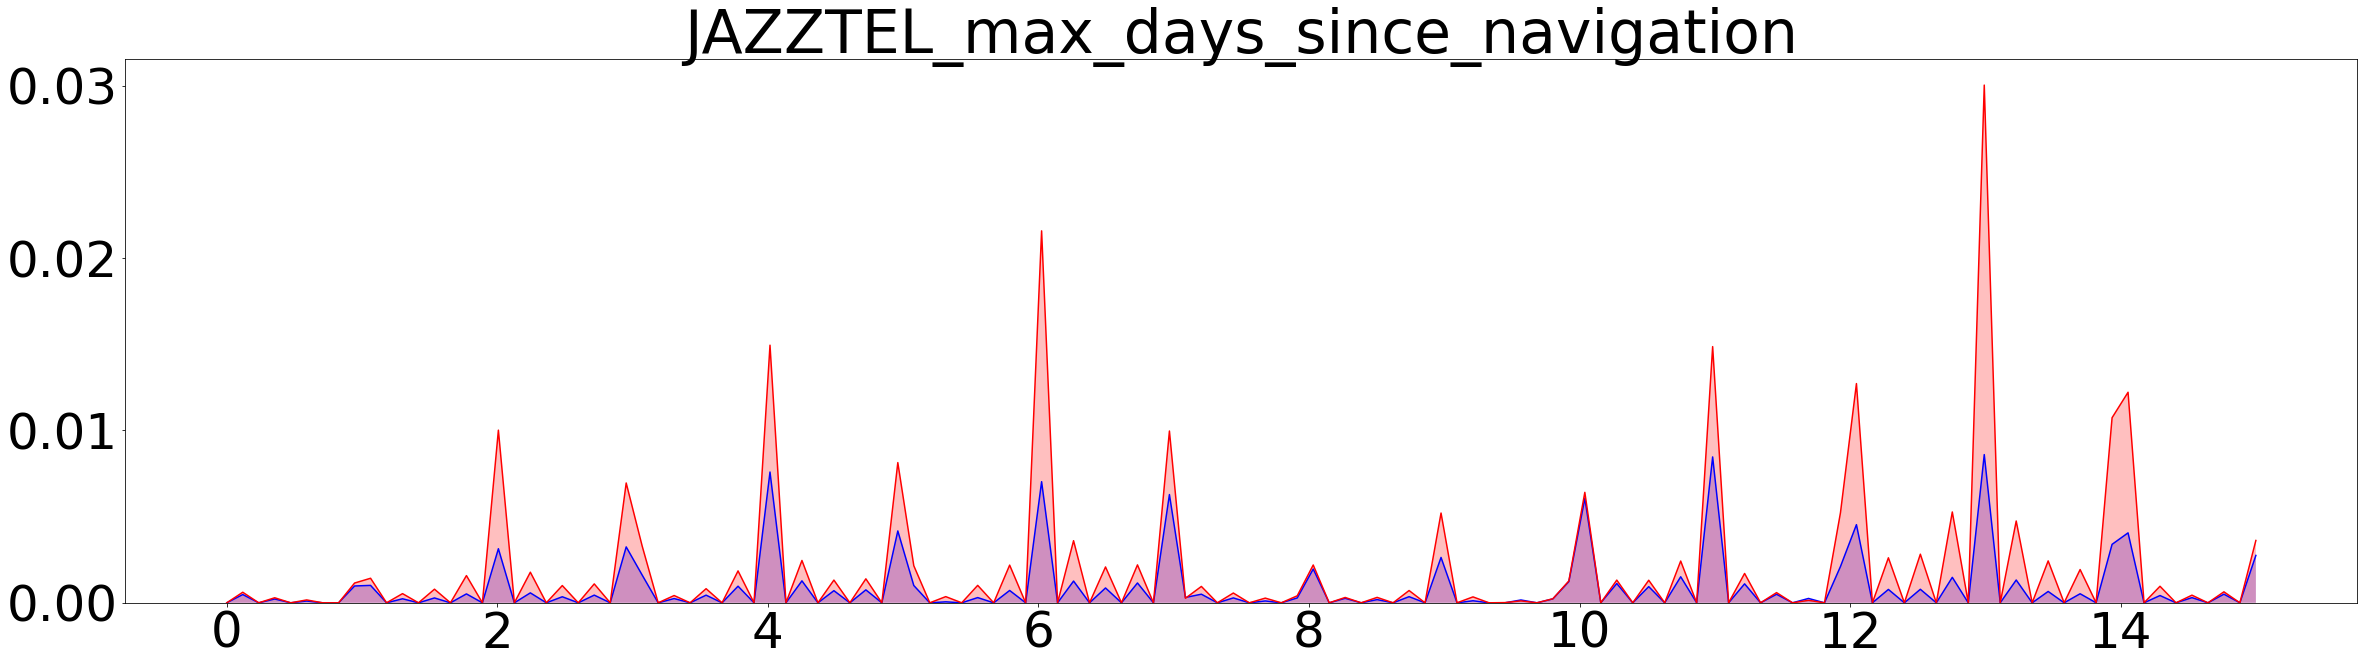

pepephone_AENV


<Figure size 432x288 with 0 Axes>

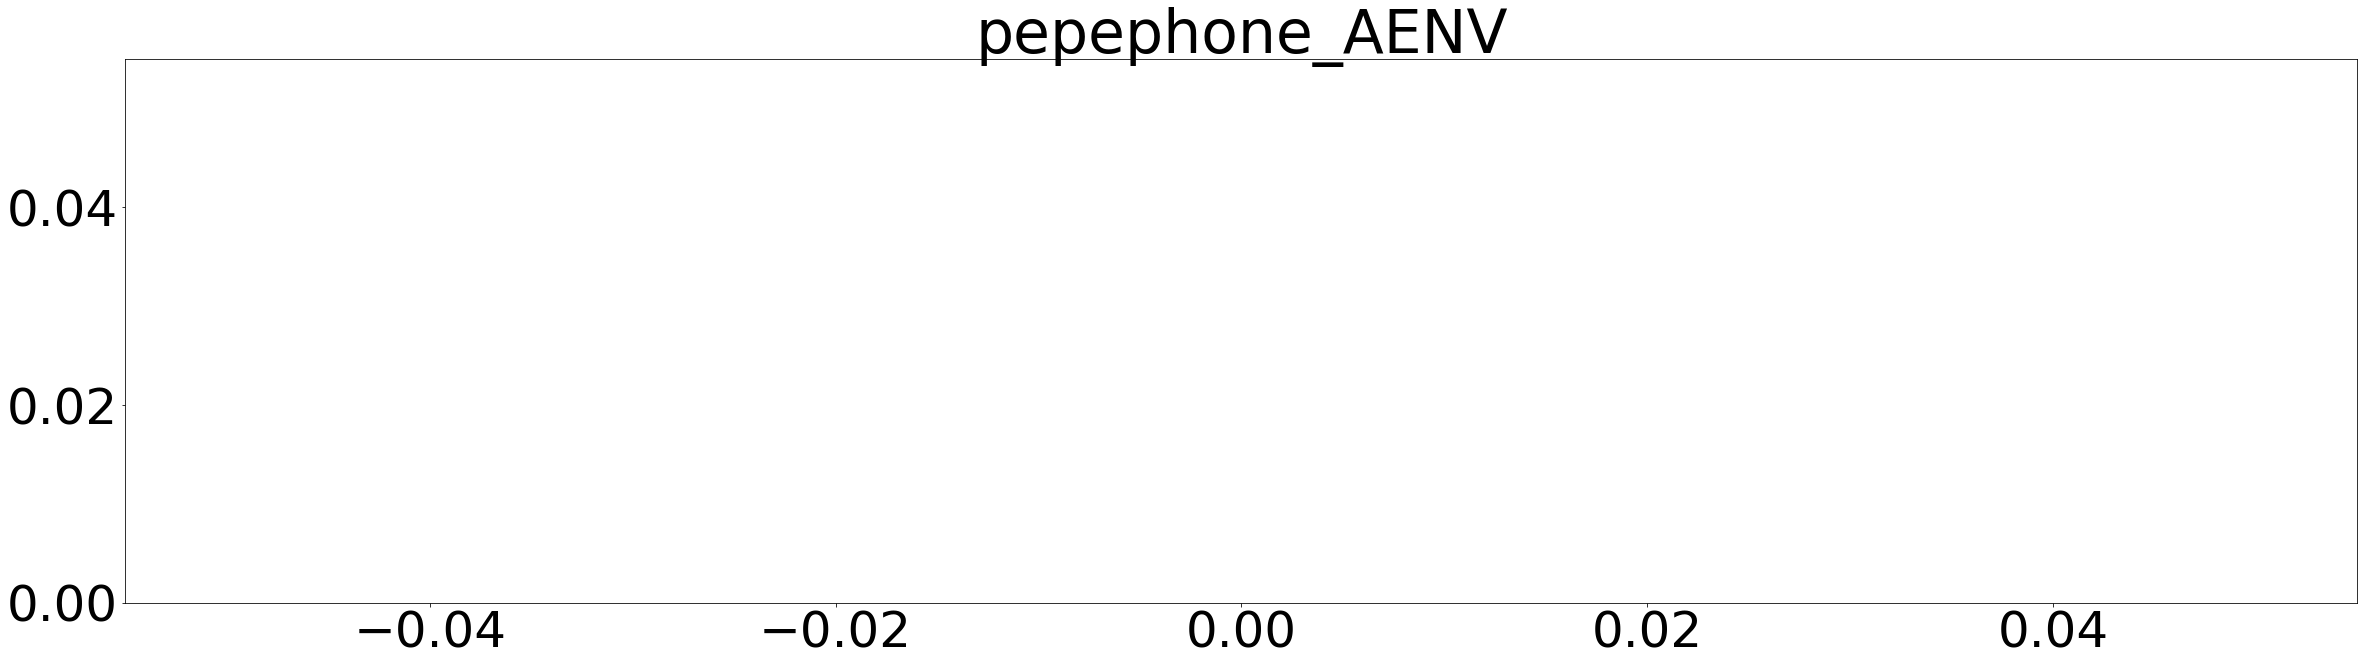

gnv_inc_rel_perc_calls_NEOSKY_d90


<Figure size 432x288 with 0 Axes>

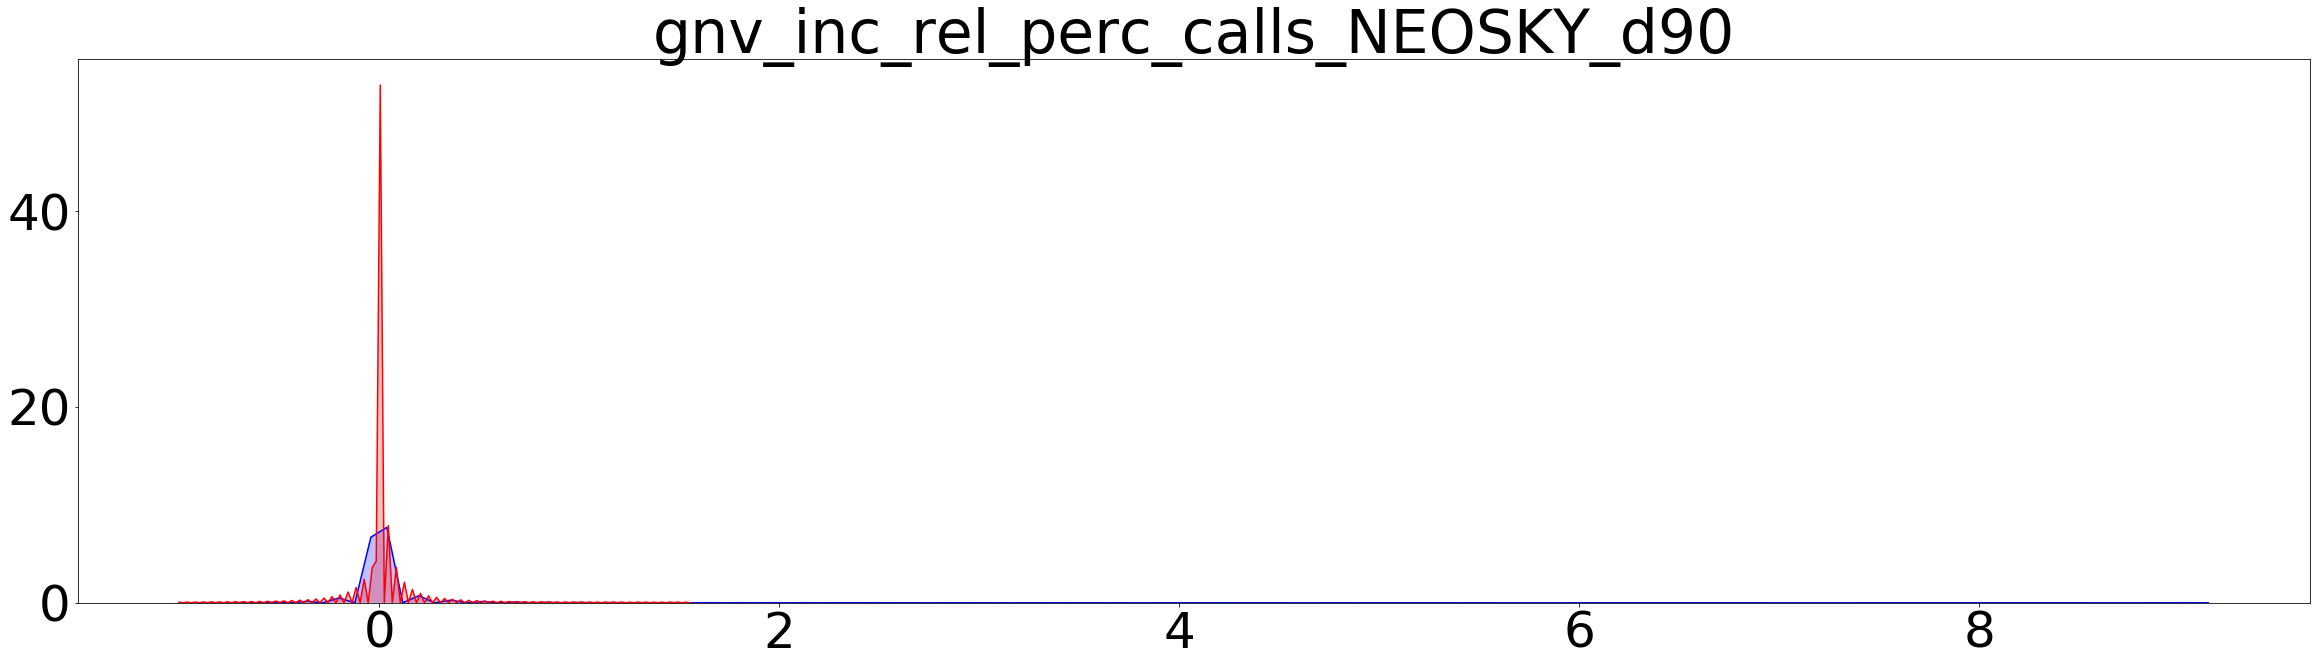

gnv_perc_calls_PROCONO


<Figure size 432x288 with 0 Axes>

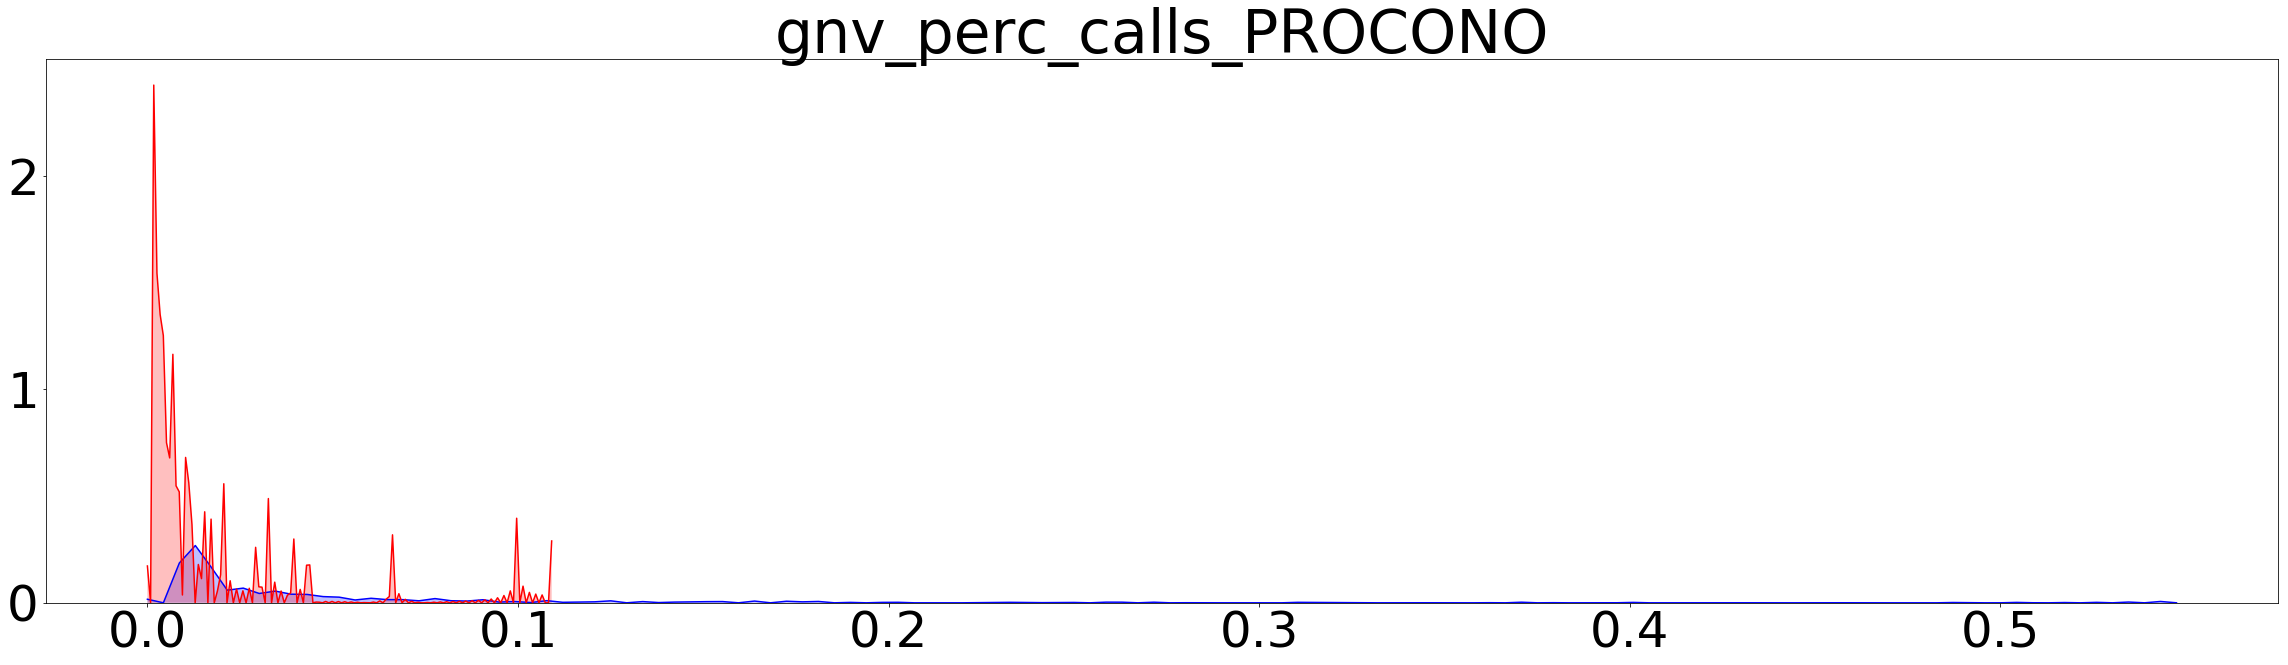

gnv_num_calls_VODAFONE


<Figure size 432x288 with 0 Axes>

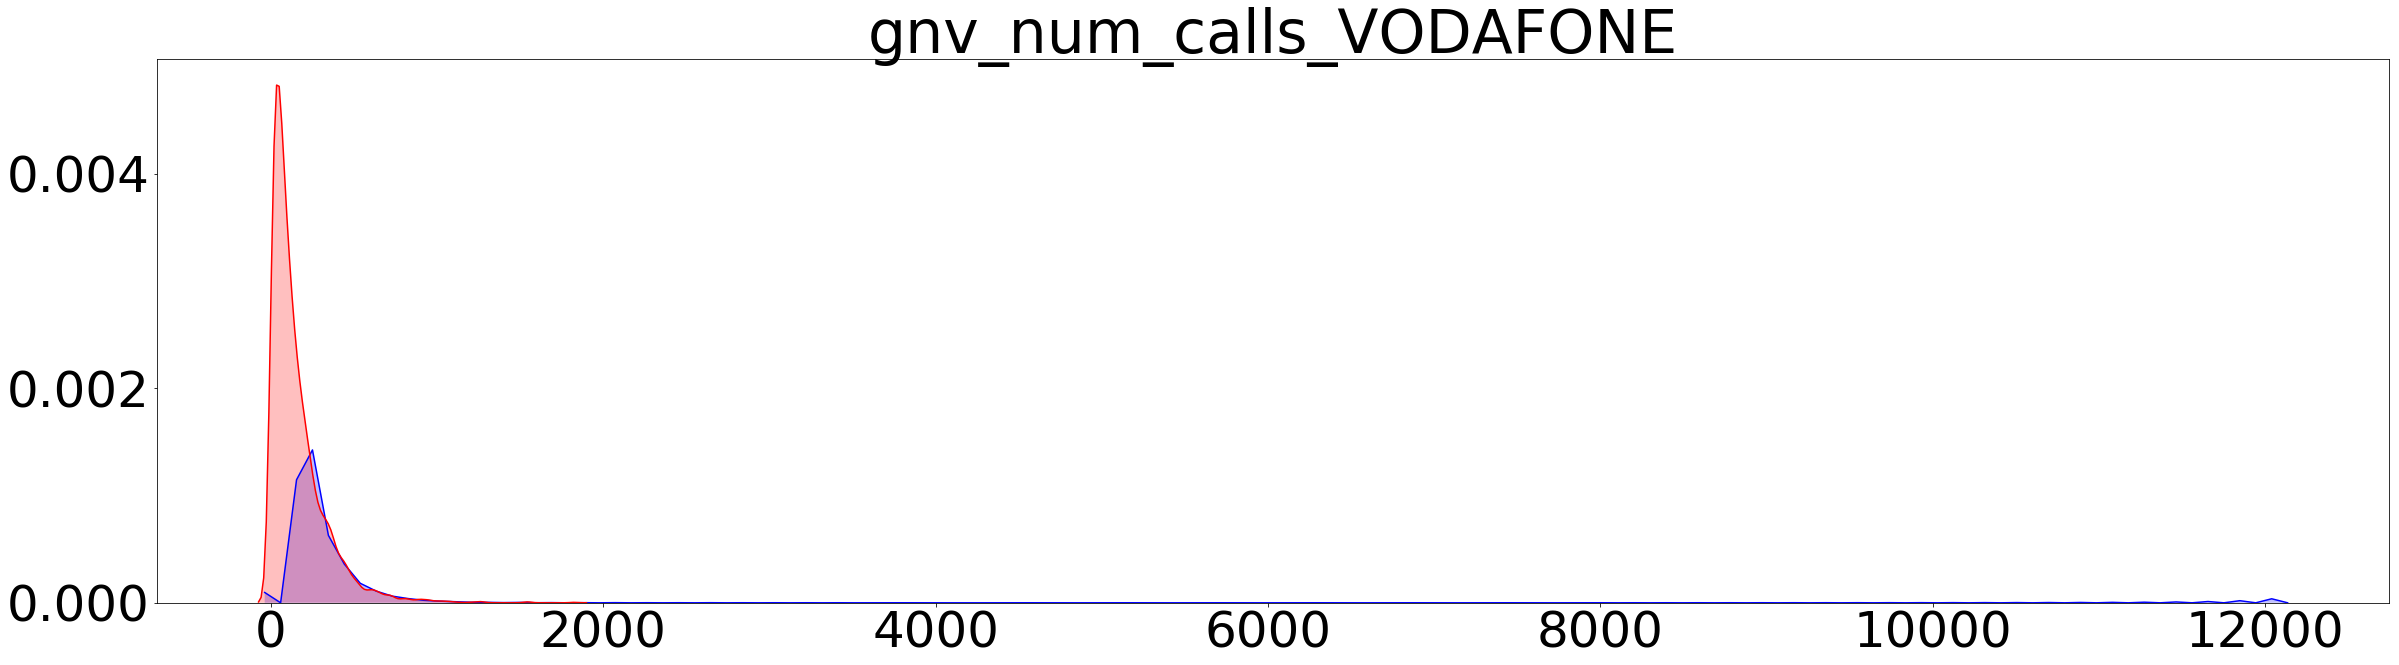

pepephone_ASOL


<Figure size 432x288 with 0 Axes>

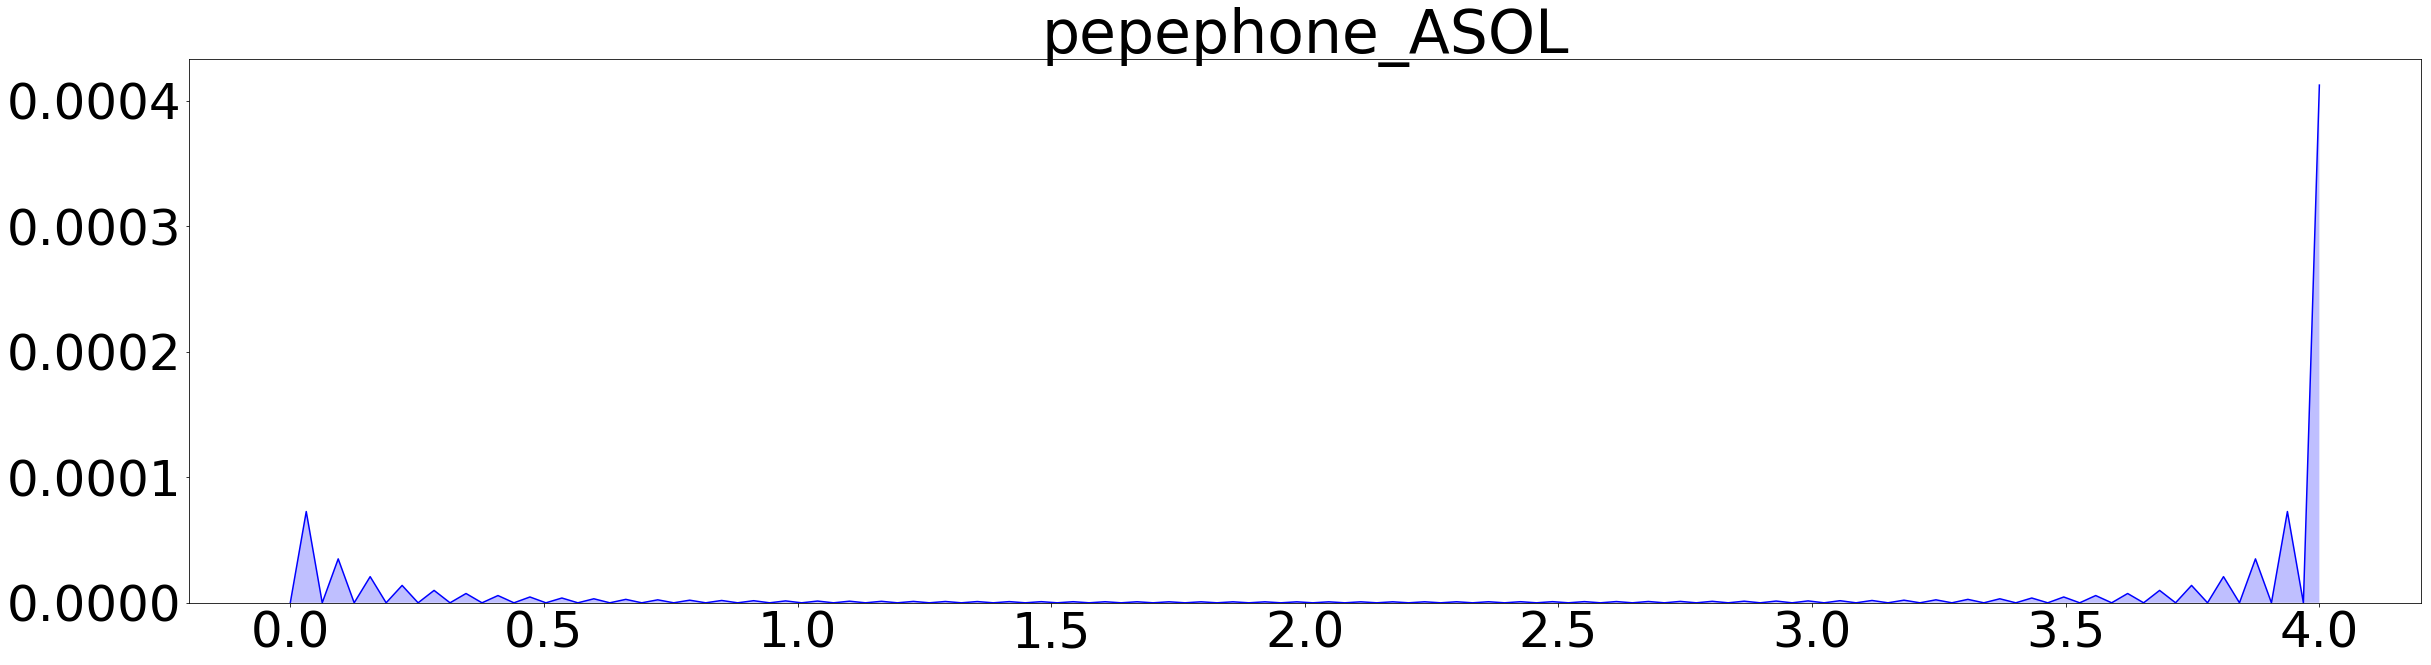

In [5]:
var_imp = ["otros_ACAN", "gnv_inc_rel_mou_ORANGE_d90", "gnv_num_calls_PEPEPHONE", "OTHER_CUSTOMER_INFOSATIS_START_AVERIA_w2", "JAZZTEL_max_days_since_navigation", "pepephone_AENV",
"gnv_inc_rel_perc_calls_NEOSKY_d90", "gnv_perc_calls_PROCONO", "gnv_num_calls_VODAFONE", "pepephone_ASOL"]


df = spark.read.load("/user/csanc109/projects/churn/data/social/df_20200203")

for myvar in var_imp:
    
    plot_features_churn_seaborn_shade2(df, var_to_plot=[myvar], label="label", image_per_row = 1, hist = False)


In [7]:
def get_partitions_path_range(path_, start, end):
    """
    Returns a list of complete paths with data to read of the source between two dates
    :param path: string path
    :param start: string date start
    :param end: string date end
    :return: list of paths
    """
    star_date = dt.datetime.strptime(start, '%Y%m%d')
    delta = dt.datetime.strptime(end, '%Y%m%d') - dt.datetime.strptime(start, '%Y%m%d')
    days_list = [star_date + dt.timedelta(days=i) for i in range(delta.days + 1)]
    return [path_ + "year={}/month={}/day={}".format(d.year, d.month, d.day) for d in days_list]

path_ = '/data/raw/vf_es/billingtopsups/TRAFFICTARIFOW/1.0/parquet/'
start = "20190527"
end = "20190825"

geneva_traffic_paths = get_partitions_path_range(path_, start, end)
iters = len(geneva_traffic_paths)

parts_ = []
for i in range(0, iters):
    print("CSANC109 DEBUG iter={} - path={}".format(i, geneva_traffic_paths[i]))
    df = (spark.read.load(geneva_traffic_paths[i]).where((col('event_type_id').isin(1, 13, 18))).drop(*['service_processed_at', 'service_file_id']))
    parts_.append(df)



CSANC109 DEBUG iter=0 - path=/data/raw/vf_es/billingtopsups/TRAFFICTARIFOW/1.0/parquet/year=2019/month=5/day=27
CSANC109 DEBUG iter=1 - path=/data/raw/vf_es/billingtopsups/TRAFFICTARIFOW/1.0/parquet/year=2019/month=5/day=28
CSANC109 DEBUG iter=2 - path=/data/raw/vf_es/billingtopsups/TRAFFICTARIFOW/1.0/parquet/year=2019/month=5/day=29
CSANC109 DEBUG iter=3 - path=/data/raw/vf_es/billingtopsups/TRAFFICTARIFOW/1.0/parquet/year=2019/month=5/day=30
CSANC109 DEBUG iter=4 - path=/data/raw/vf_es/billingtopsups/TRAFFICTARIFOW/1.0/parquet/year=2019/month=5/day=31
CSANC109 DEBUG iter=5 - path=/data/raw/vf_es/billingtopsups/TRAFFICTARIFOW/1.0/parquet/year=2019/month=6/day=1
CSANC109 DEBUG iter=6 - path=/data/raw/vf_es/billingtopsups/TRAFFICTARIFOW/1.0/parquet/year=2019/month=6/day=2
CSANC109 DEBUG iter=7 - path=/data/raw/vf_es/billingtopsups/TRAFFICTARIFOW/1.0/parquet/year=2019/month=6/day=3
CSANC109 DEBUG iter=8 - path=/data/raw/vf_es/billingtopsups/TRAFFICTARIFOW/1.0/parquet/year=2019/month=6/da

20200401-125130 [ERROR] Exception while sending command.
Traceback (most recent call last):
  File "/opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/site-packages/py4j/java_gateway.py", line 985, in send_command
    response = connection.send_command(command)
  File "/opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/site-packages/py4j/java_gateway.py", line 1164, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
Py4JNetworkError: Error while receiving


Py4JError: An error occurred while calling o375.load